In [73]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)

import sqlalchemy_schemadisplay
from sqlalchemy import MetaData

schema_viz = sqlalchemy_schemadisplay.create_schema_graph(metadata=MetaData(db))
schema_viz.write_png('dbschema.png')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [74]:
image_dir = "/Users/schlinkertc/code/mlb_predictions/mlb_predictions/images/"

## What's in our DB?


The yankees played the mets on my birthday, so obviously we're gonna look at that game

In [75]:
yankees = session.query(Team).filter(Team.teamName=='Yankees').one()
yankees.id

147

In [76]:
june_11 = datetime(2019,6,11)
yankees_mets6_11 = (session.query(Game)
                    .order_by(Game.dateTime.asc())
                    .filter(and_(Game.dateTime>june_11,
                                 Game.homeTeam_id==yankees.id))
                    .first())

In [77]:
yankees_mets6_11

<Game(pk='567491',id='2019/06/11/nynmlb-nyamlb-1')>

In [78]:
# we won!
home_score = max([x.homeScore for x in yankees_mets6_11.plays])
away_score = max([x.awayScore for x in yankees_mets6_11.plays])
print(home_score,away_score)

12 5


## Import Dataset

In [79]:
cat_df=functions.getGame_df()
df=functions.load_dataset(session)

grand_df=pd.merge(left=df,
                  right=cat_df,
                  left_on='ID',
                  right_on='id')

In [80]:
grand_df.shape

(4859, 127)

## Let's go exploring

First, we'll look at the numerical features.

- Where do individual players' avgs lie on univariate distributions of features
- compare/contrast feature distributions by winning/losing teams

In [81]:
df_homeWin=df[df['home_score']>df['away_score']]
df_awayWin=df[df['home_score']<df['away_score']]

#### seperate stats by winning/losing teams

In [82]:
stats = {x.split("_",1)[1] for x in df.columns.tolist() if x != 'ID'}
stats

{'hitters_BA_mean',
 'hitters_BA_std',
 'hitters_FO_O_mean',
 'hitters_FO_O_std',
 'hitters_GO_O_mean',
 'hitters_GO_O_std',
 'hitters_LO_O_mean',
 'hitters_LO_O_std',
 'hitters_OBP_mean',
 'hitters_OBP_std',
 'hitters_PA_per_Game_mean',
 'hitters_PA_per_Game_std',
 'hitters_PO_O_mean',
 'hitters_PO_O_std',
 'hitters_SLG_mean',
 'hitters_SLG_std',
 'relief_BA_mean',
 'relief_BA_std',
 'relief_FO_O_mean',
 'relief_FO_O_std',
 'relief_GO_O_mean',
 'relief_GO_O_std',
 'relief_H9_mean',
 'relief_H9_std',
 'relief_HR9_mean',
 'relief_HR9_std',
 'relief_LO_O_mean',
 'relief_LO_O_std',
 'relief_OBP_mean',
 'relief_OBP_std',
 'relief_PA_per_Game_mean',
 'relief_PA_per_Game_std',
 'relief_PO_O_mean',
 'relief_PO_O_std',
 'relief_SLG_mean',
 'relief_SLG_std',
 'relief_SO9_mean',
 'relief_SO9_std',
 'relief_SOW_mean',
 'relief_SOW_std',
 'relief_WHIP_mean',
 'relief_WHIP_std',
 'score',
 'starter_BA',
 'starter_FO_O',
 'starter_GO_O',
 'starter_H9',
 'starter_HR9',
 'starter_LO_O',
 'starter_OBP'

In [156]:
# e.g. home OBP when home wins,away OBP when home loses
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(14,10)})
def compare_stat_distro(stats,reference_line=False,file_name=False,title=False,x_axis_label=None,y_axis_label=None):
    
    if reference_line:
        plt.axvline(reference_line['x_axis'],
                    color=reference_line.get('color','red'), 
                    linestyle='--', 
                    lw=2,
                    label=reference_line.get('label',None)
                   )
    
    df_homeWin=df[df['home_score']>df['away_score']]
    df_awayWin=df[df['home_score']<df['away_score']]
    
    df_homeWin.replace(to_replace=0,value=np.nan,inplace=True)
    df_awayWin.replace(to_replace=0,value=np.nan,inplace=True)
    
    df_homeWin.dropna(inplace=True)
    df_awayWin.dropna(inplace=True)
    
    for stat in stats:
        winnerStat=df_homeWin[f'home_{stat}'].append(df_awayWin[f'away_{stat}'])
        loserStat=df_homeWin[f'away_{stat}'].append(df_awayWin[f'home_{stat}'])
        
        sns.distplot(winnerStat,label='Winners',kde=True)
        sns.distplot(loserStat,label='Losers',kde=True)
        
        if title:
            plt.title(title,fontdict={'fontsize':20})
        else:
            plt.title(stat)
        if x_axis_label:
            plt.xlabel(x_axis_label)
        if y_axis_label:
            plt.ylabel(y_axis_label)
        
        plt.legend()
        
        if file_name:
            plt.savefig(file_name)
        
        plt.show()

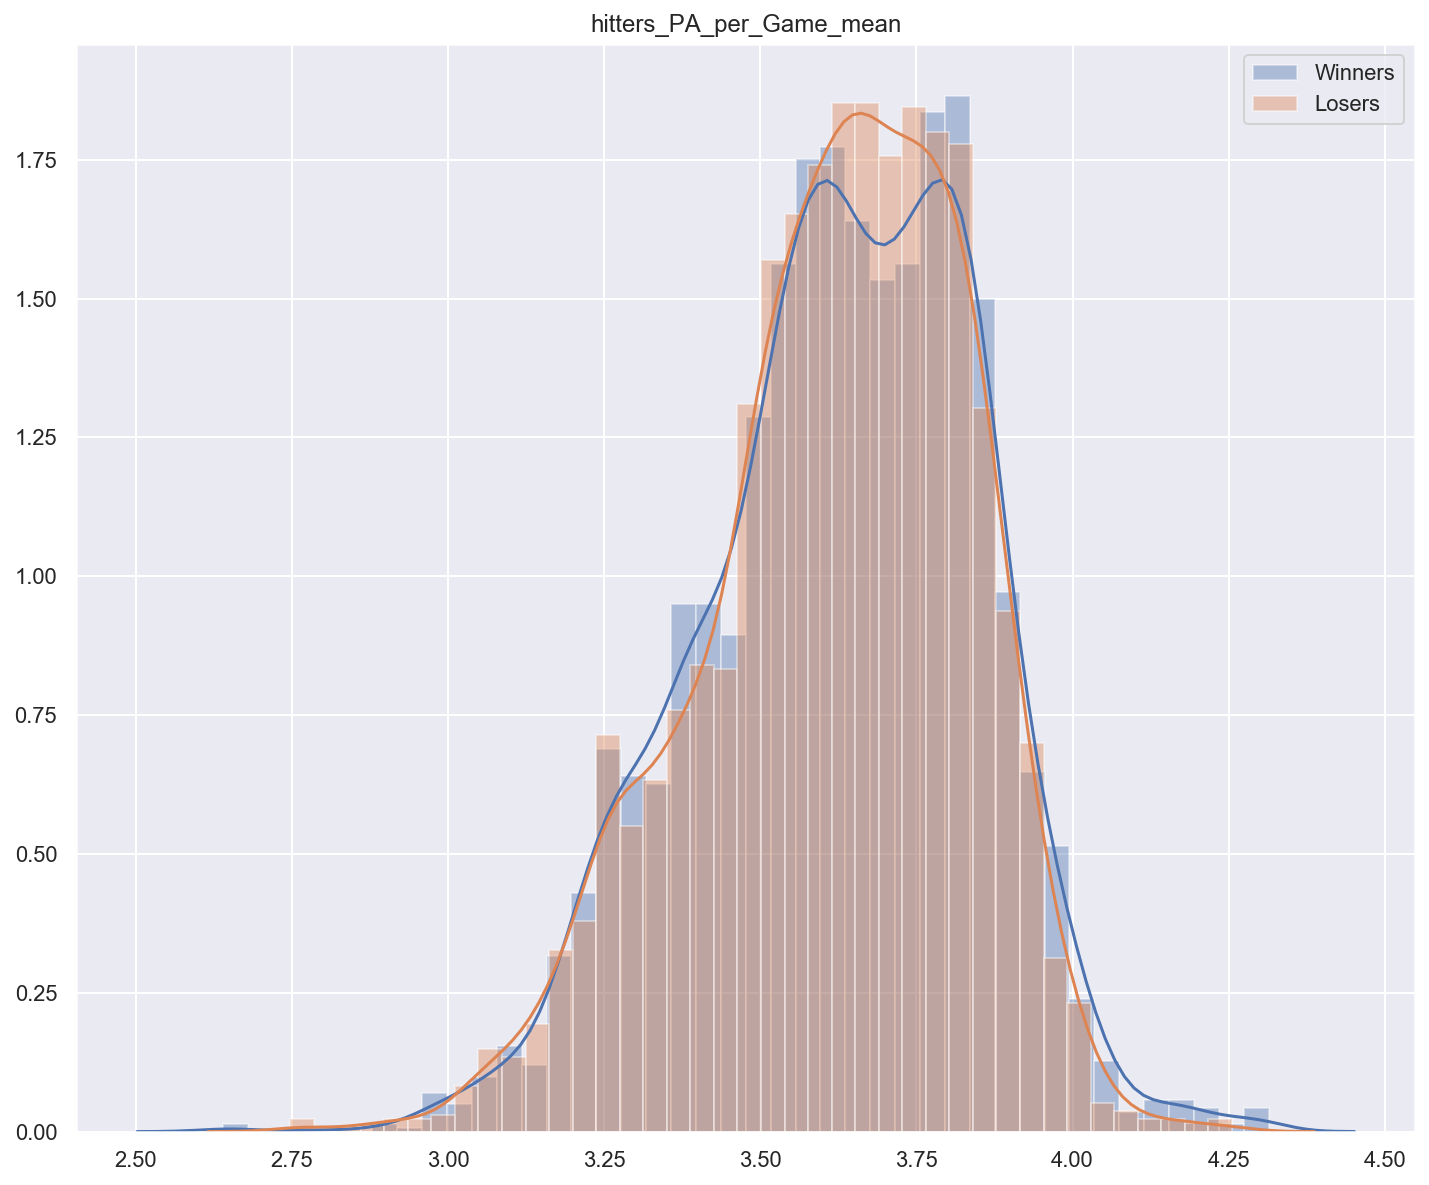

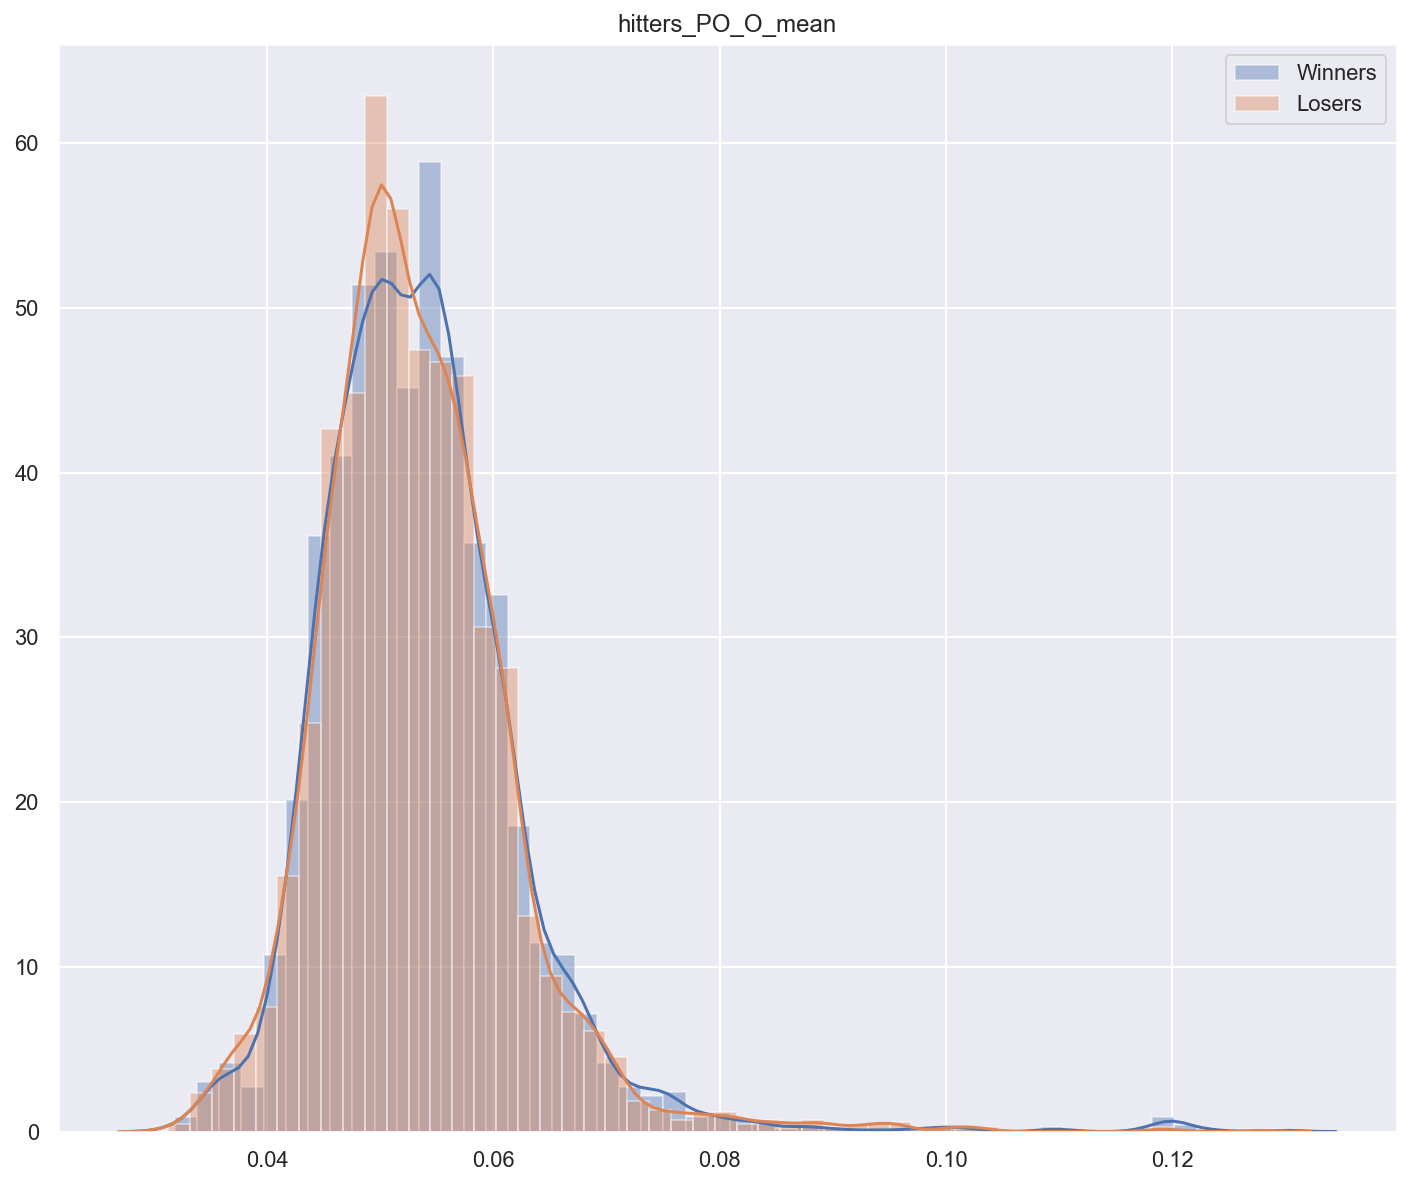

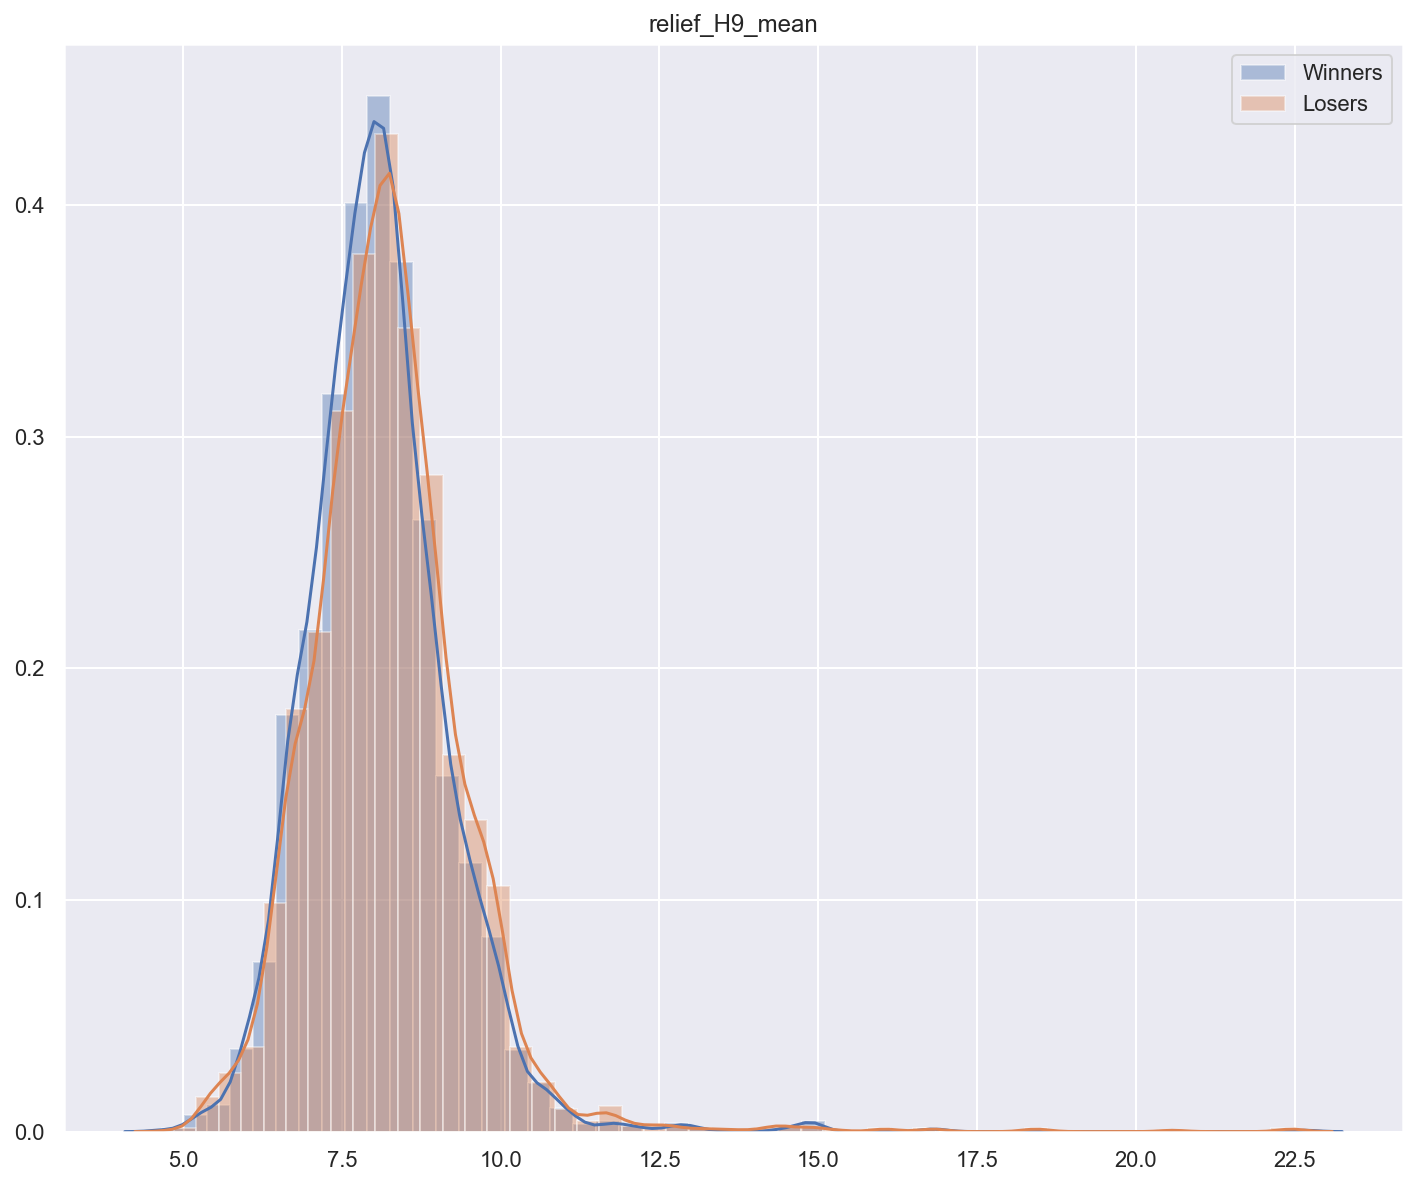

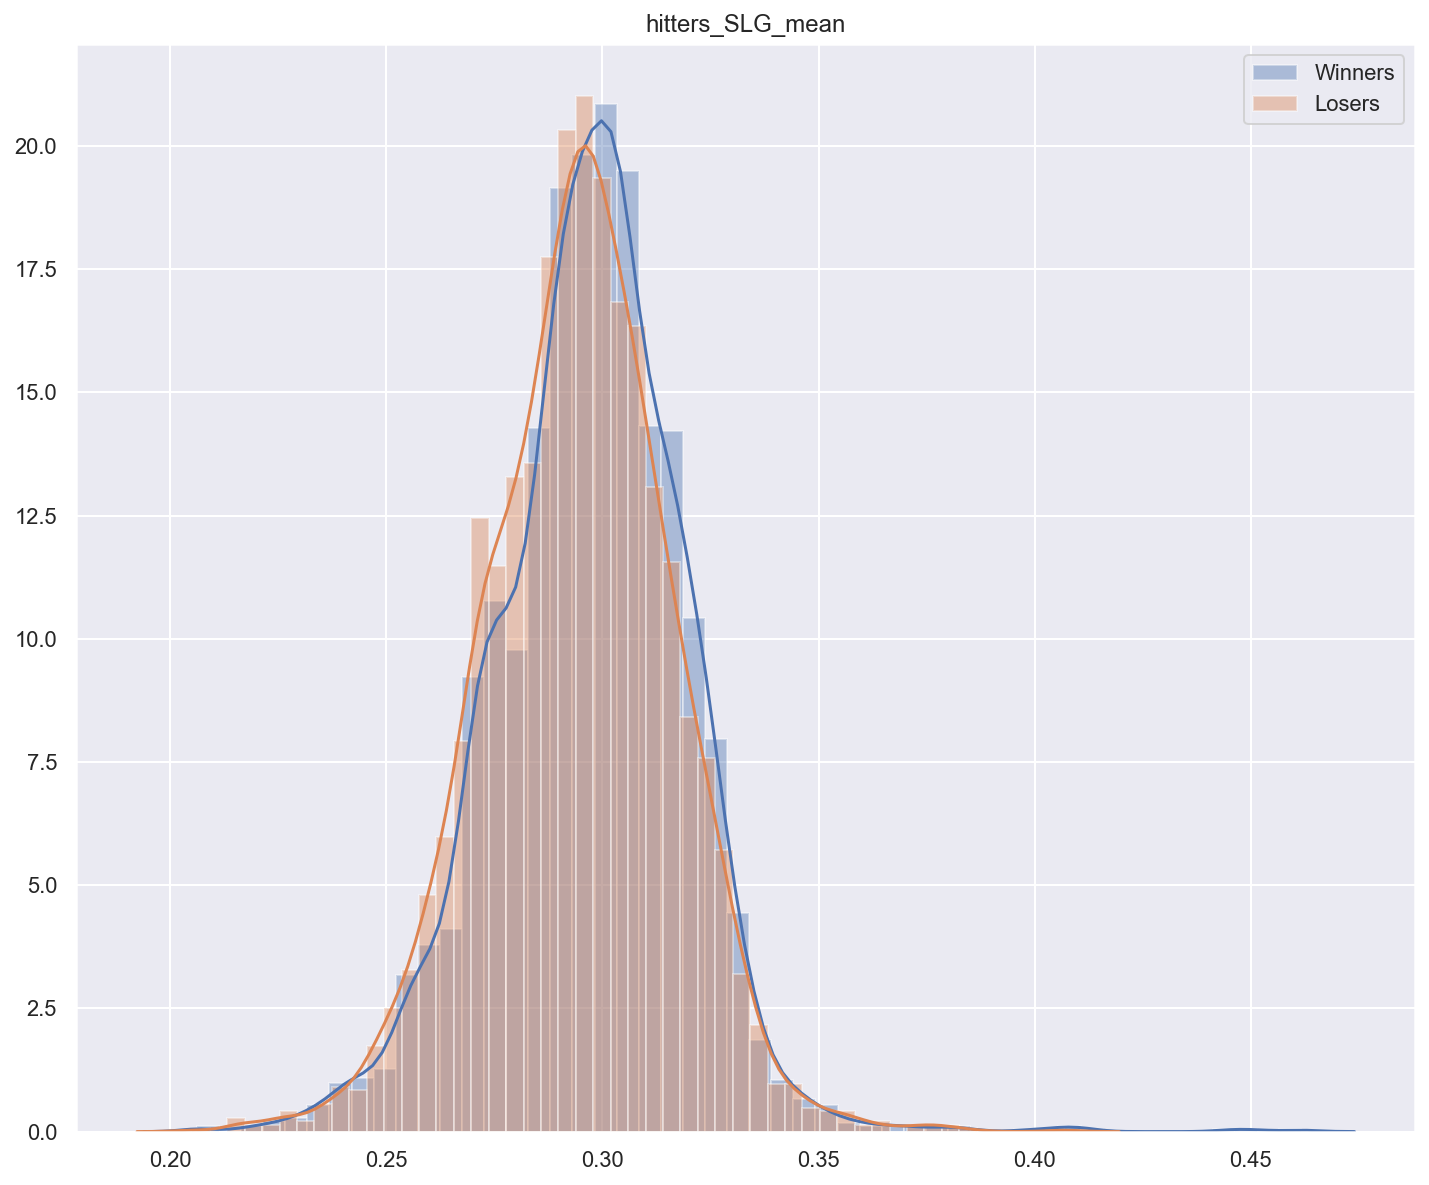

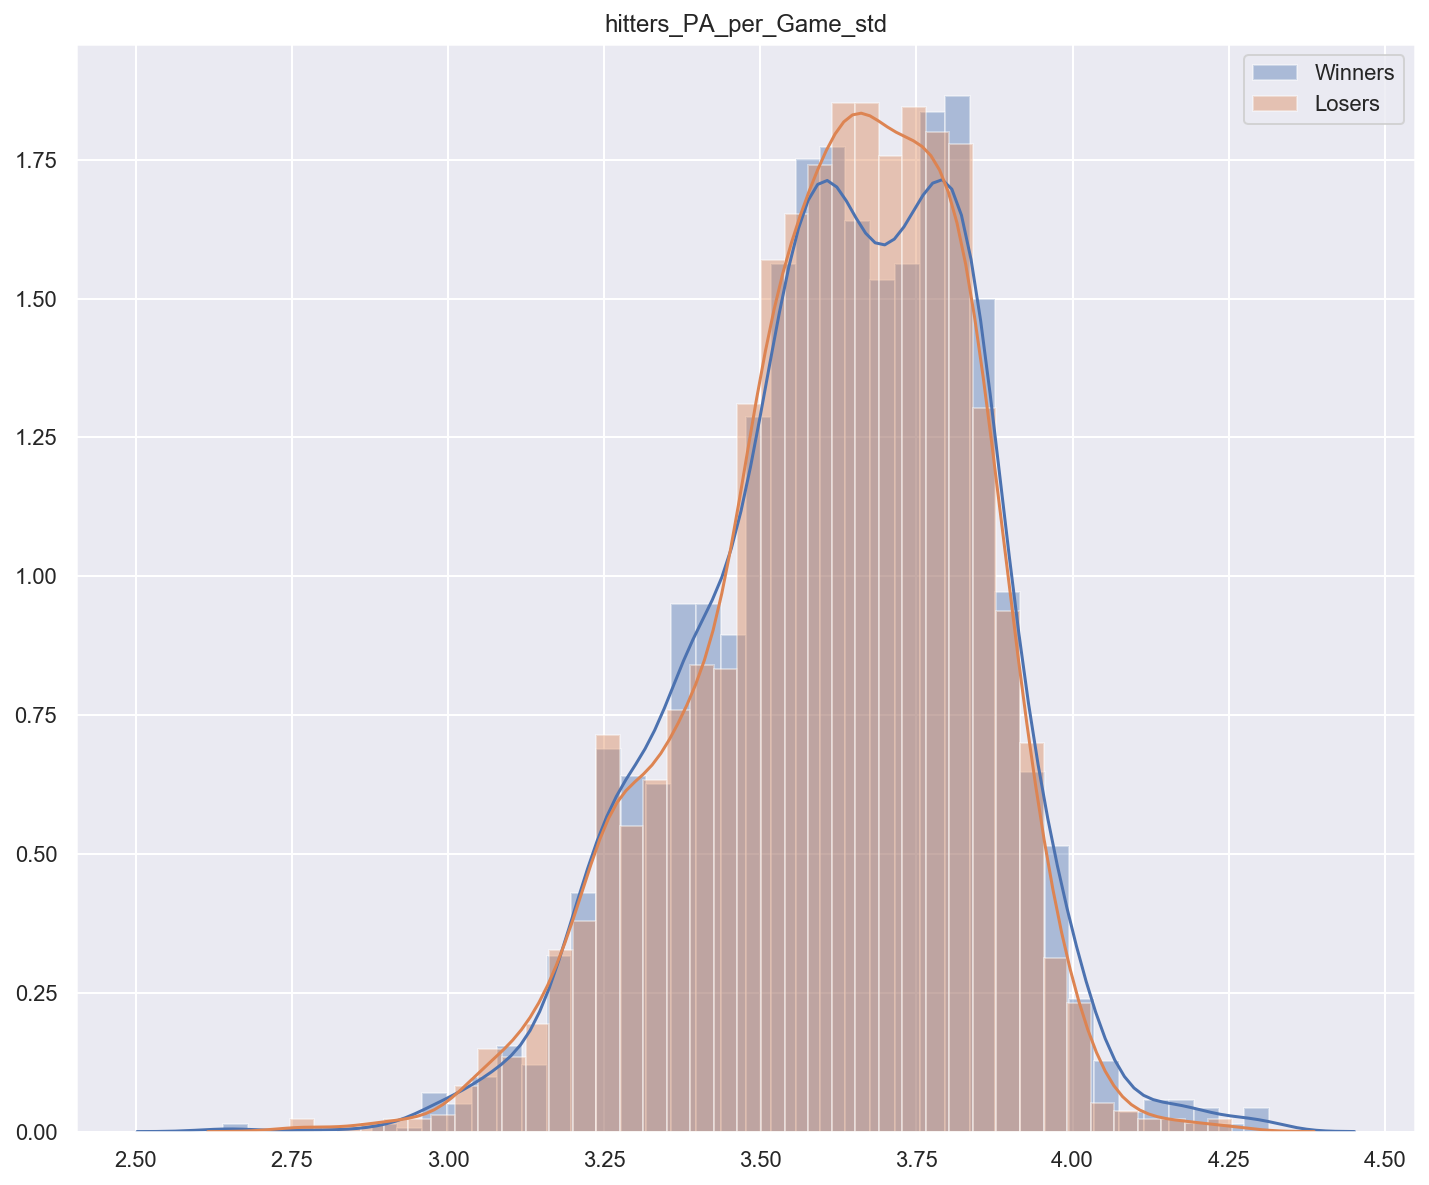

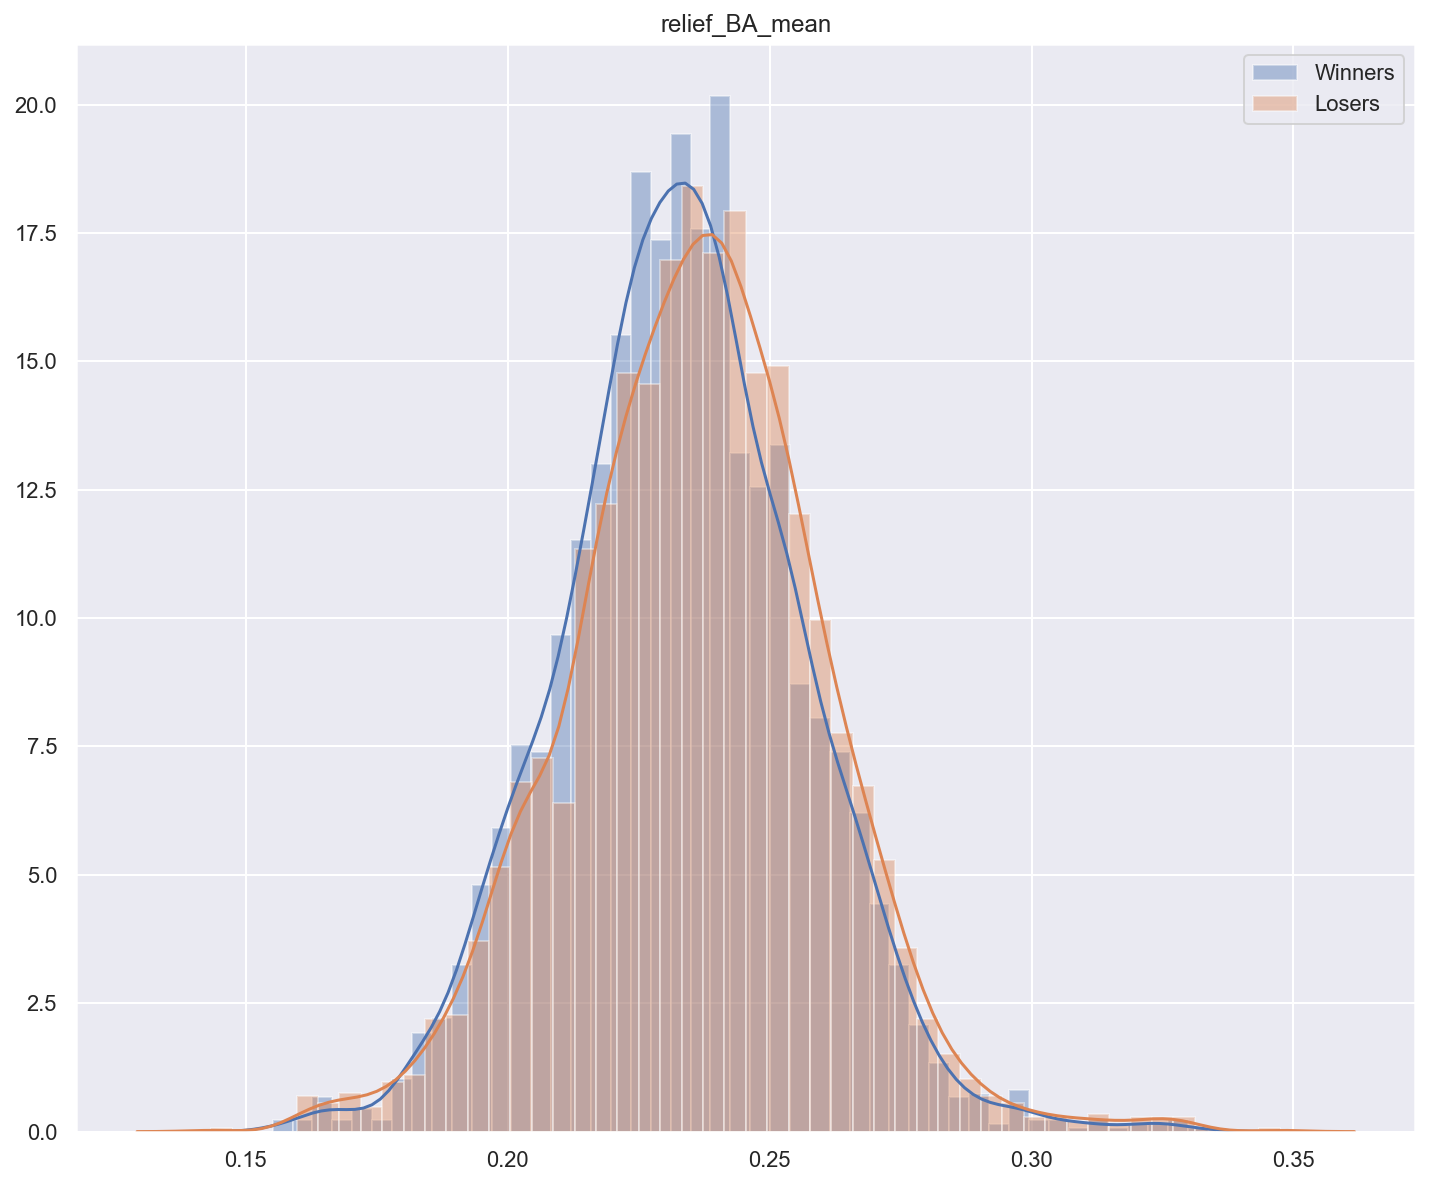

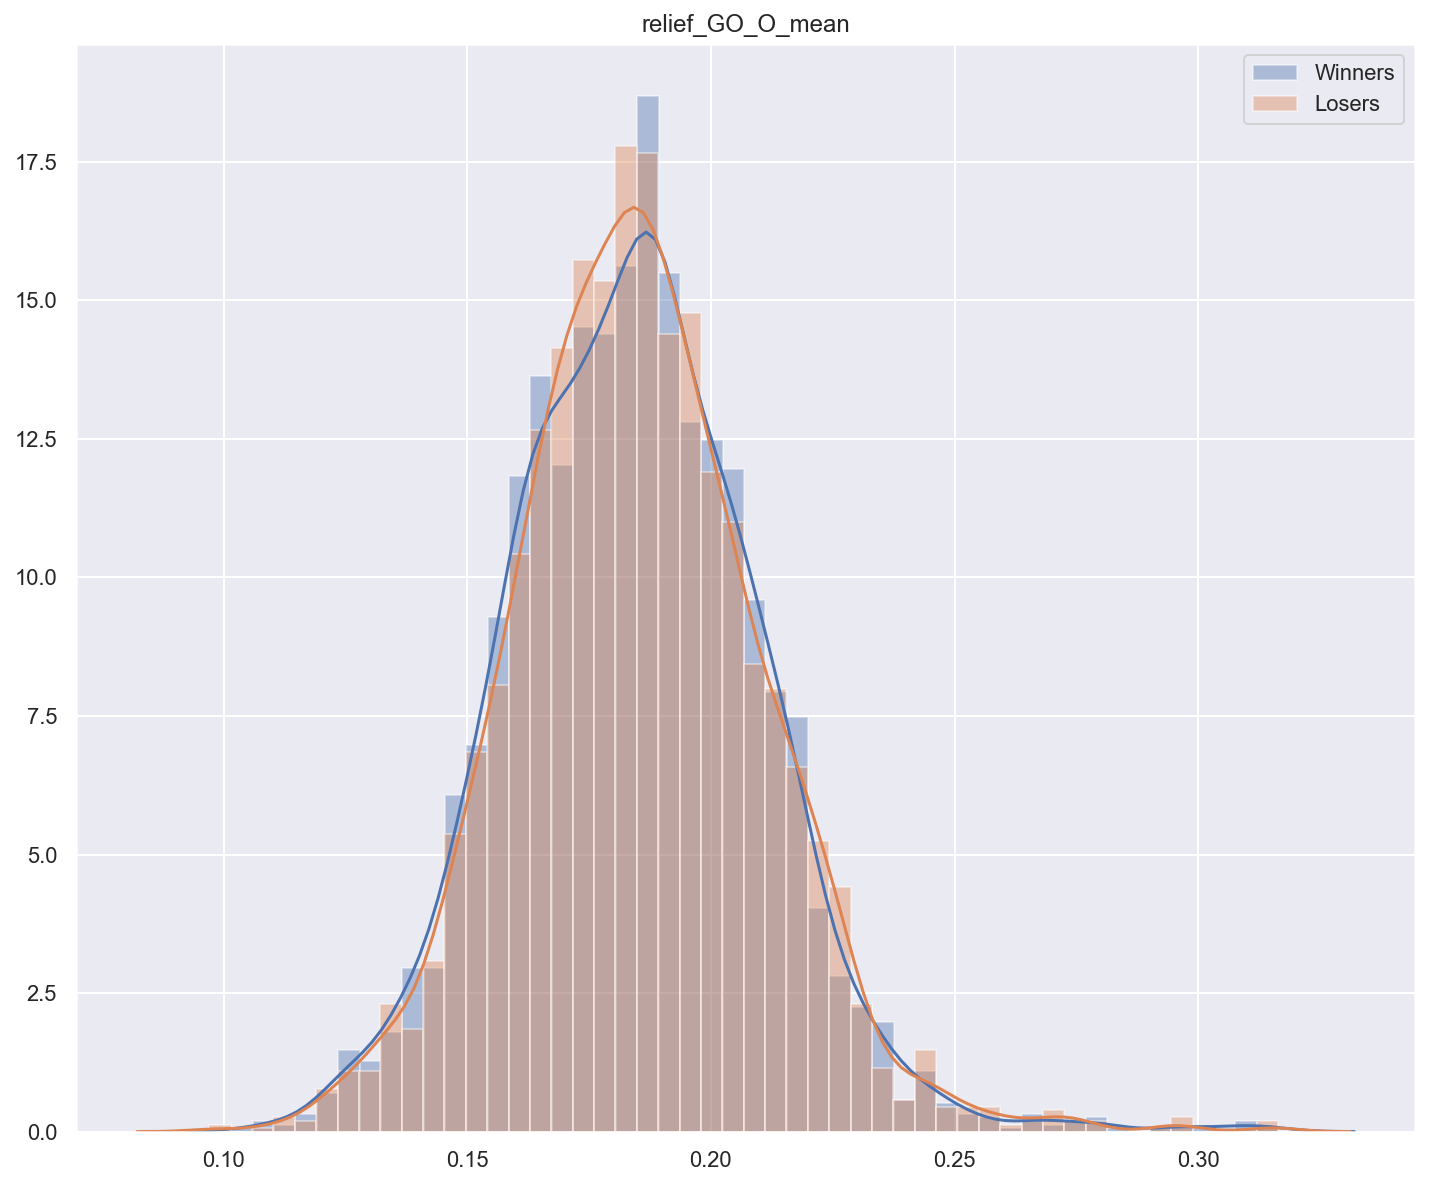

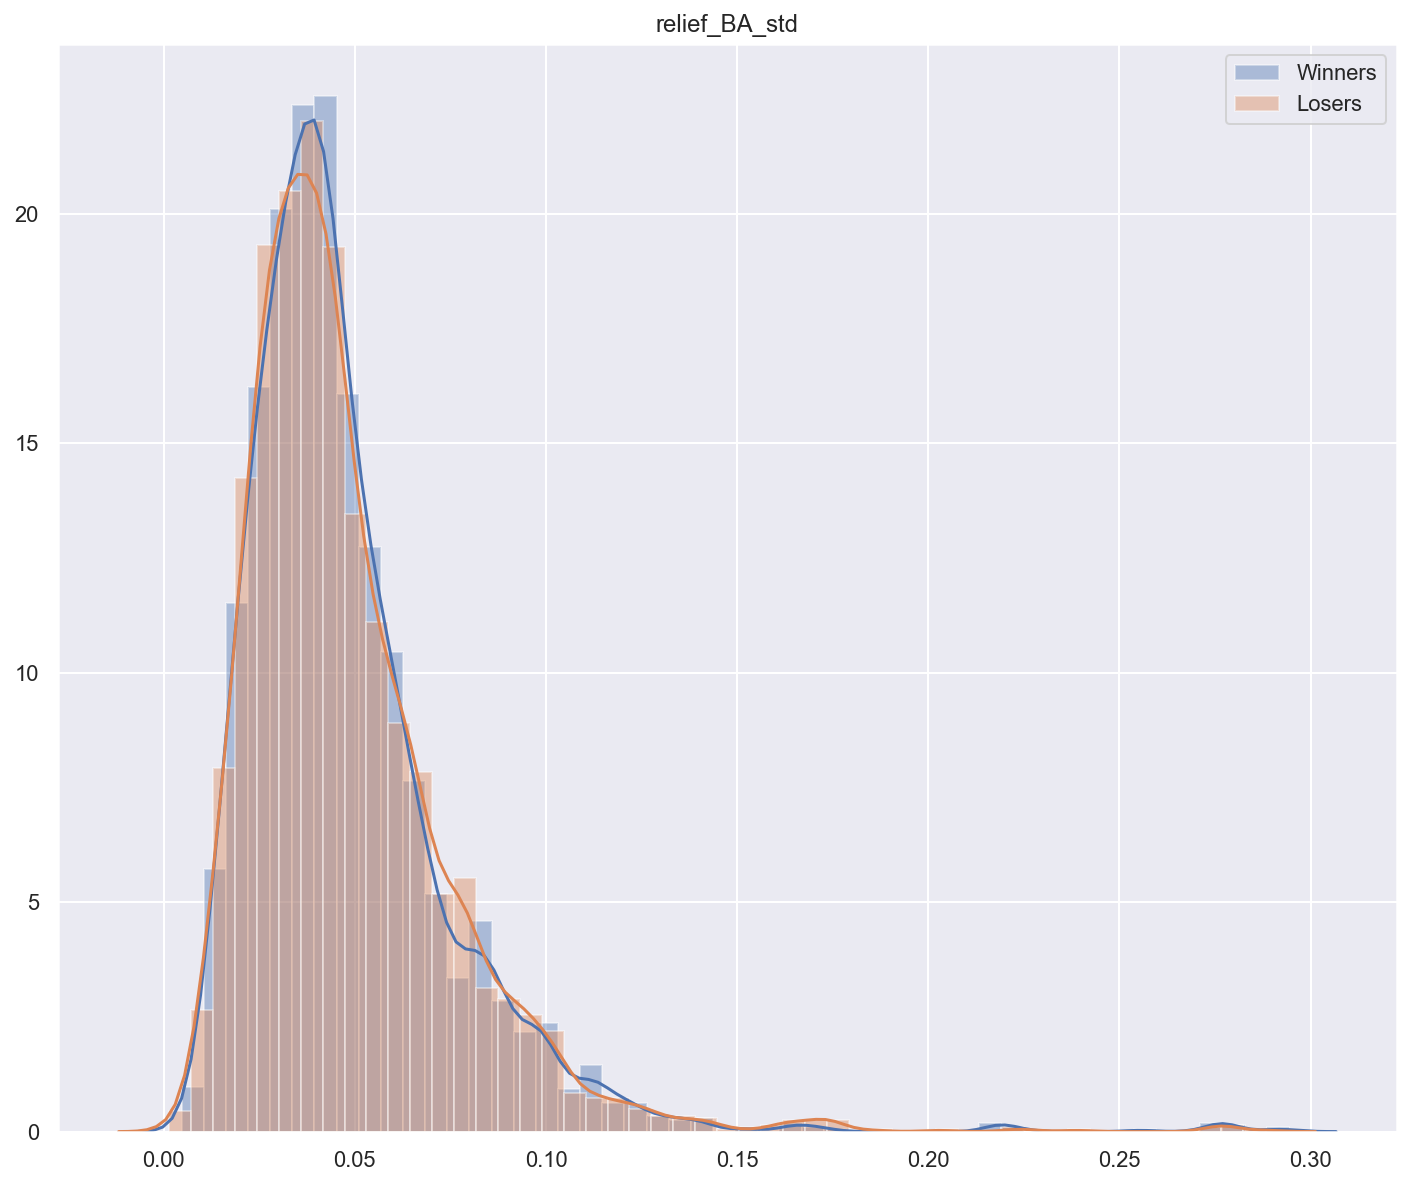

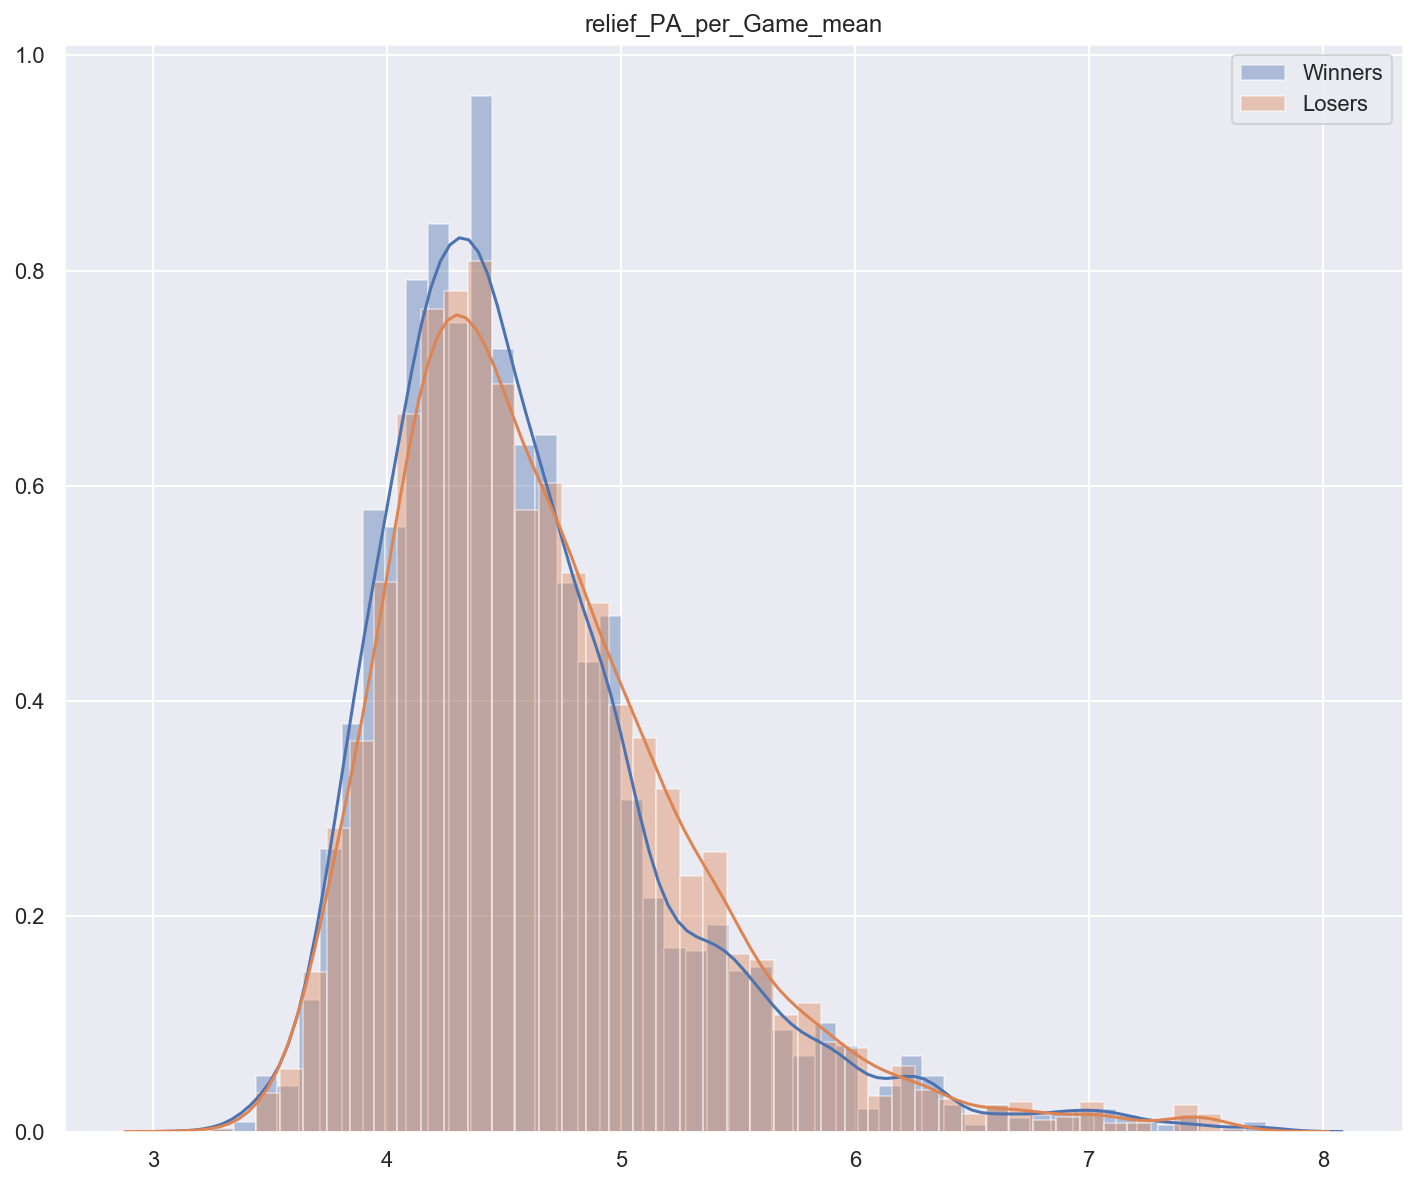

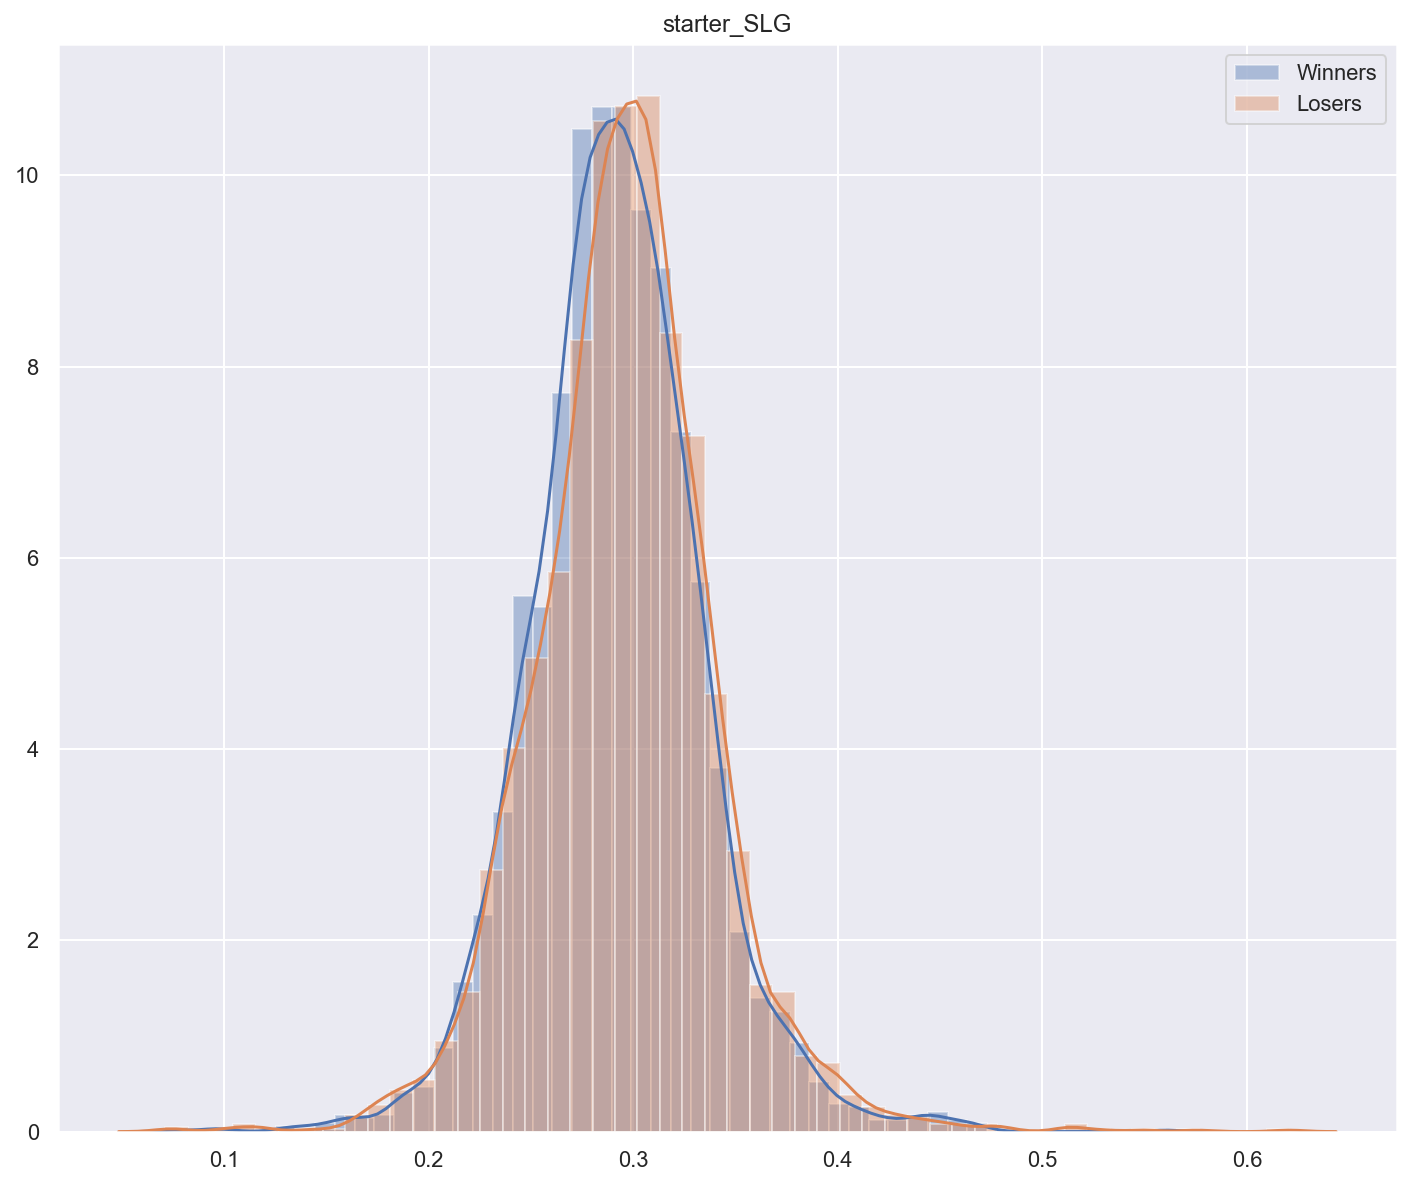

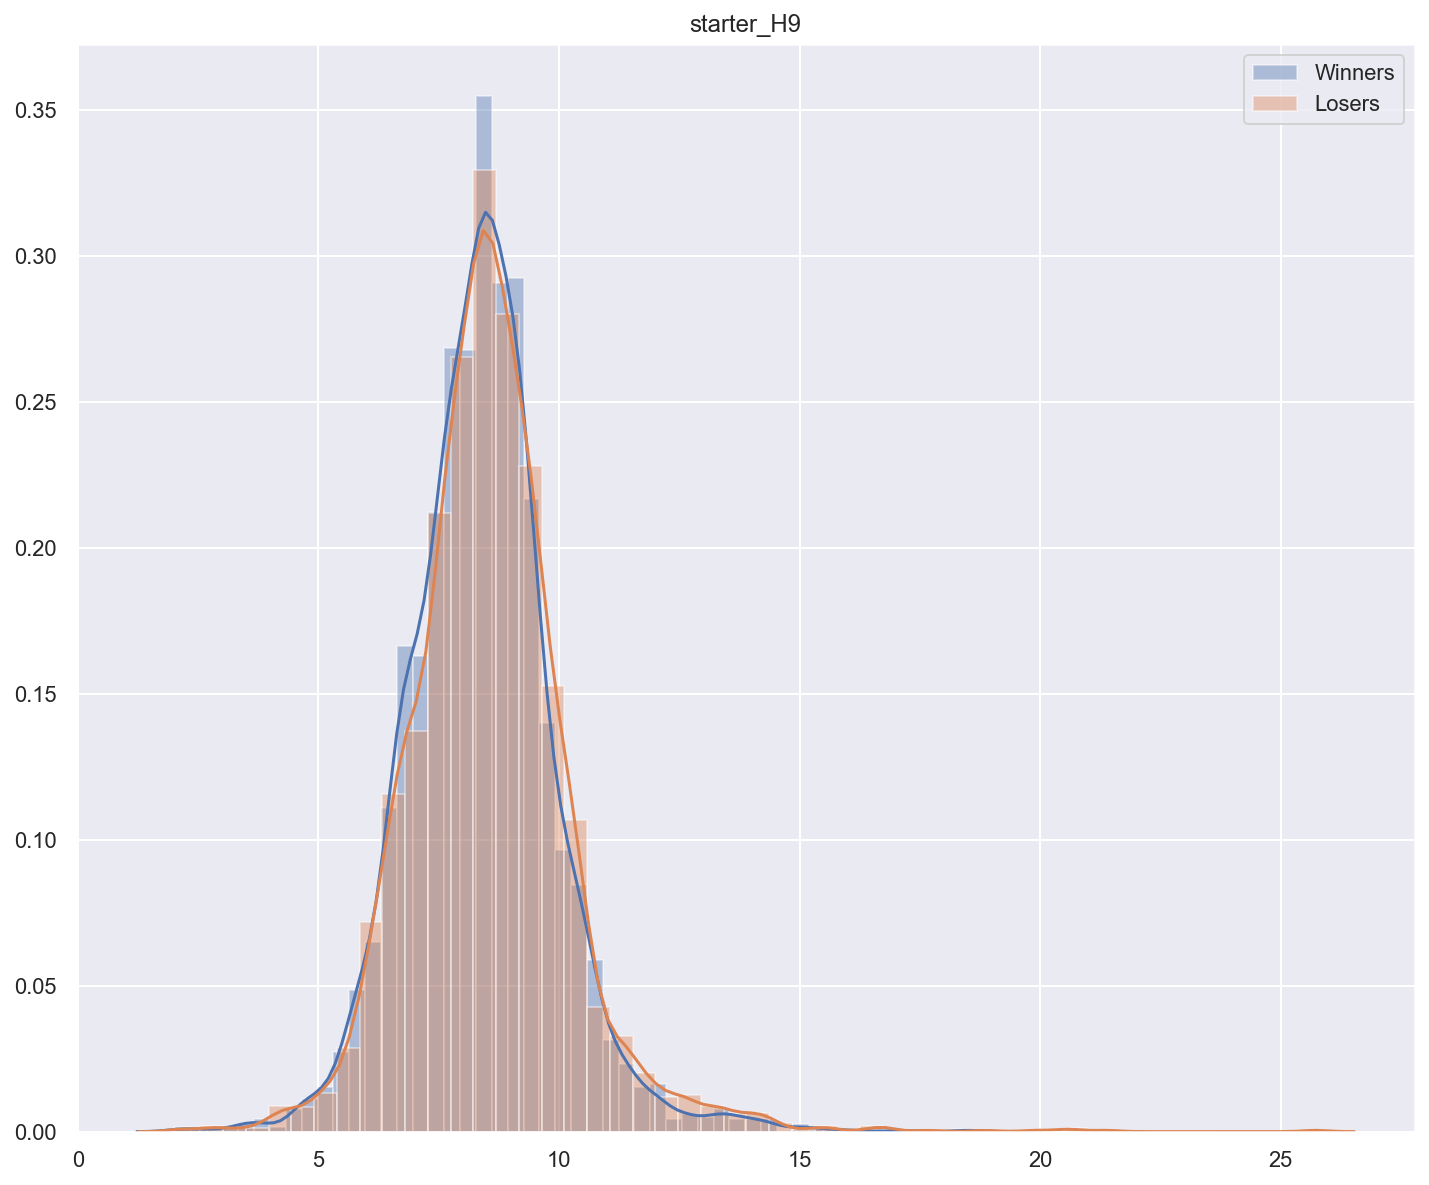

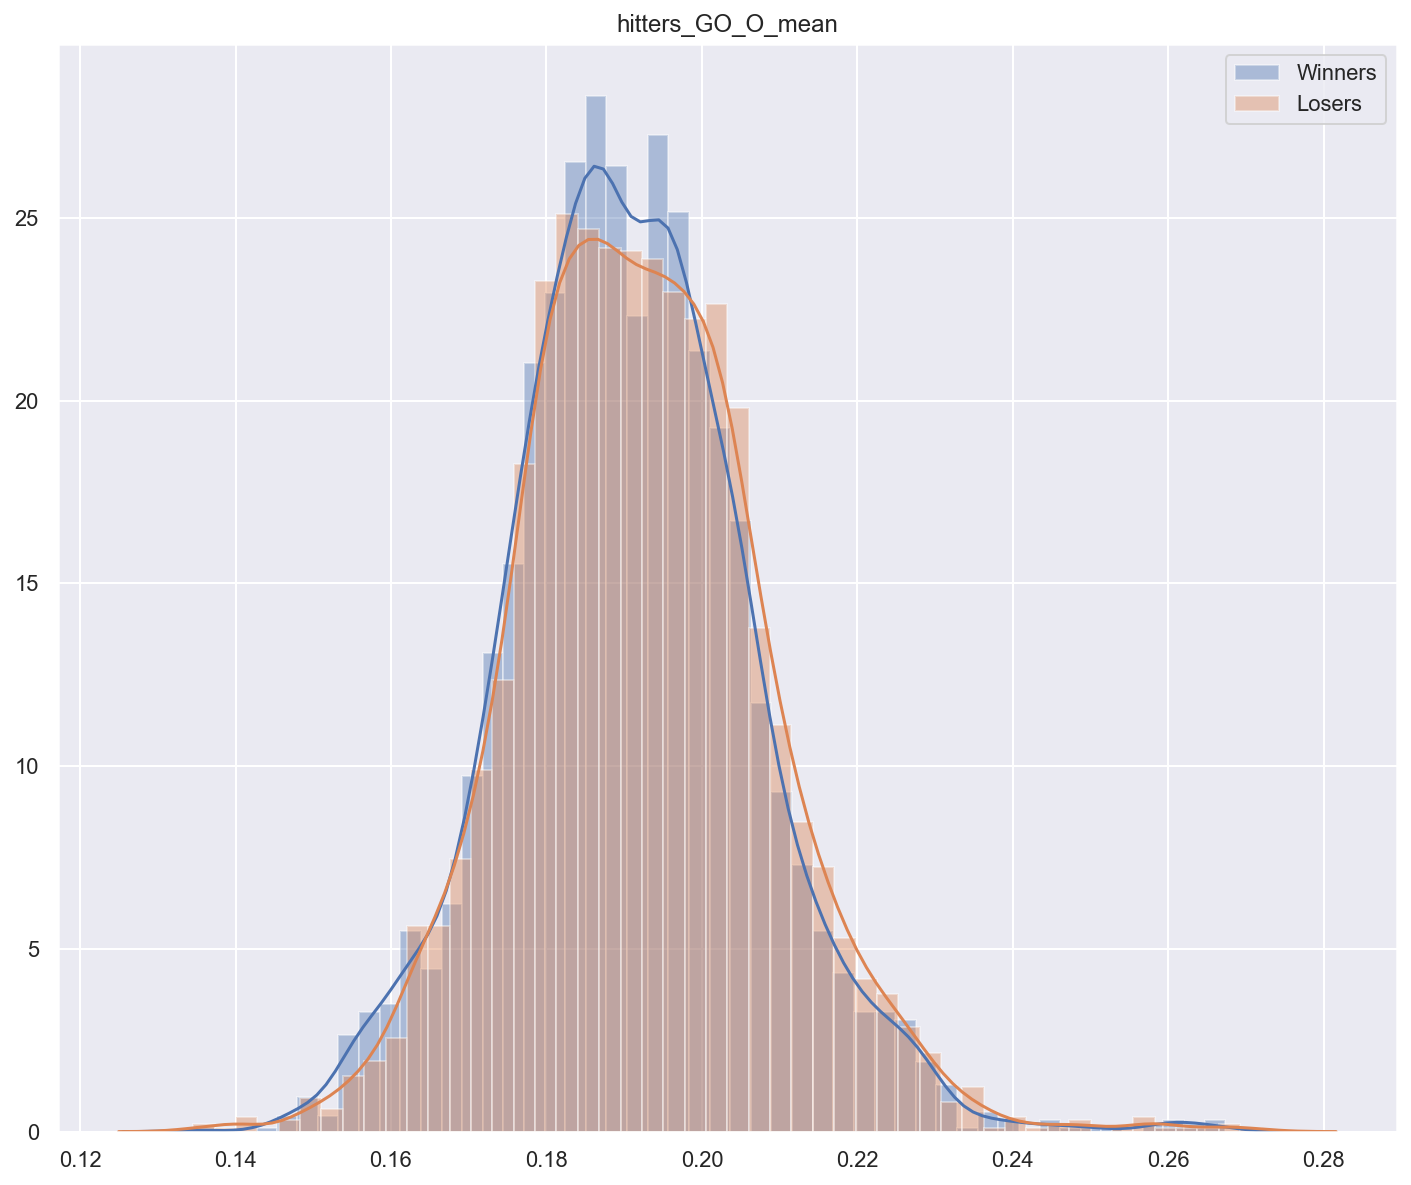

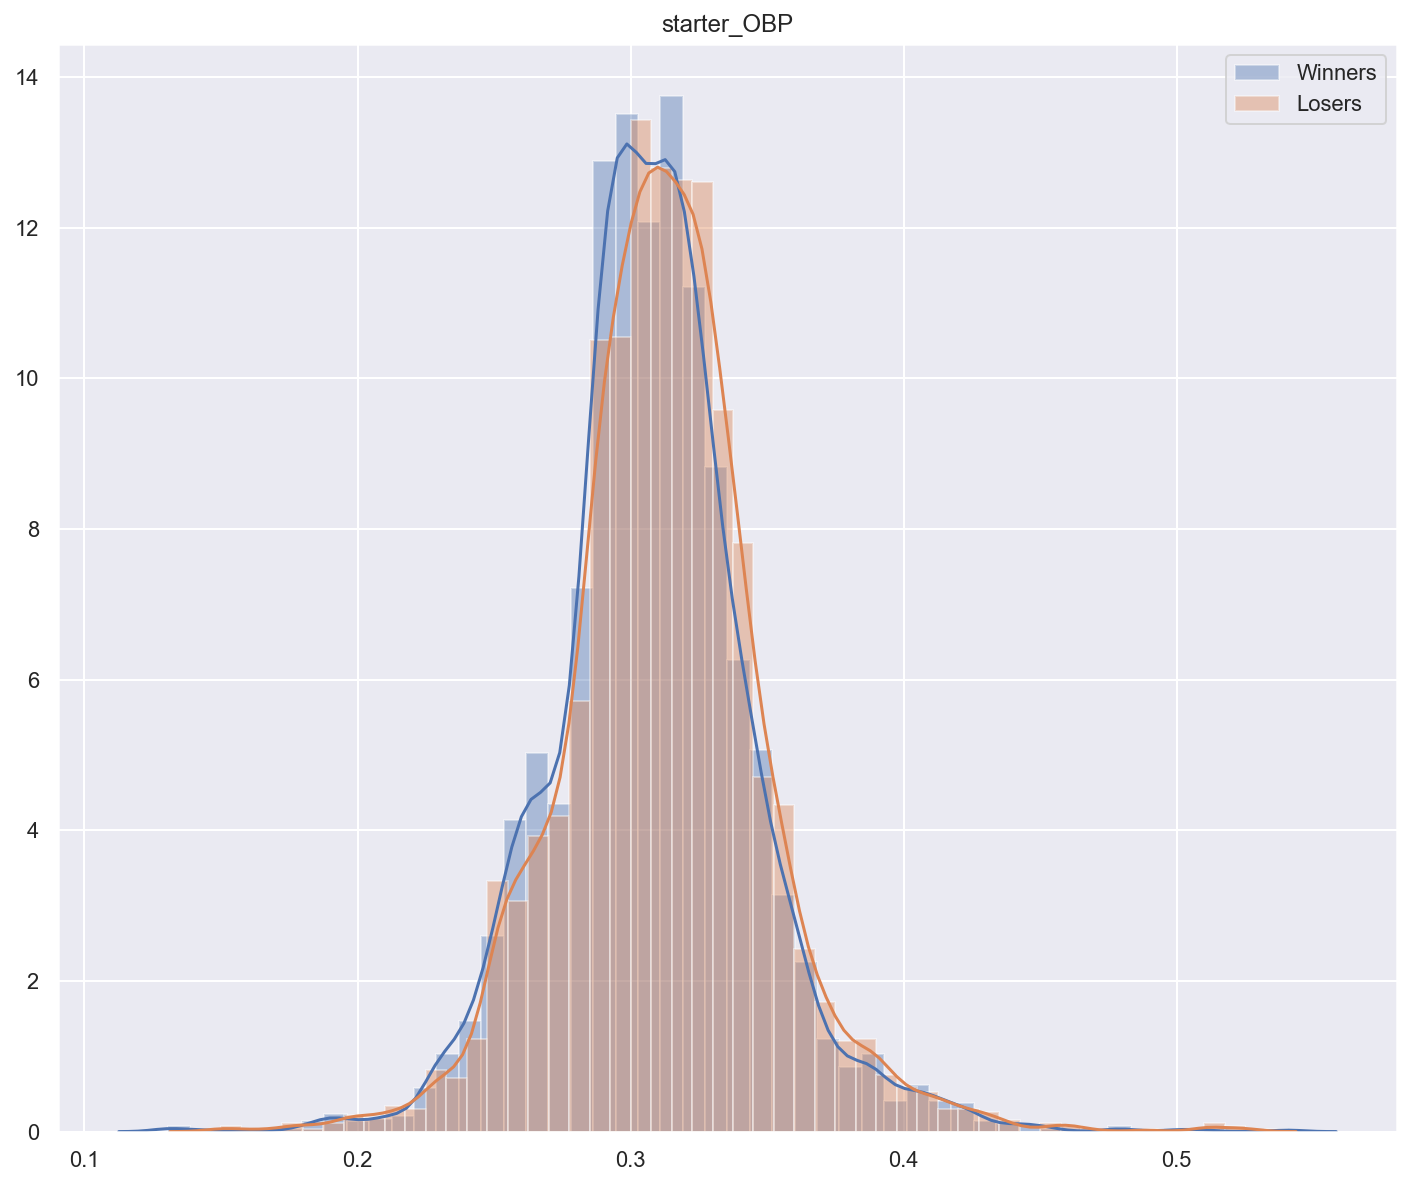

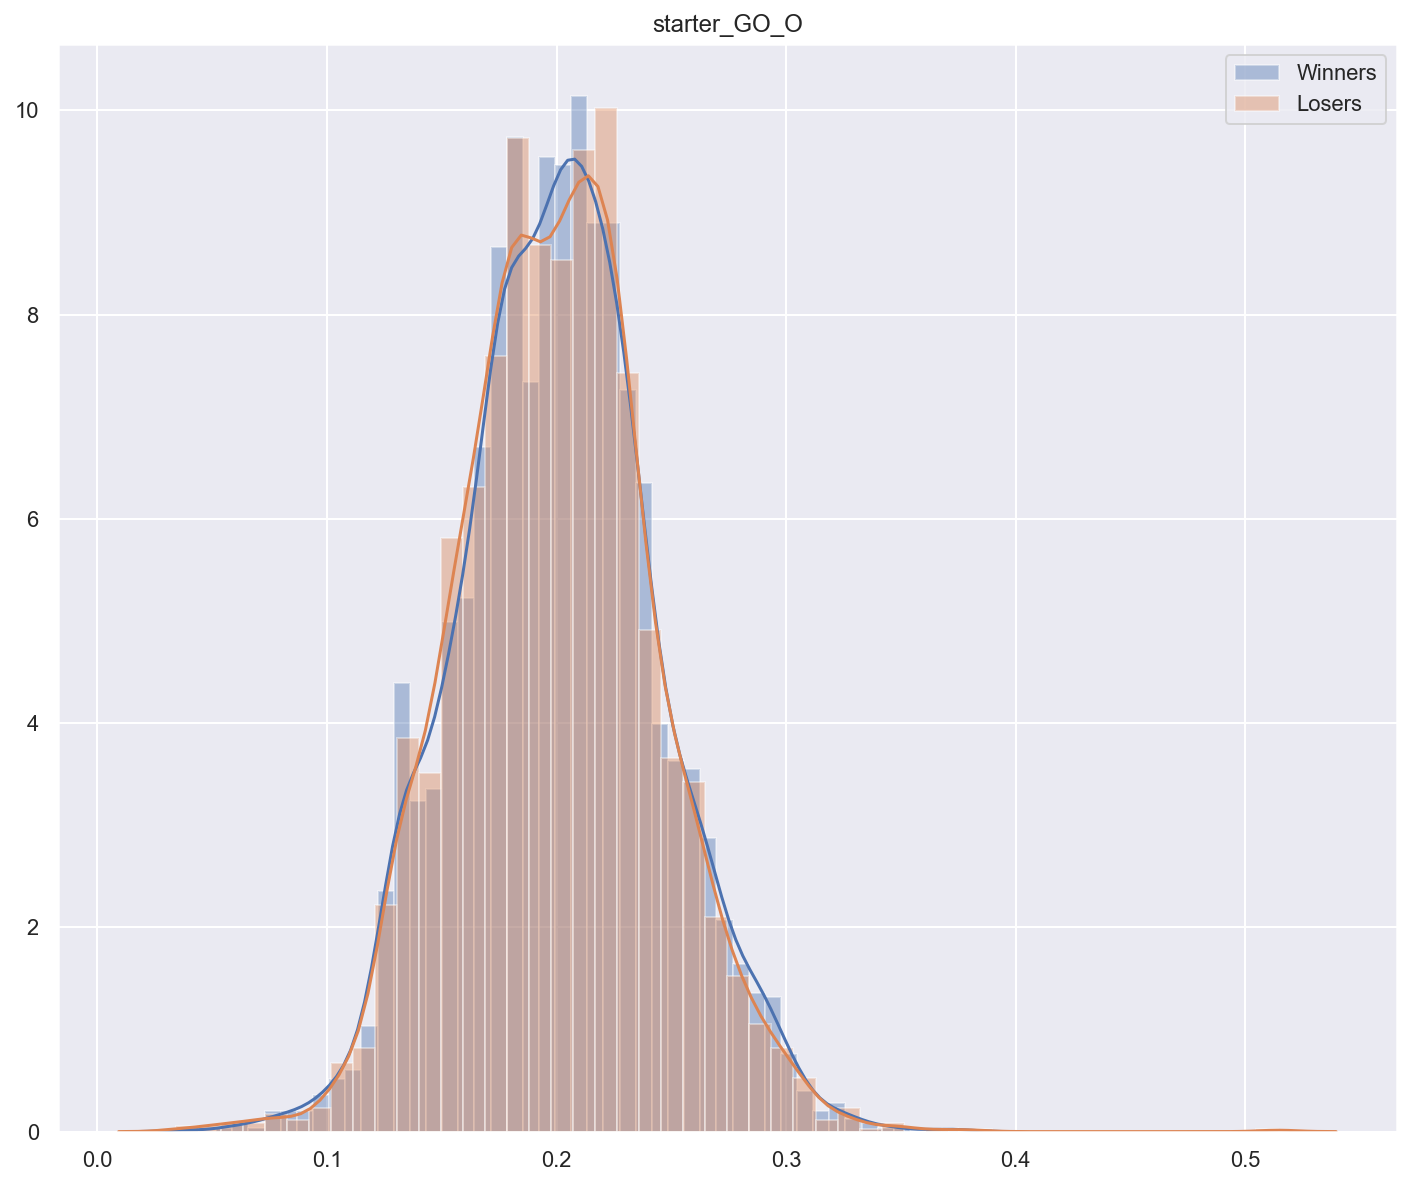

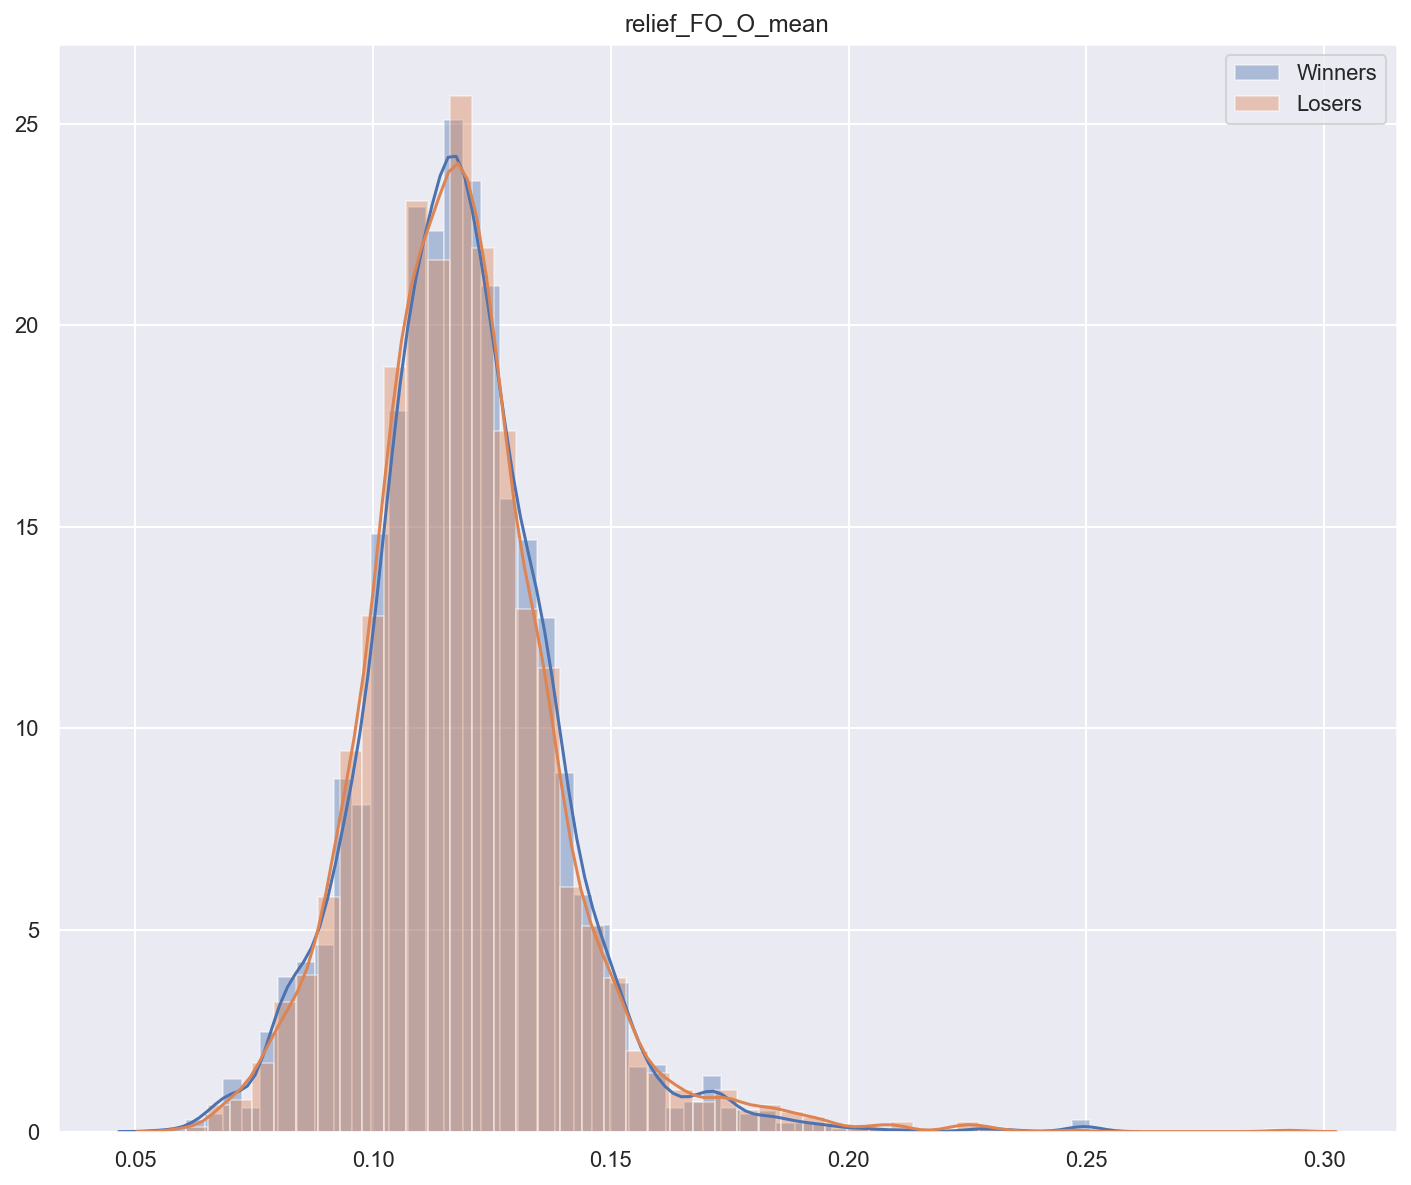

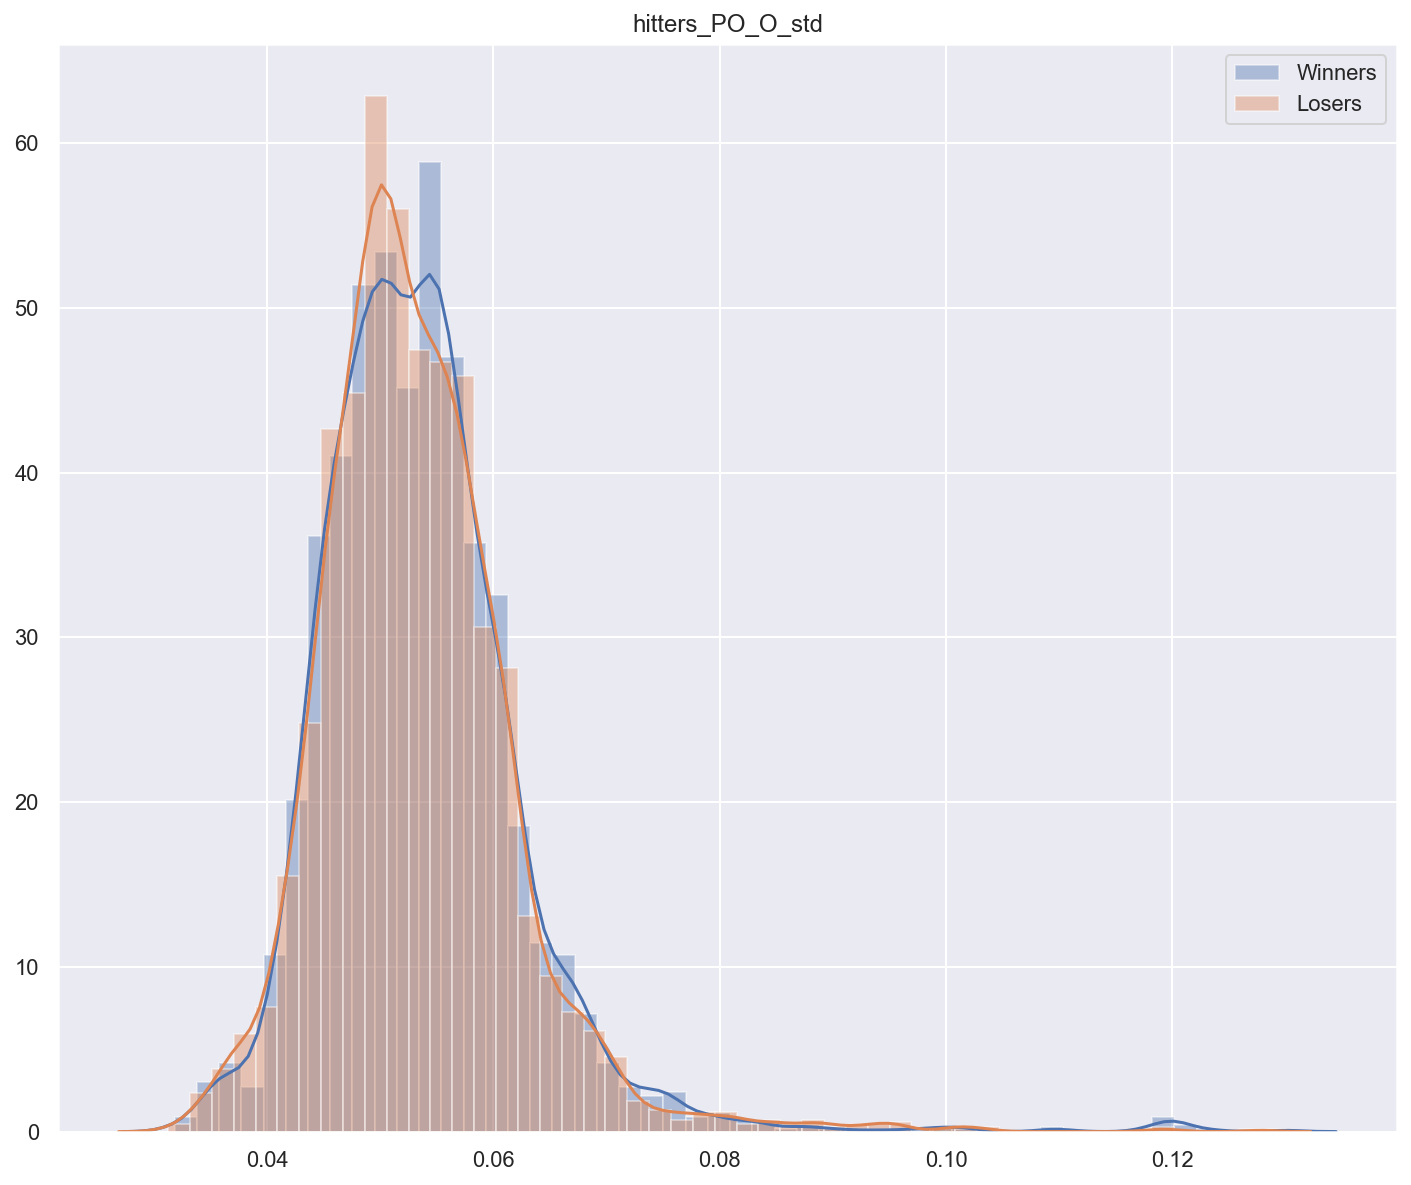

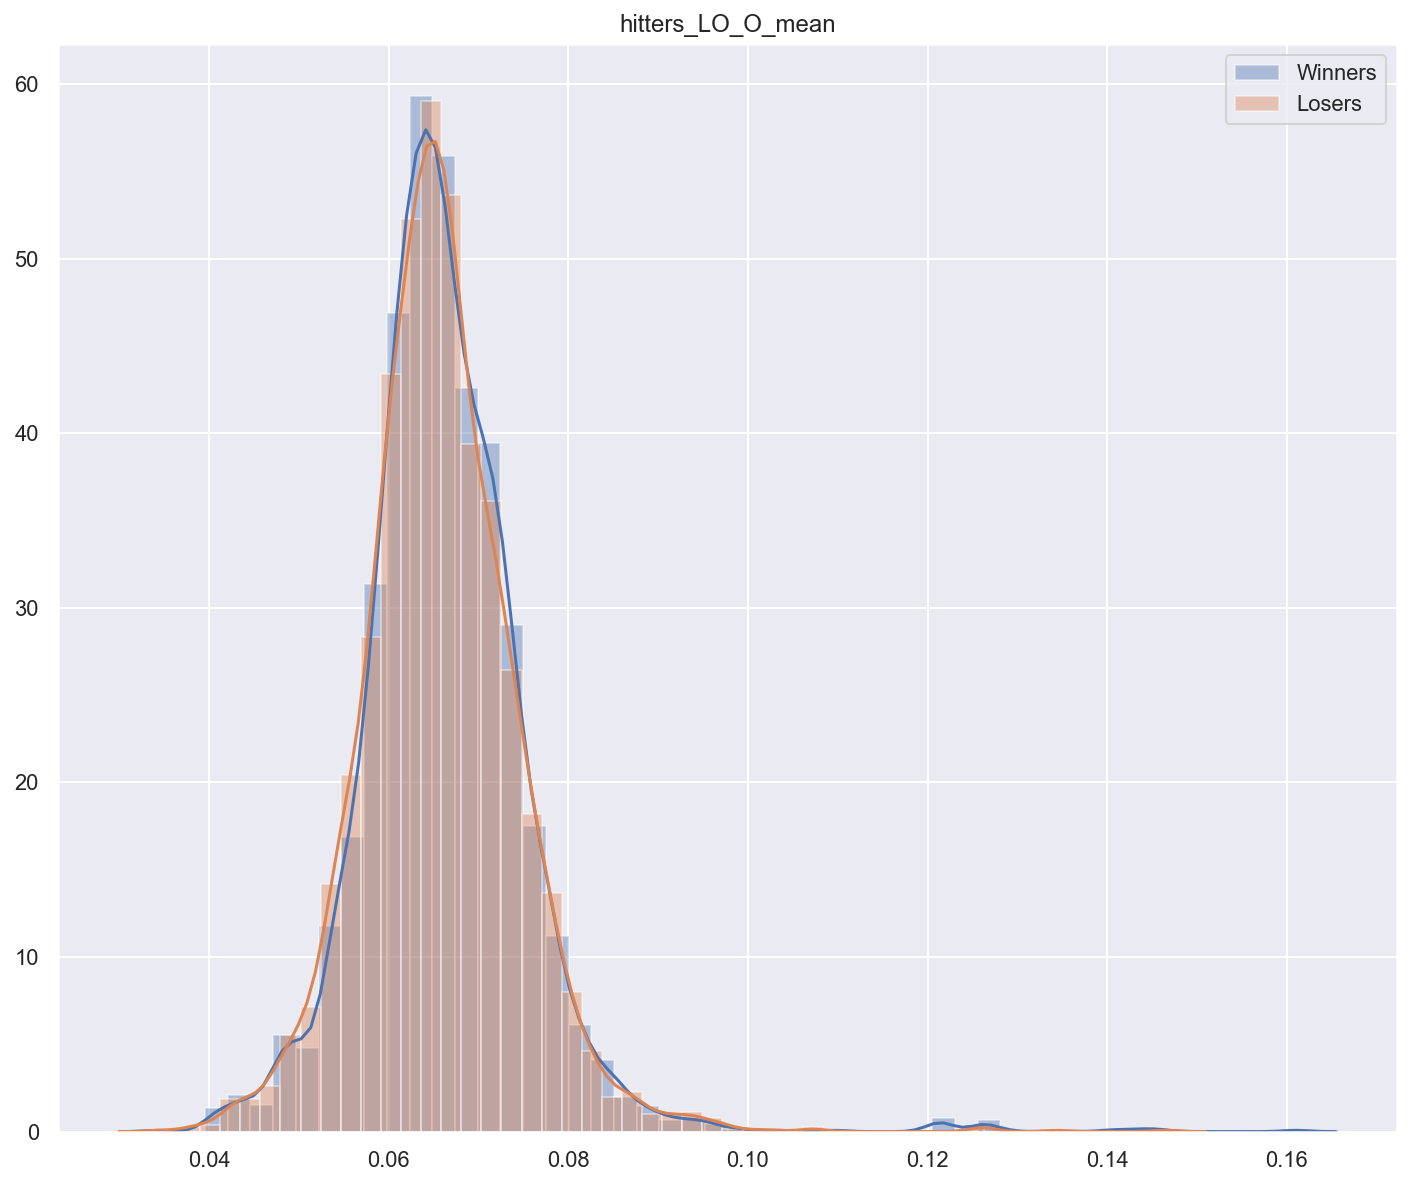

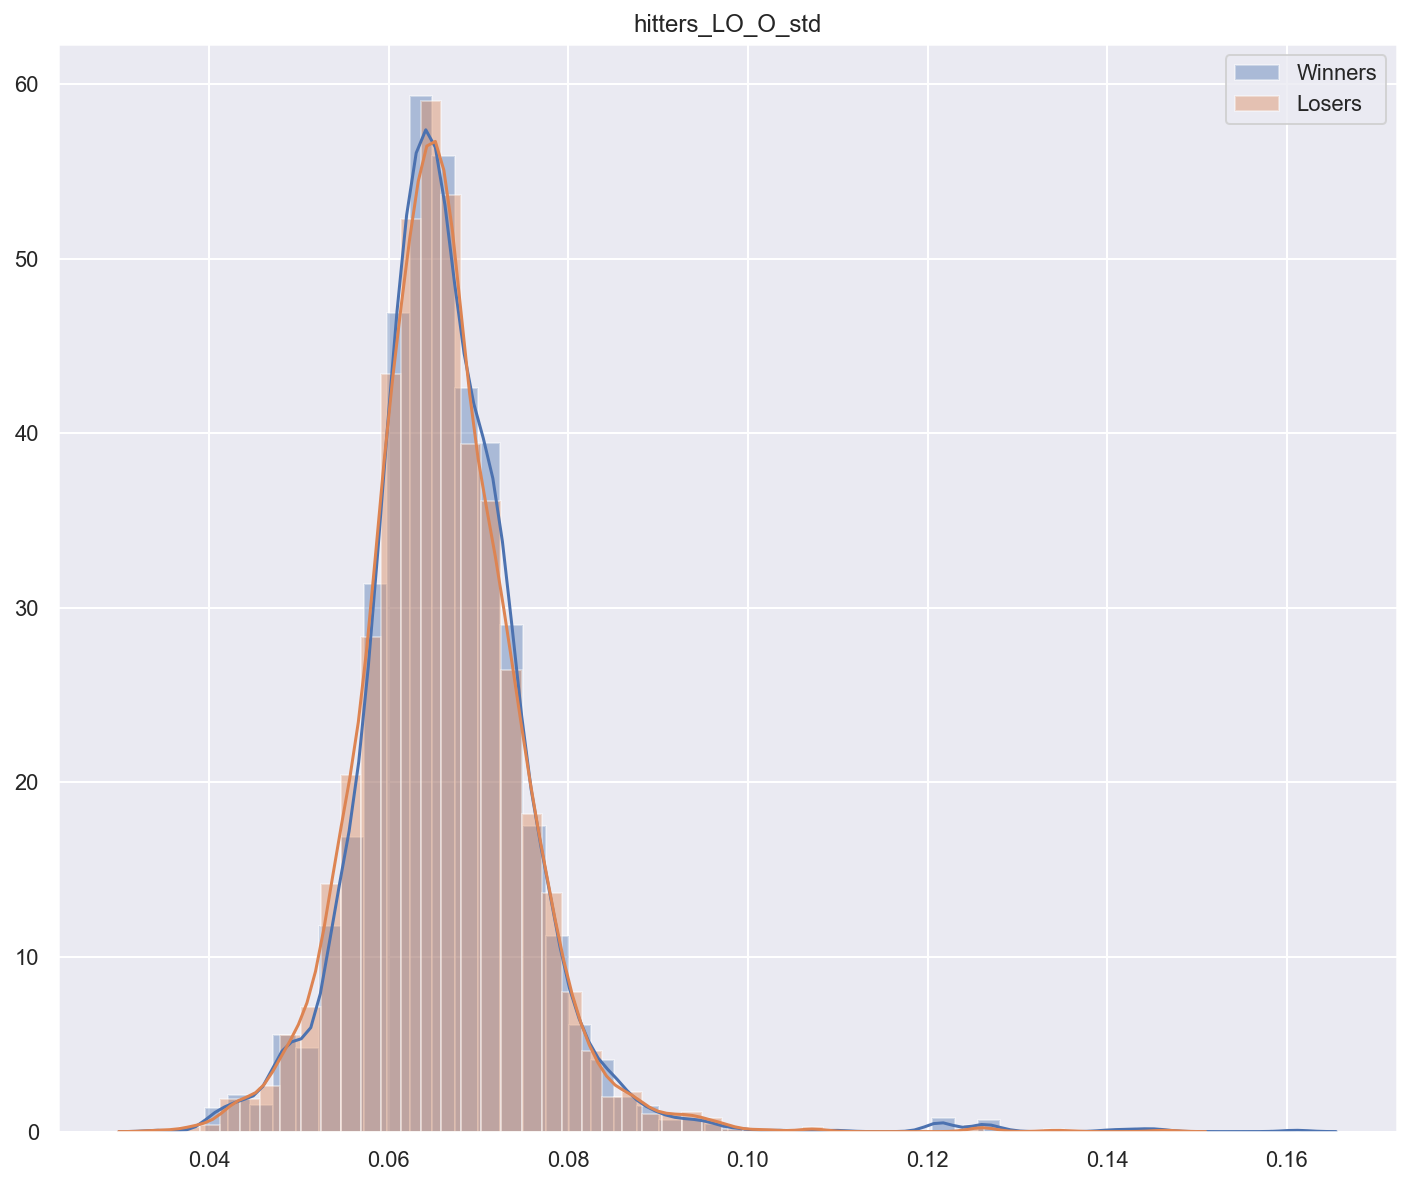

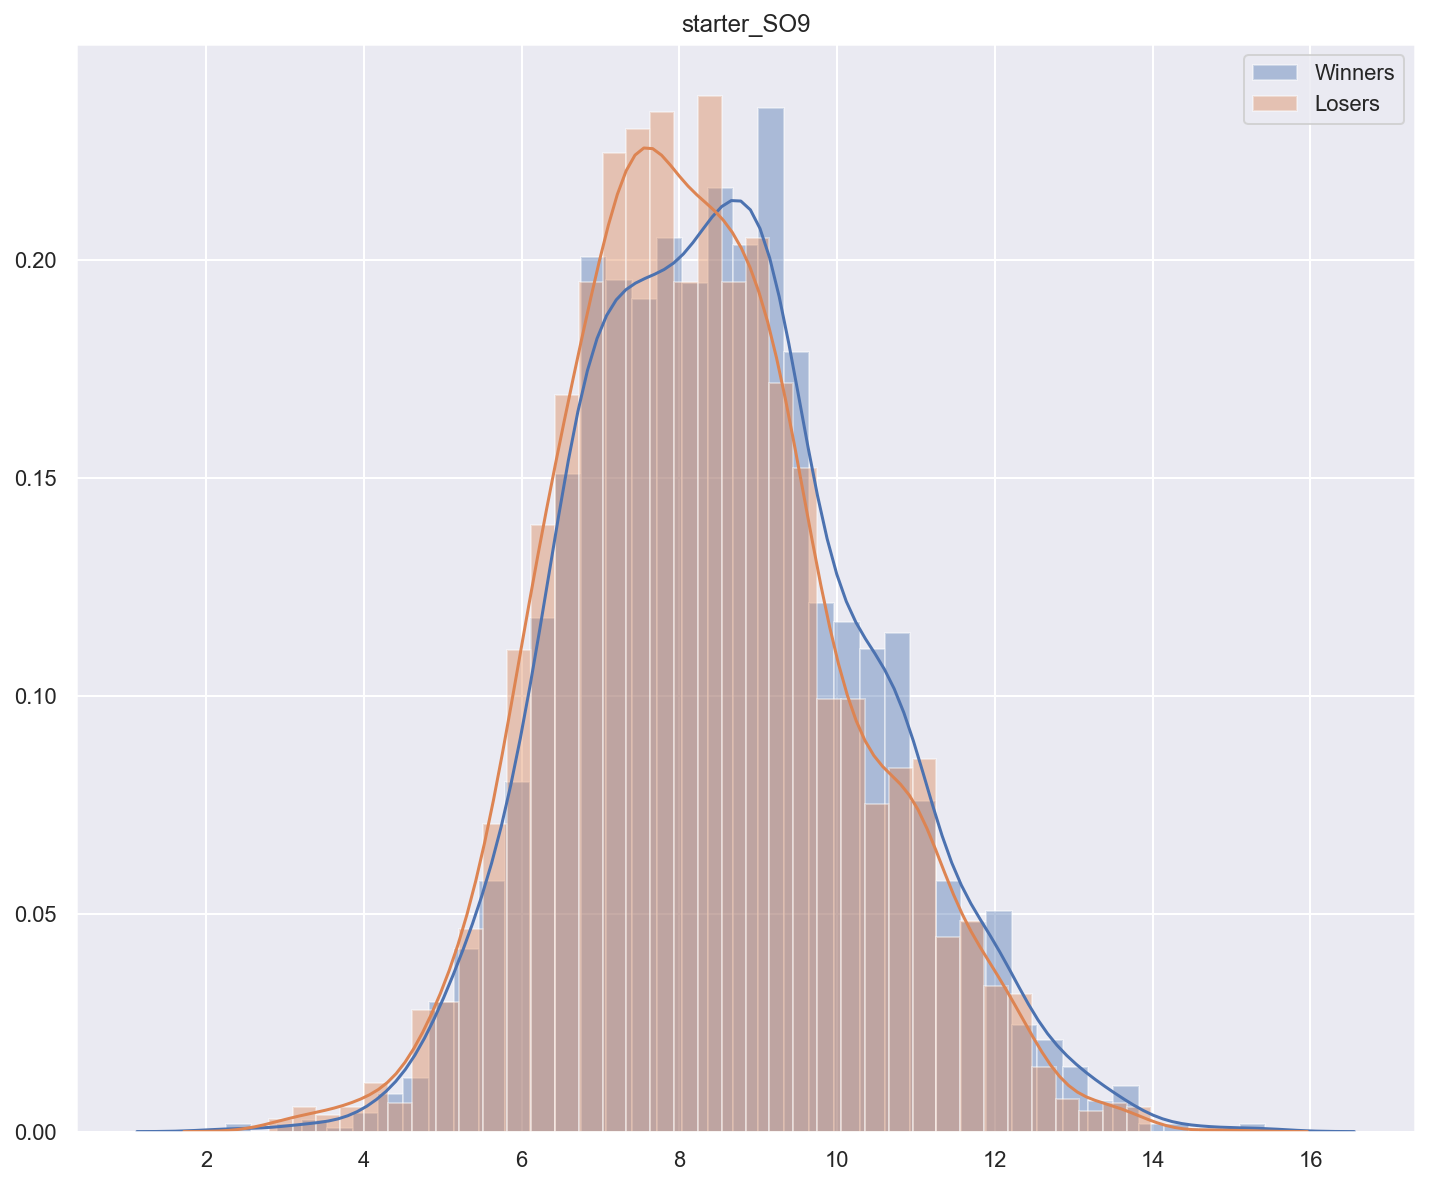

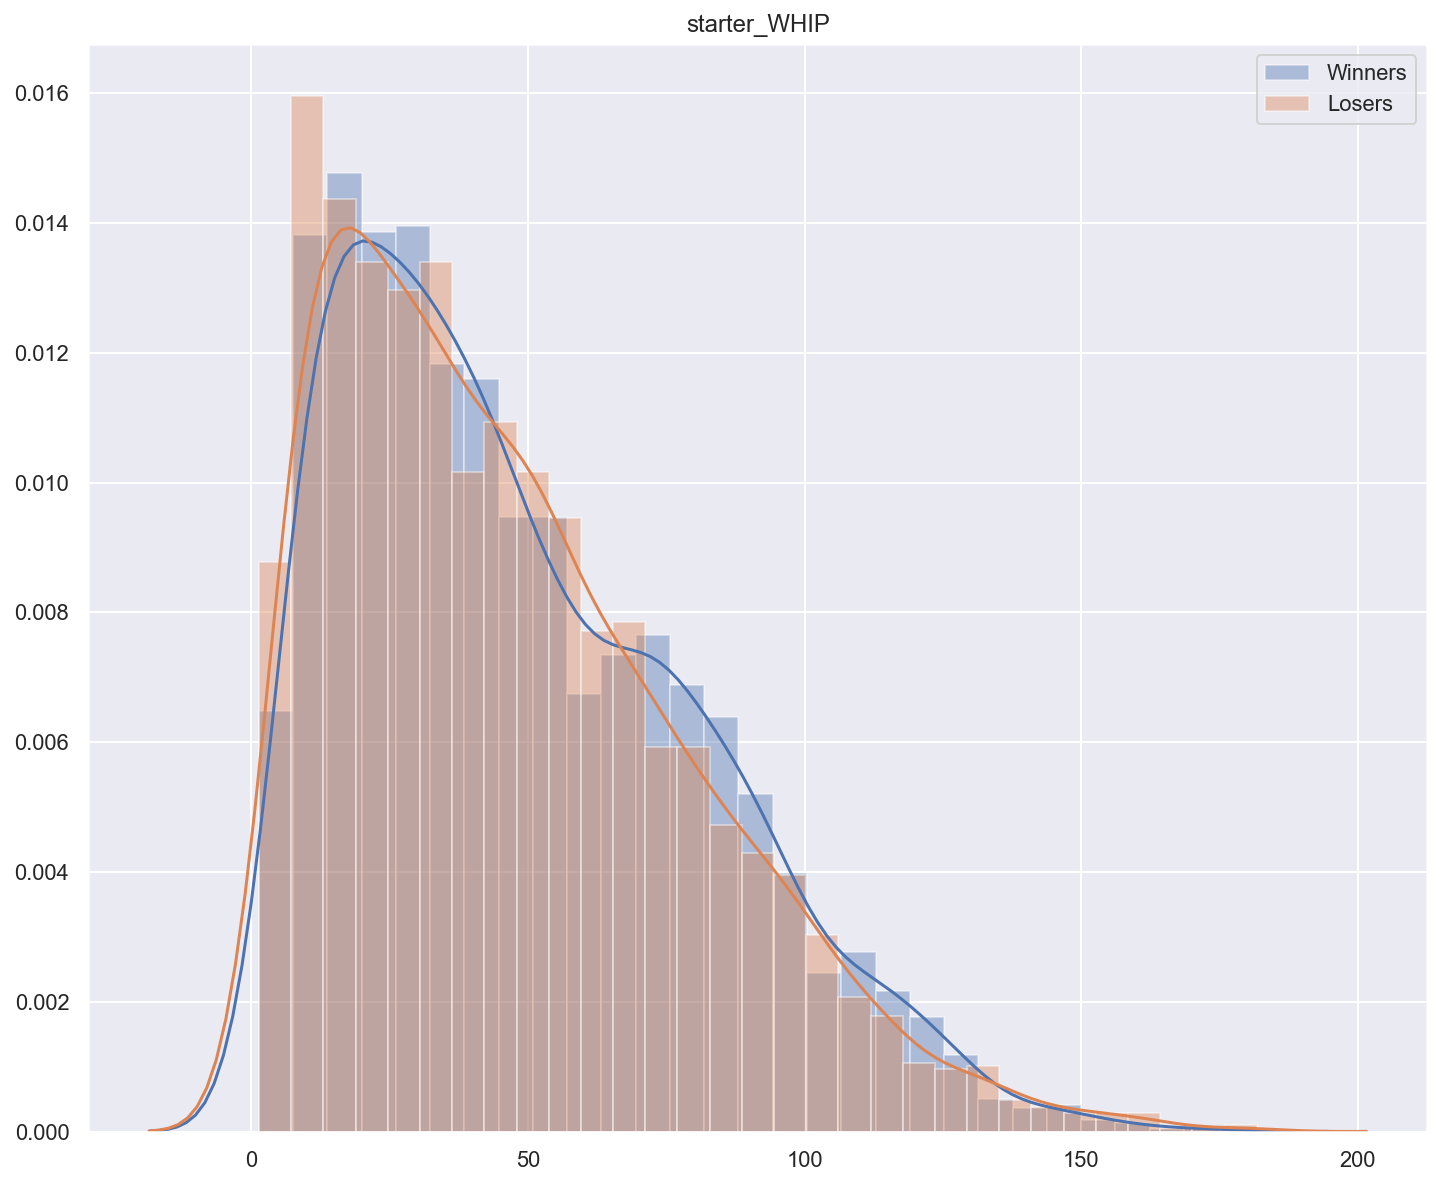

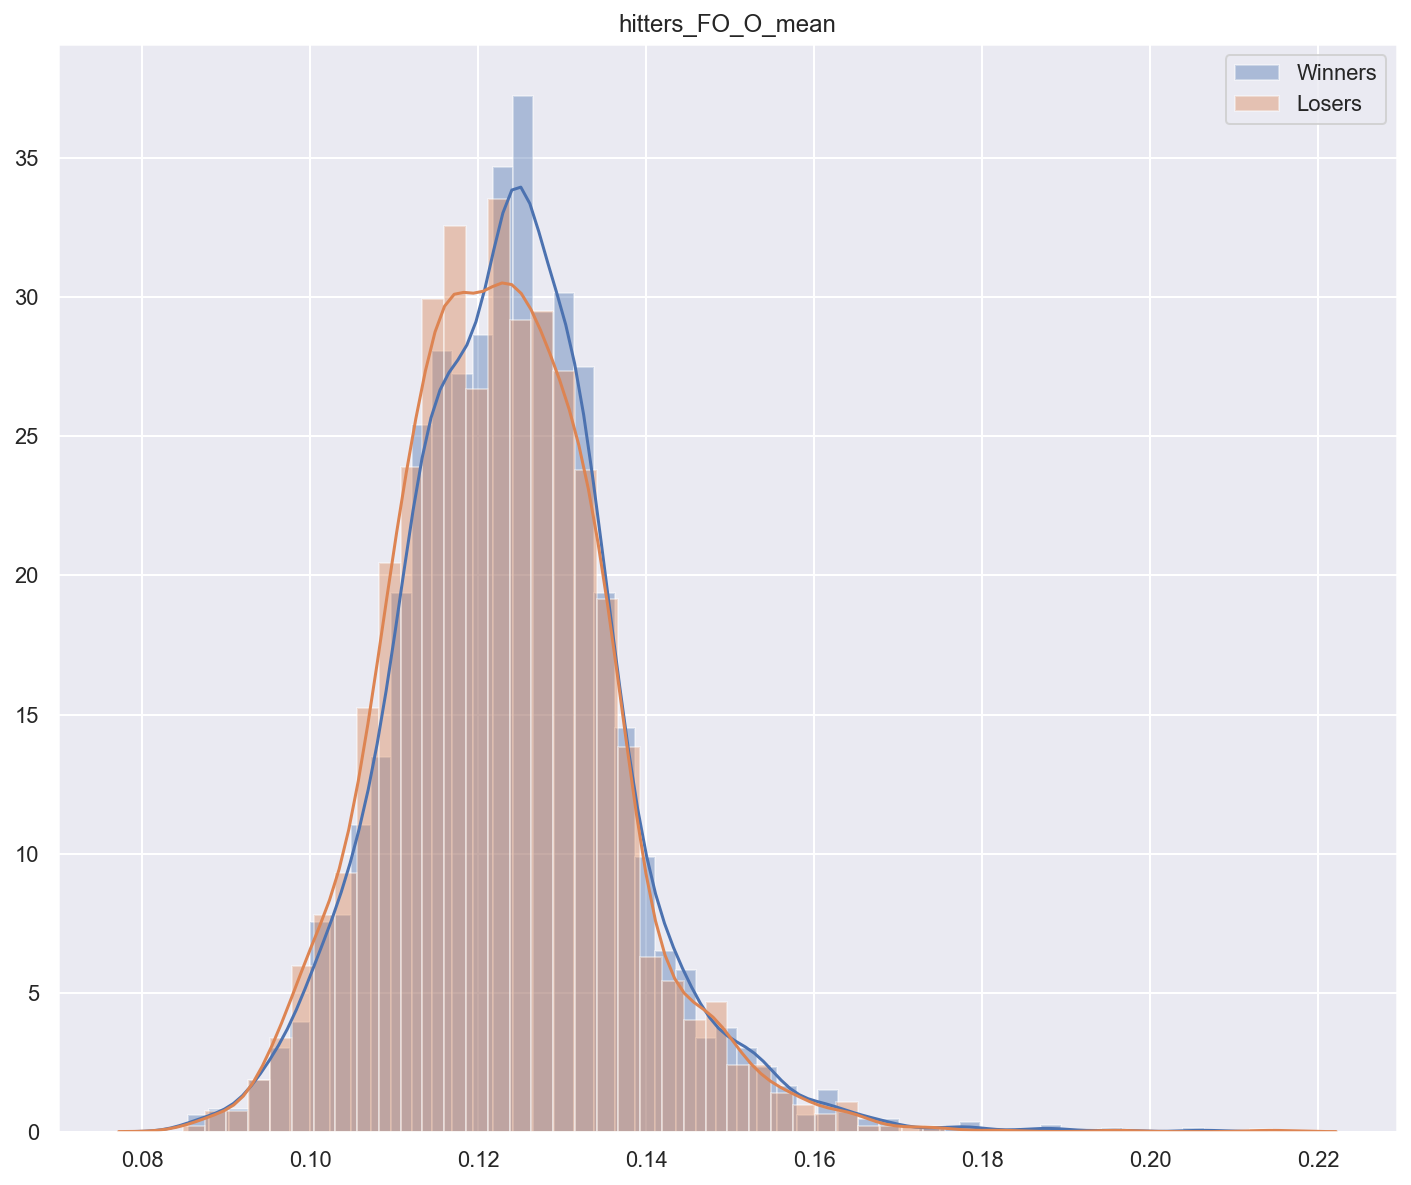

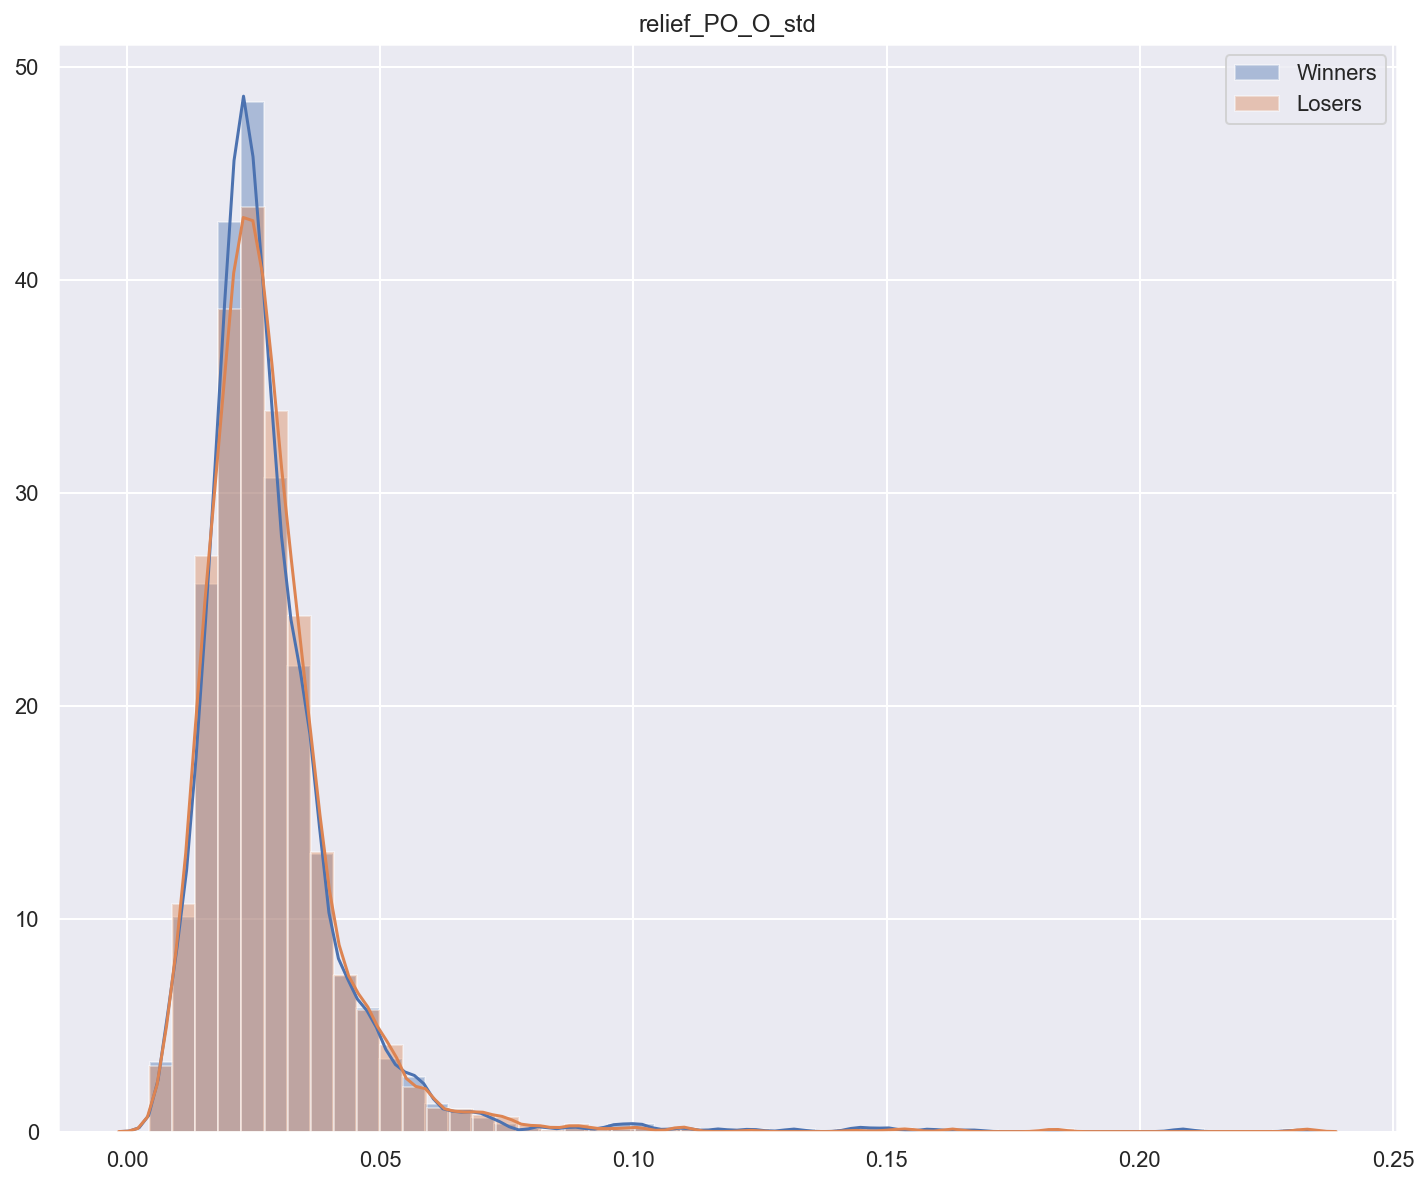

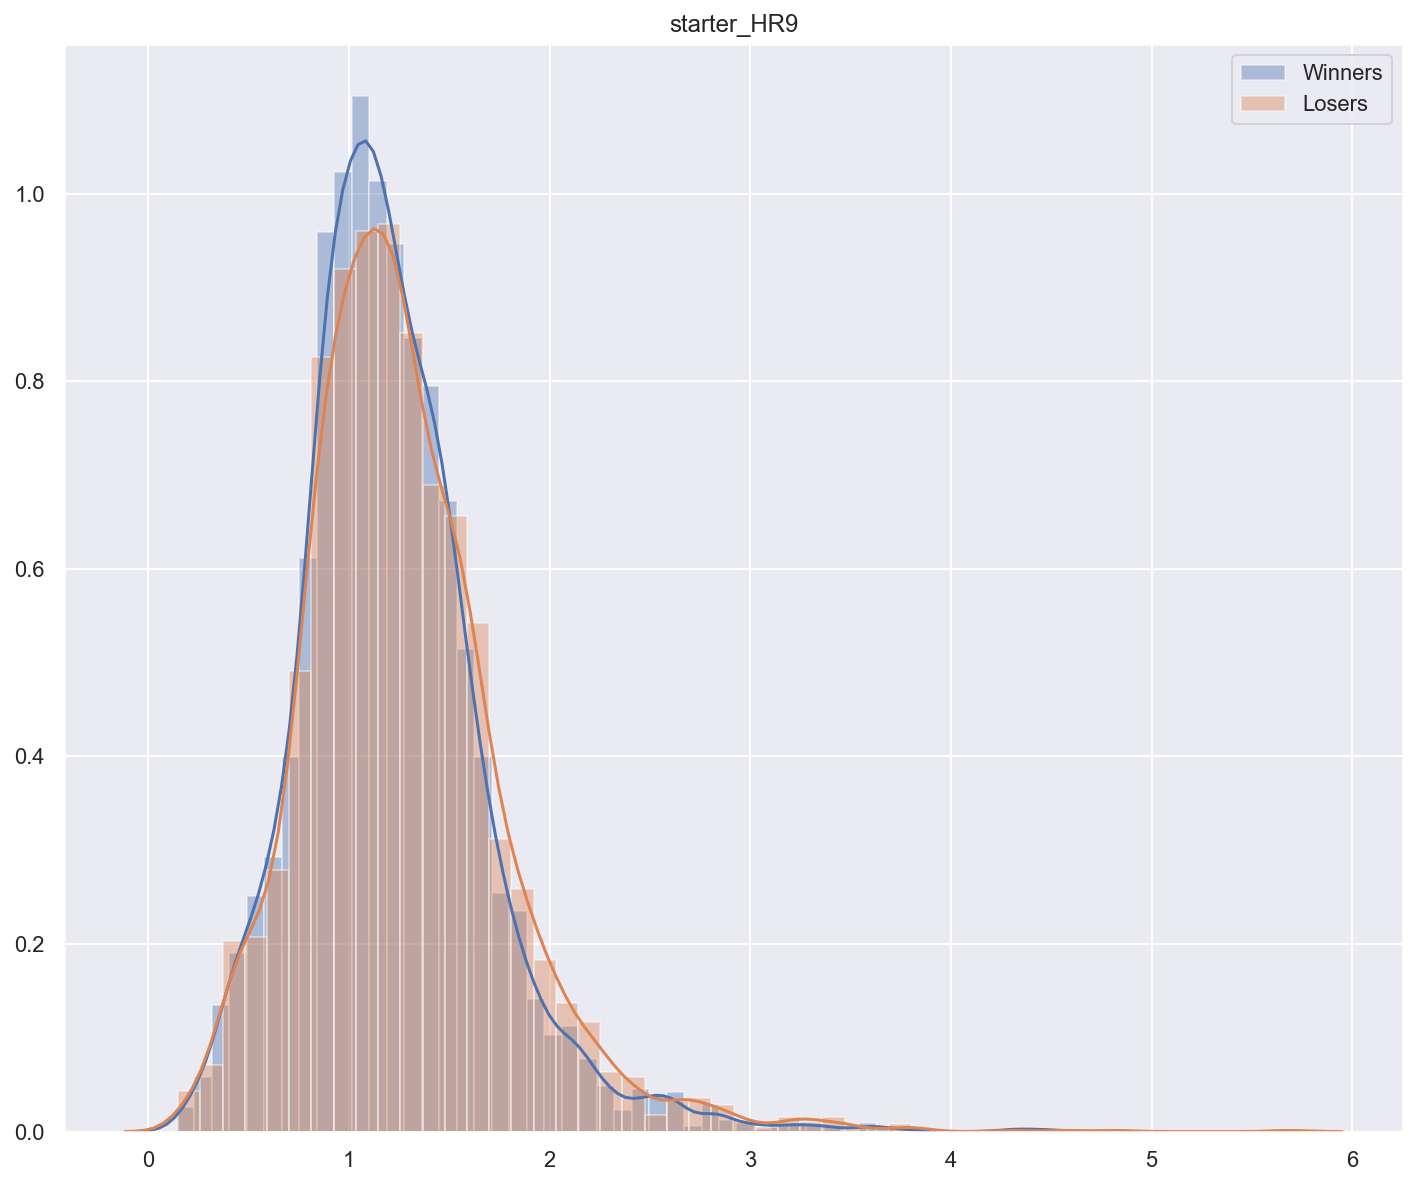

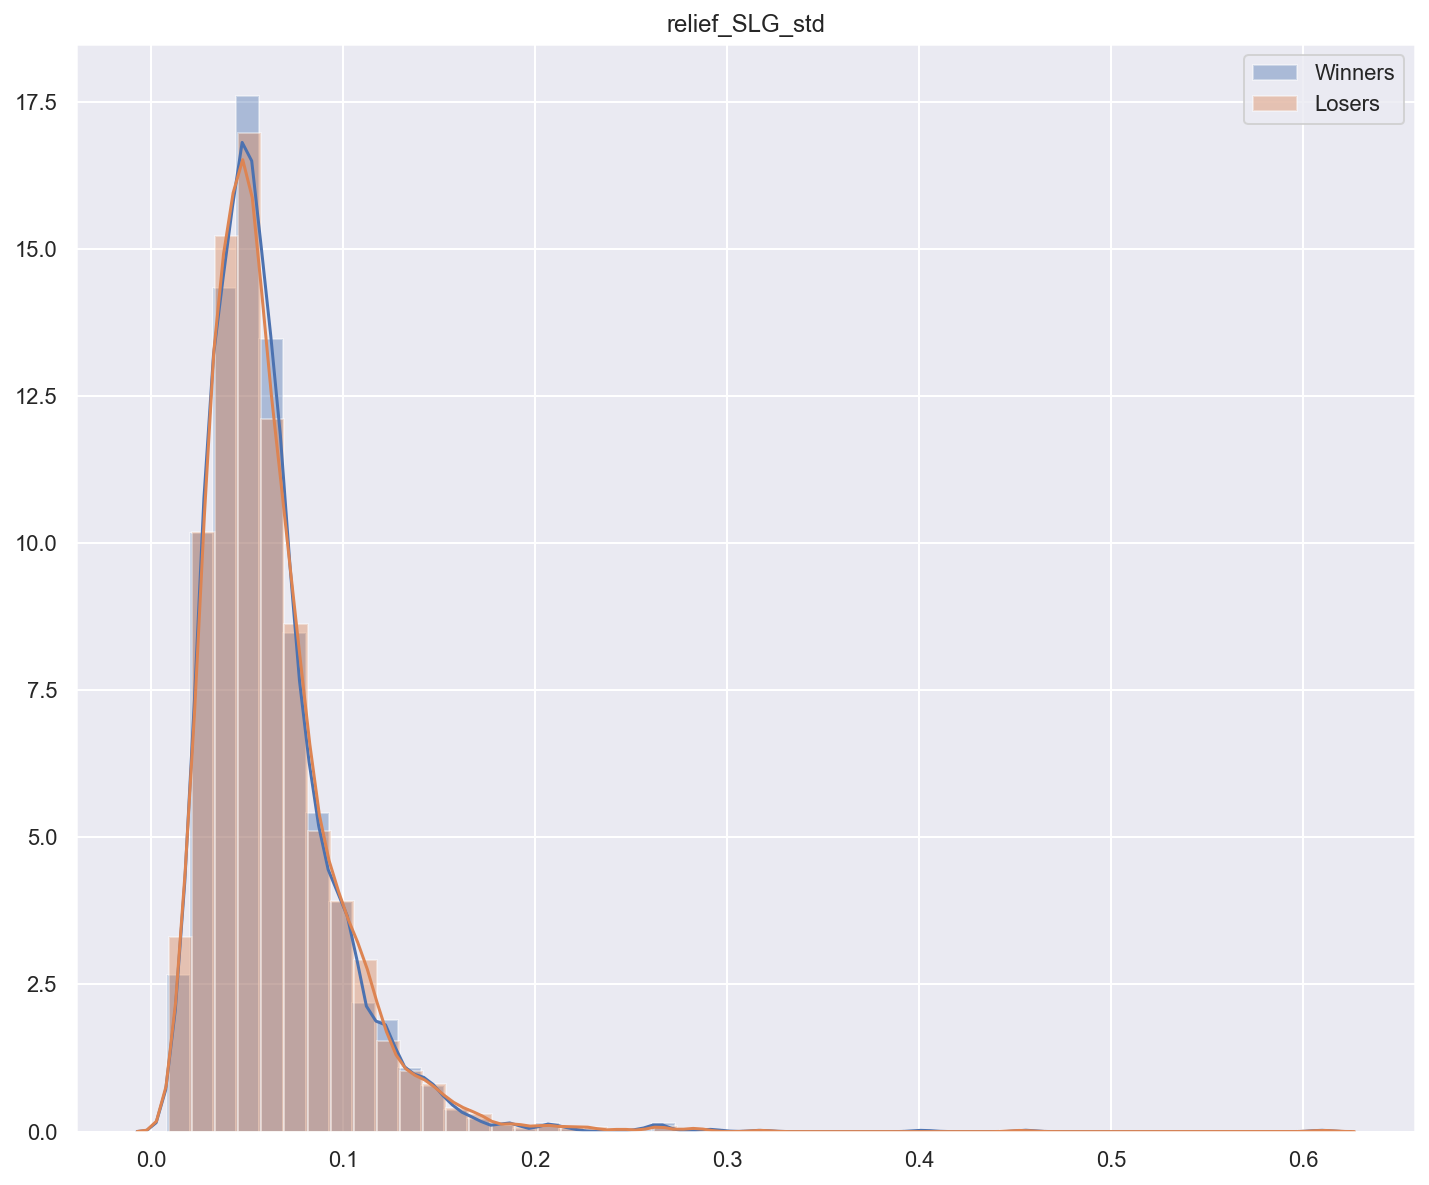

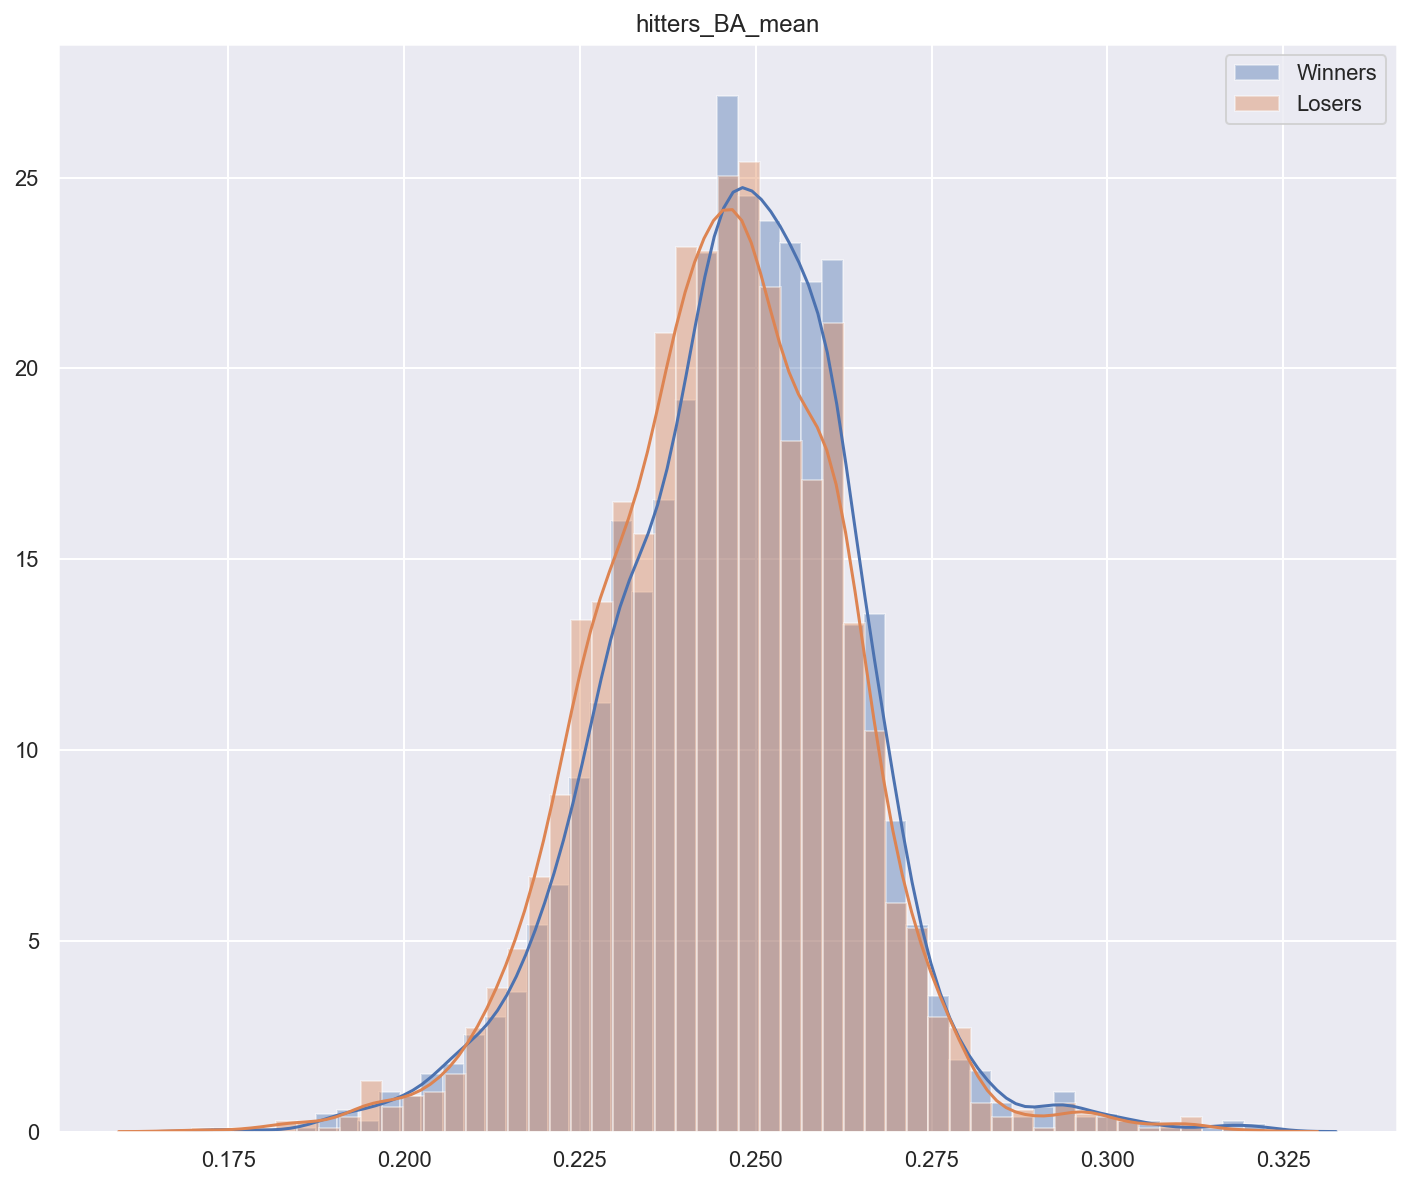

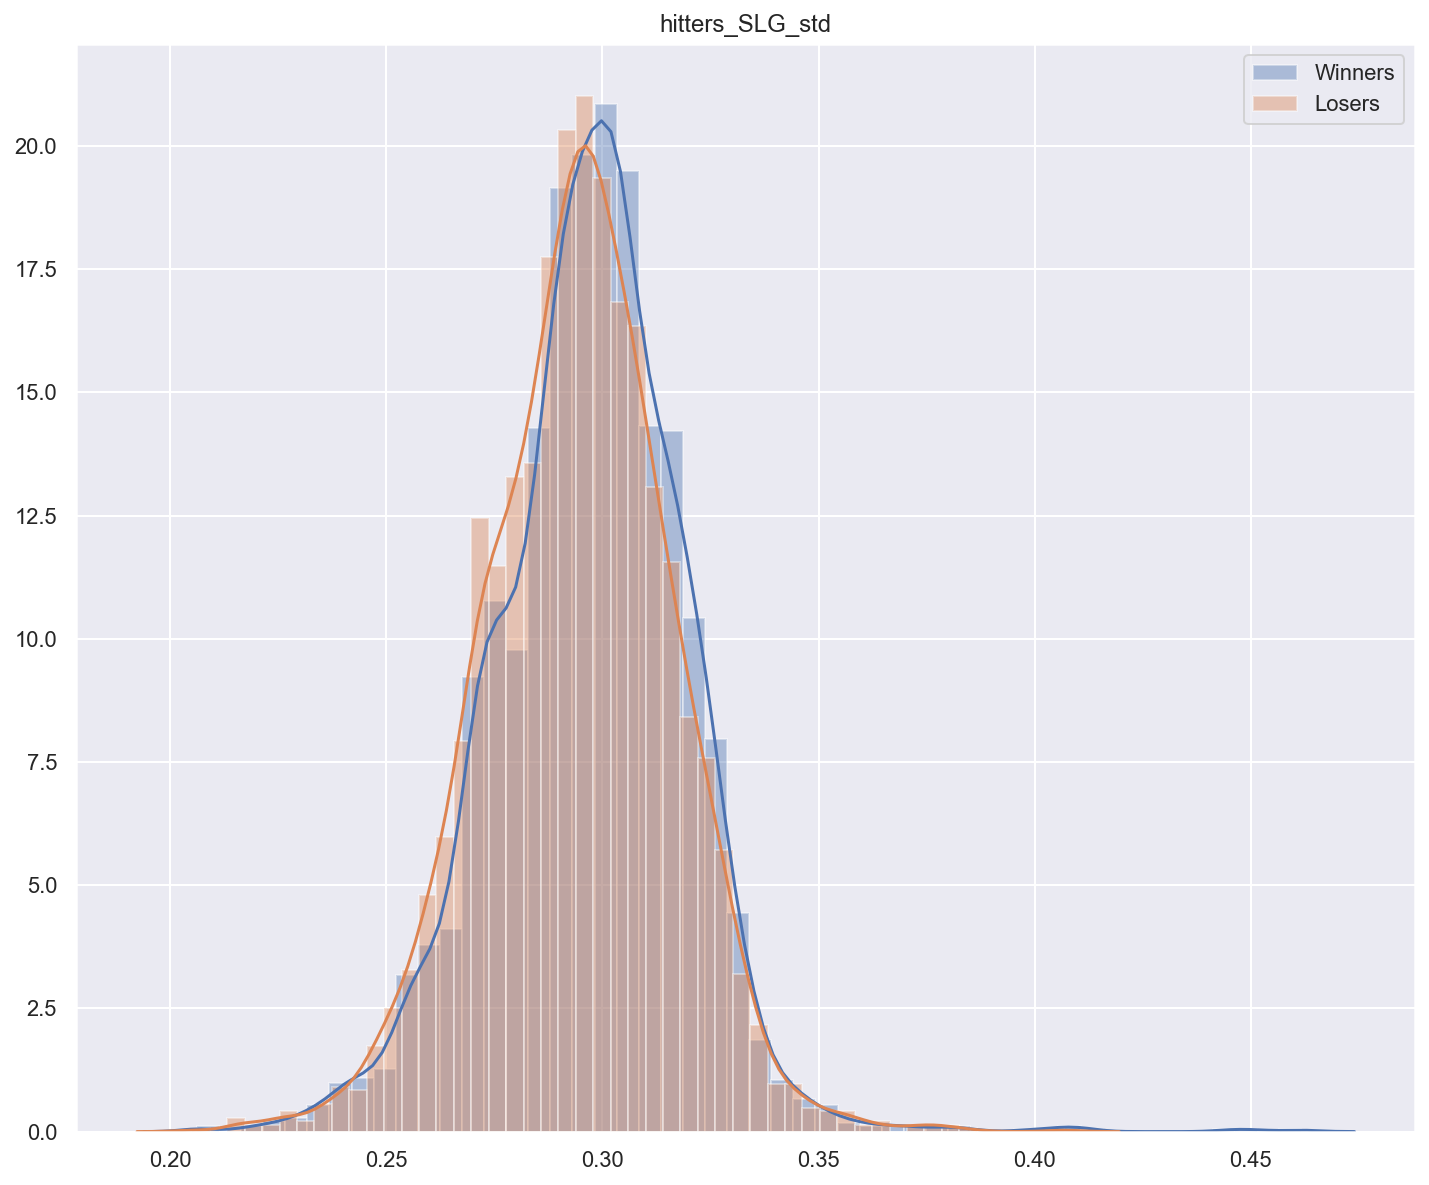

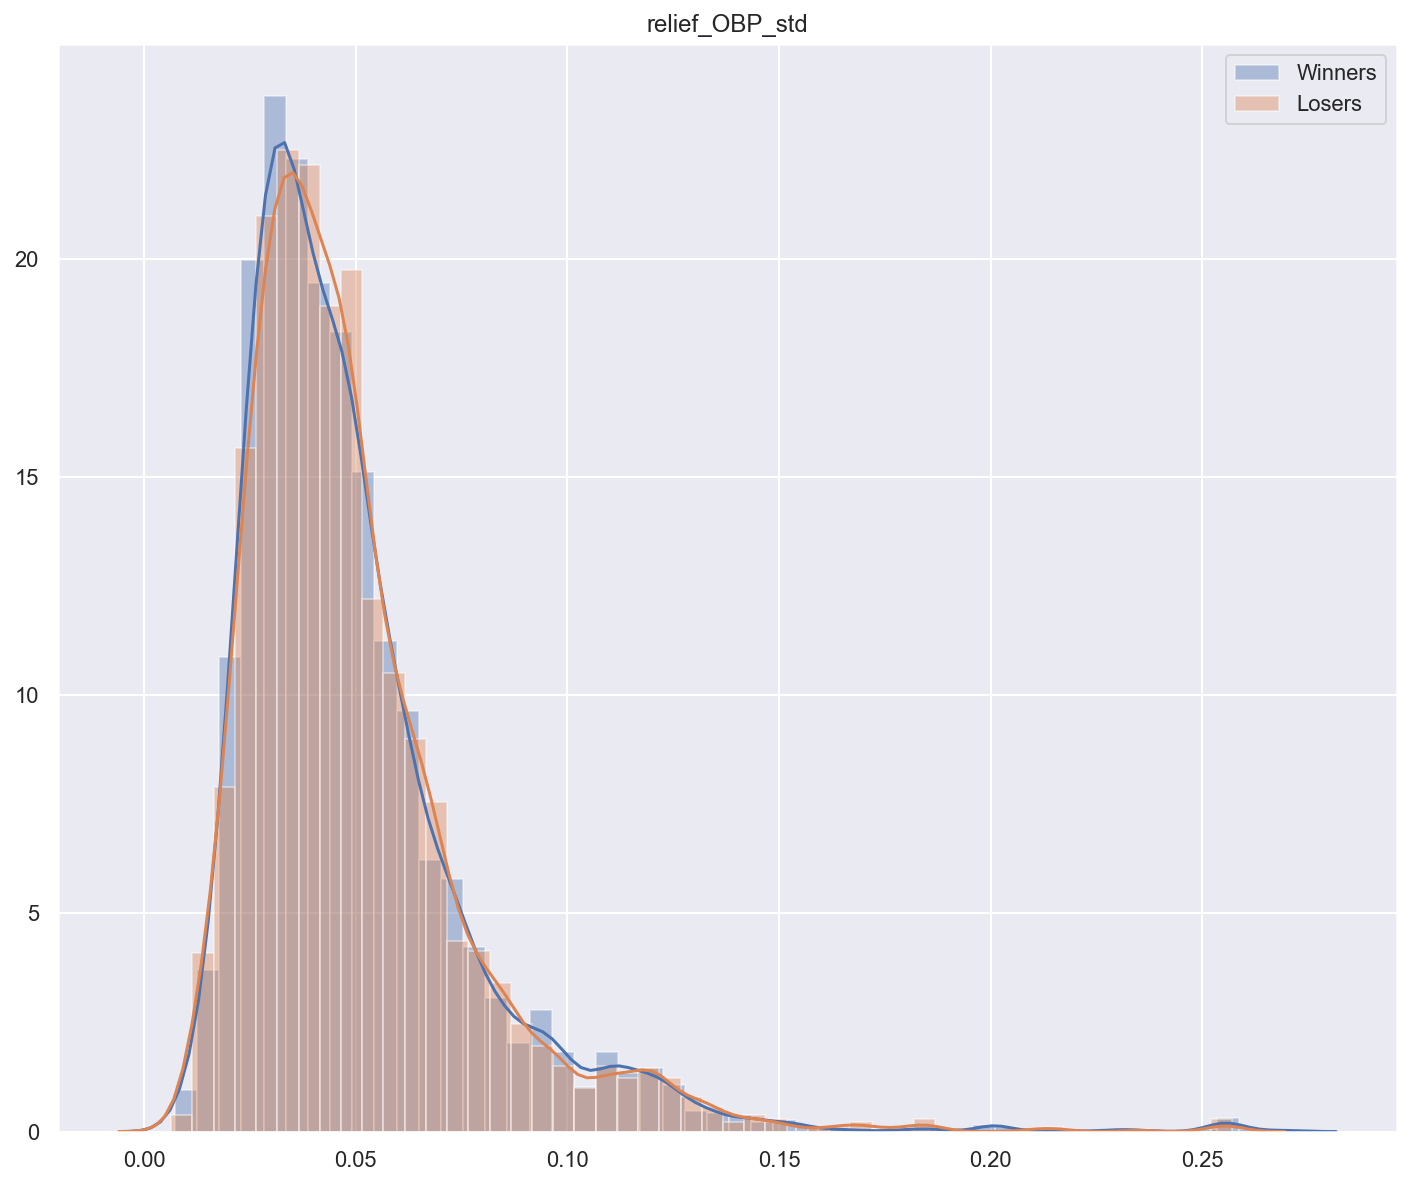

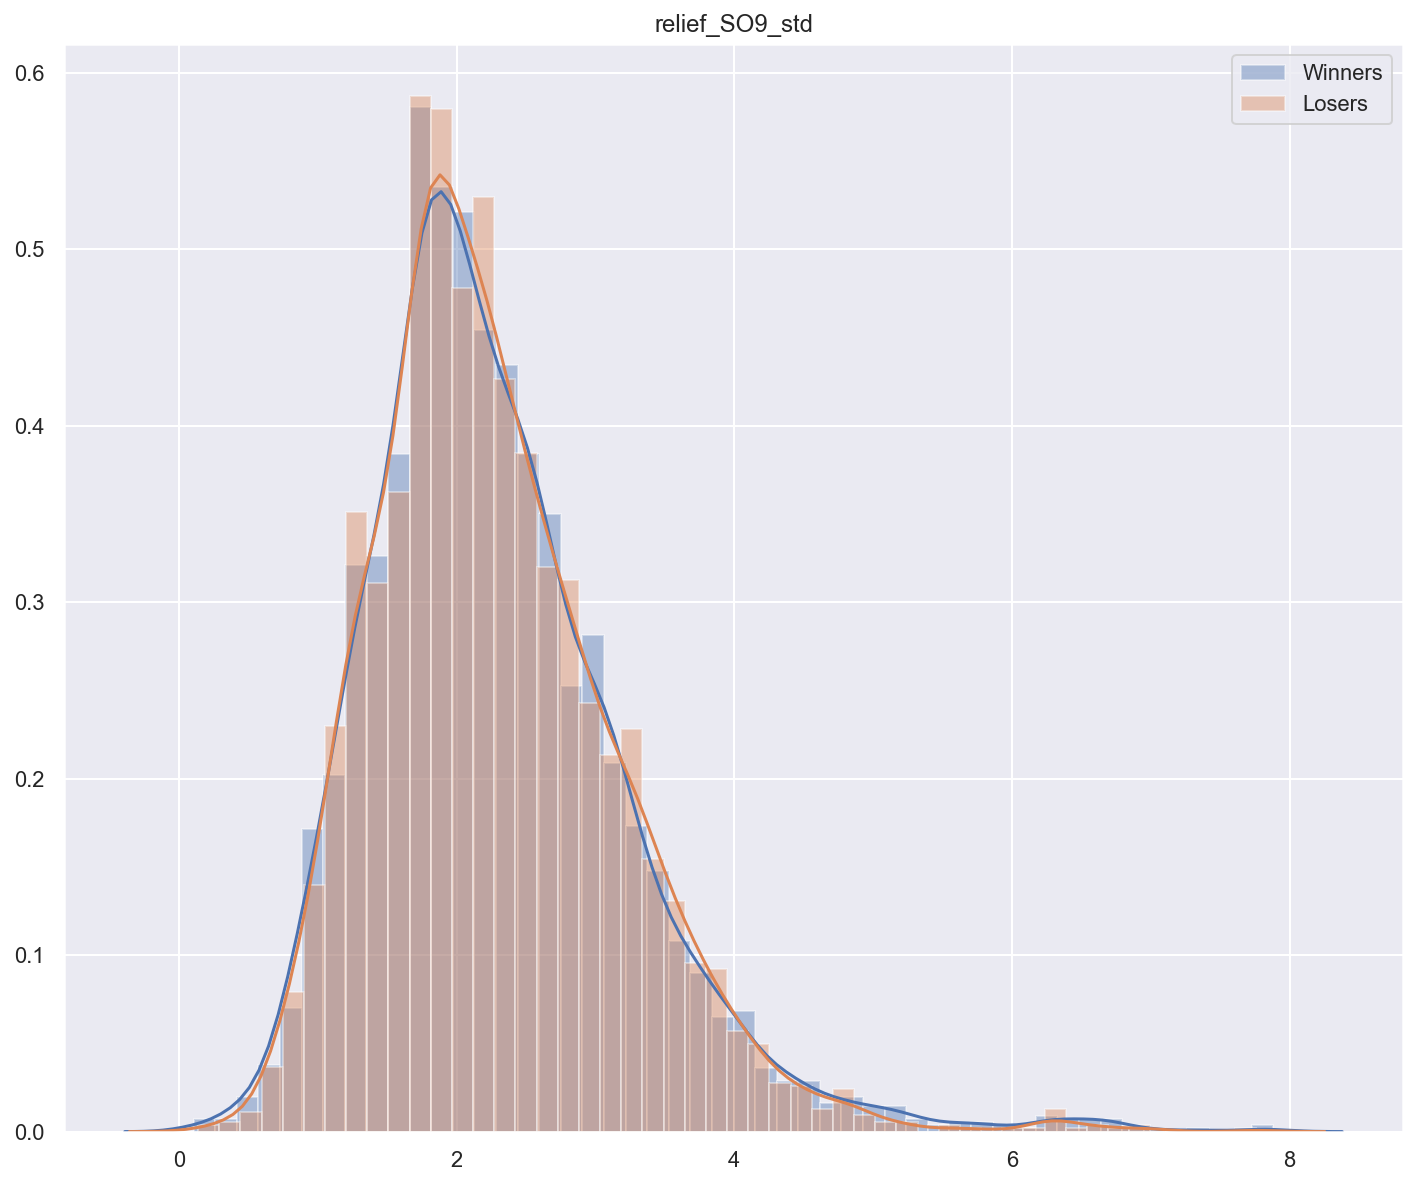

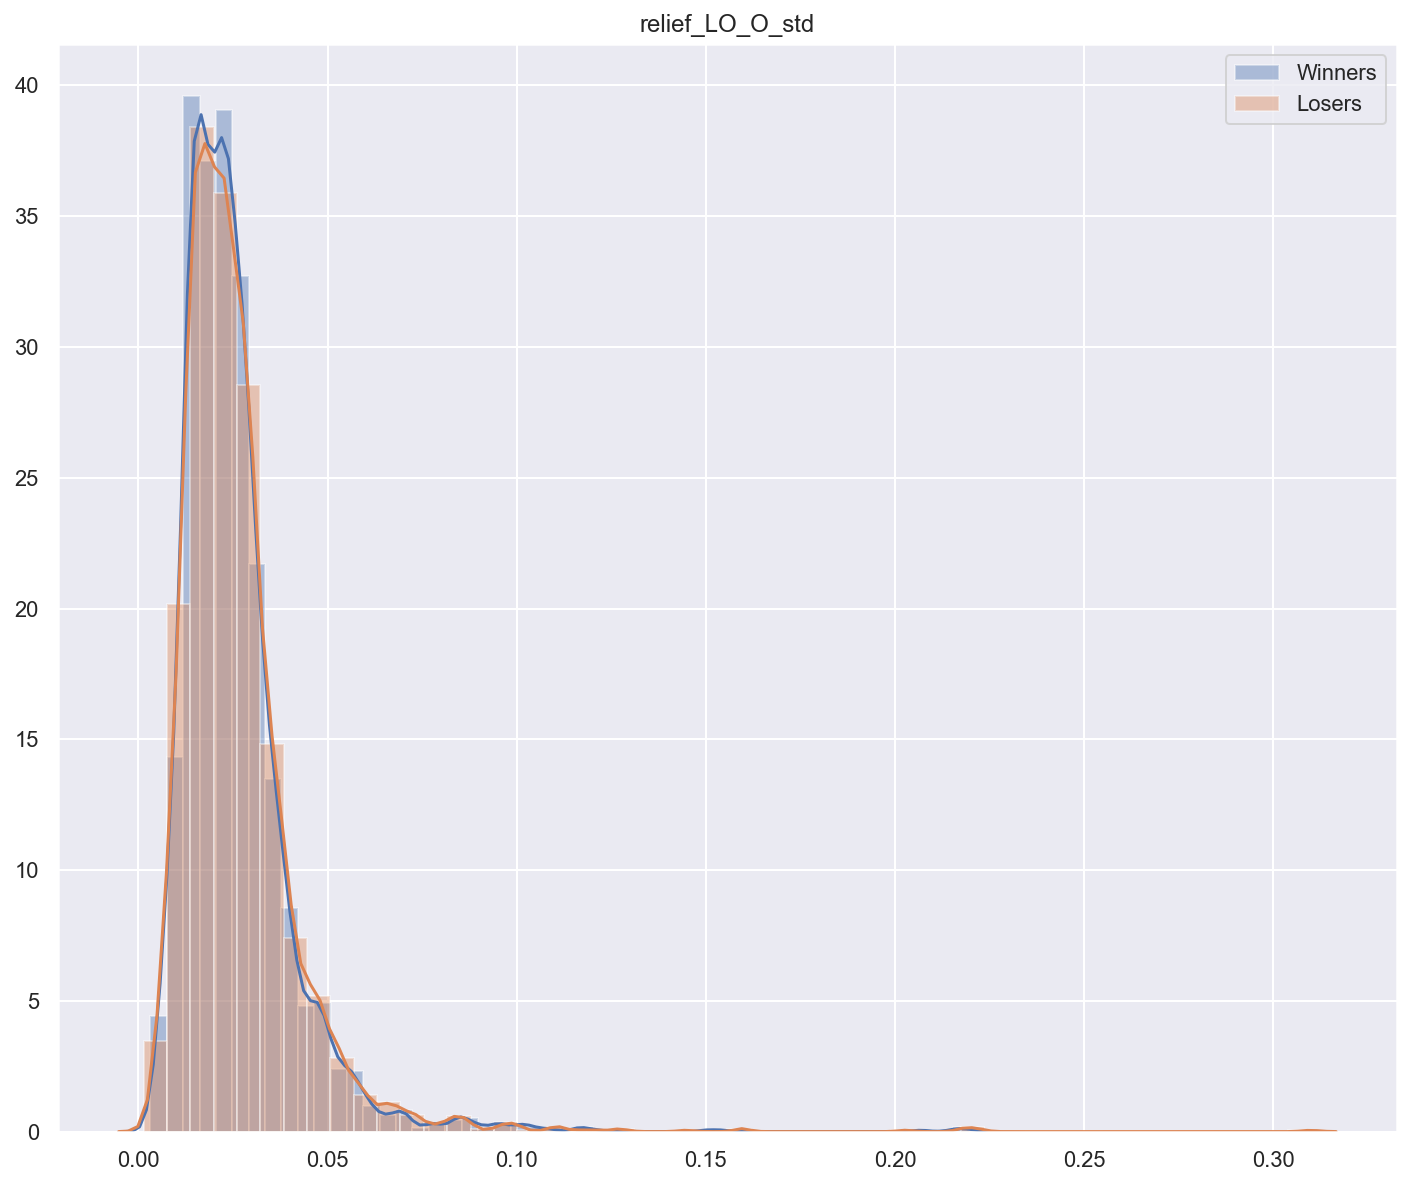

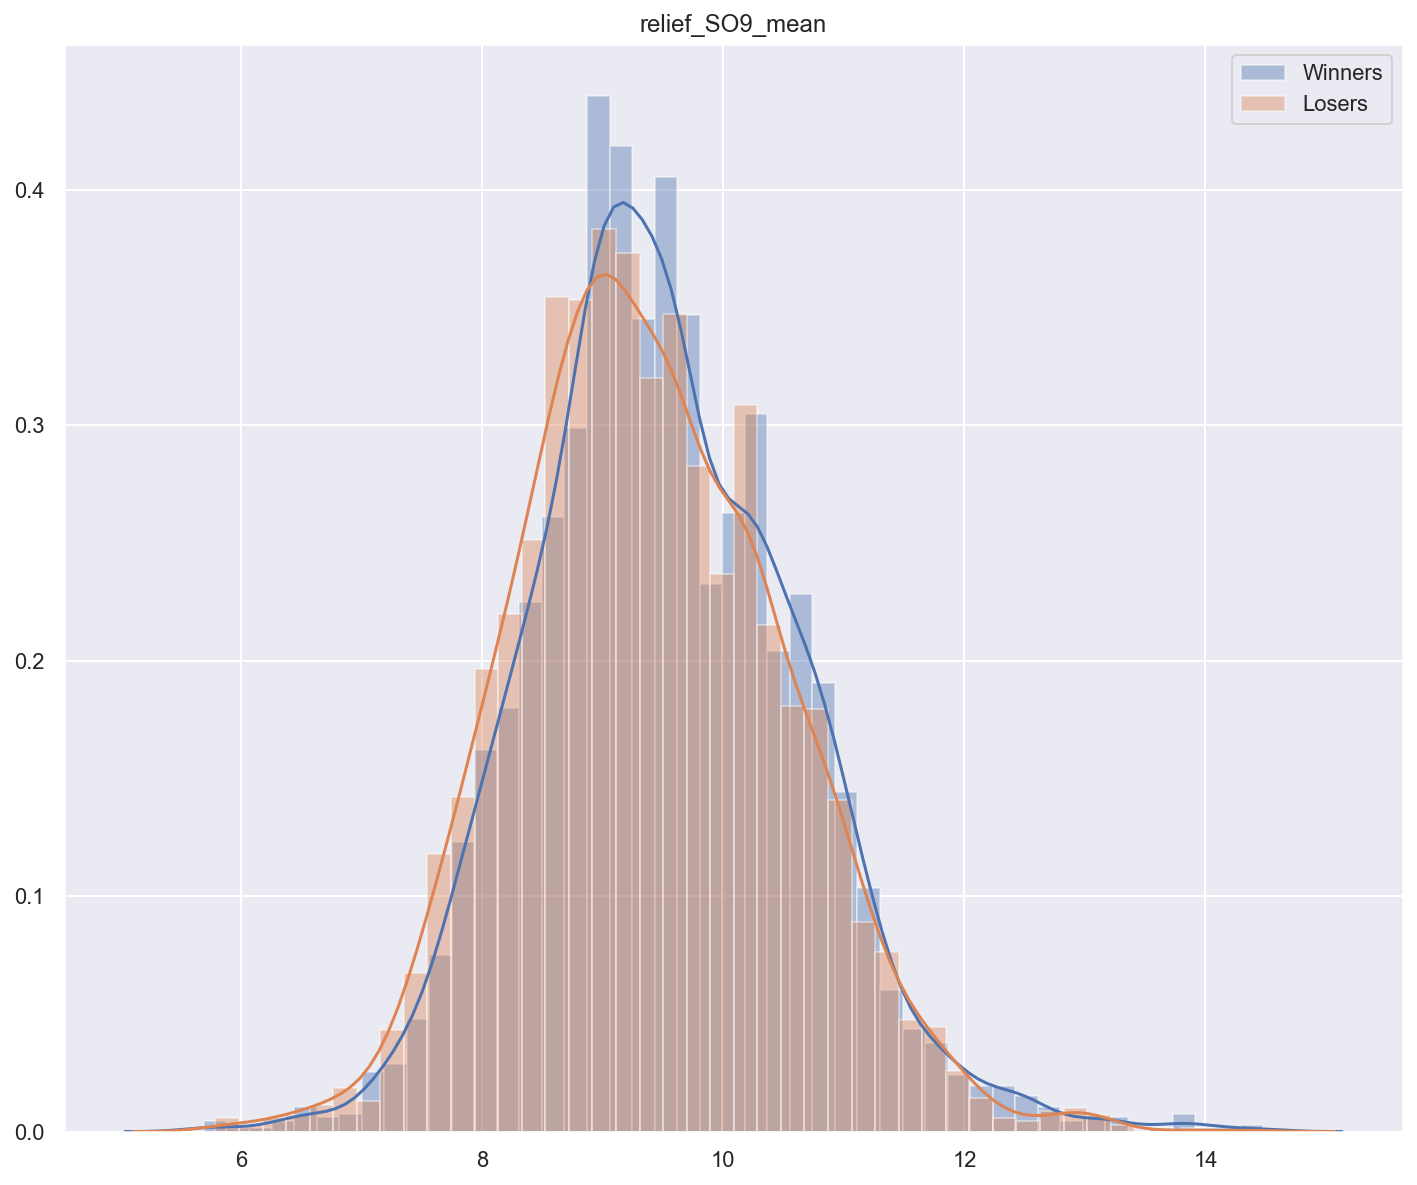

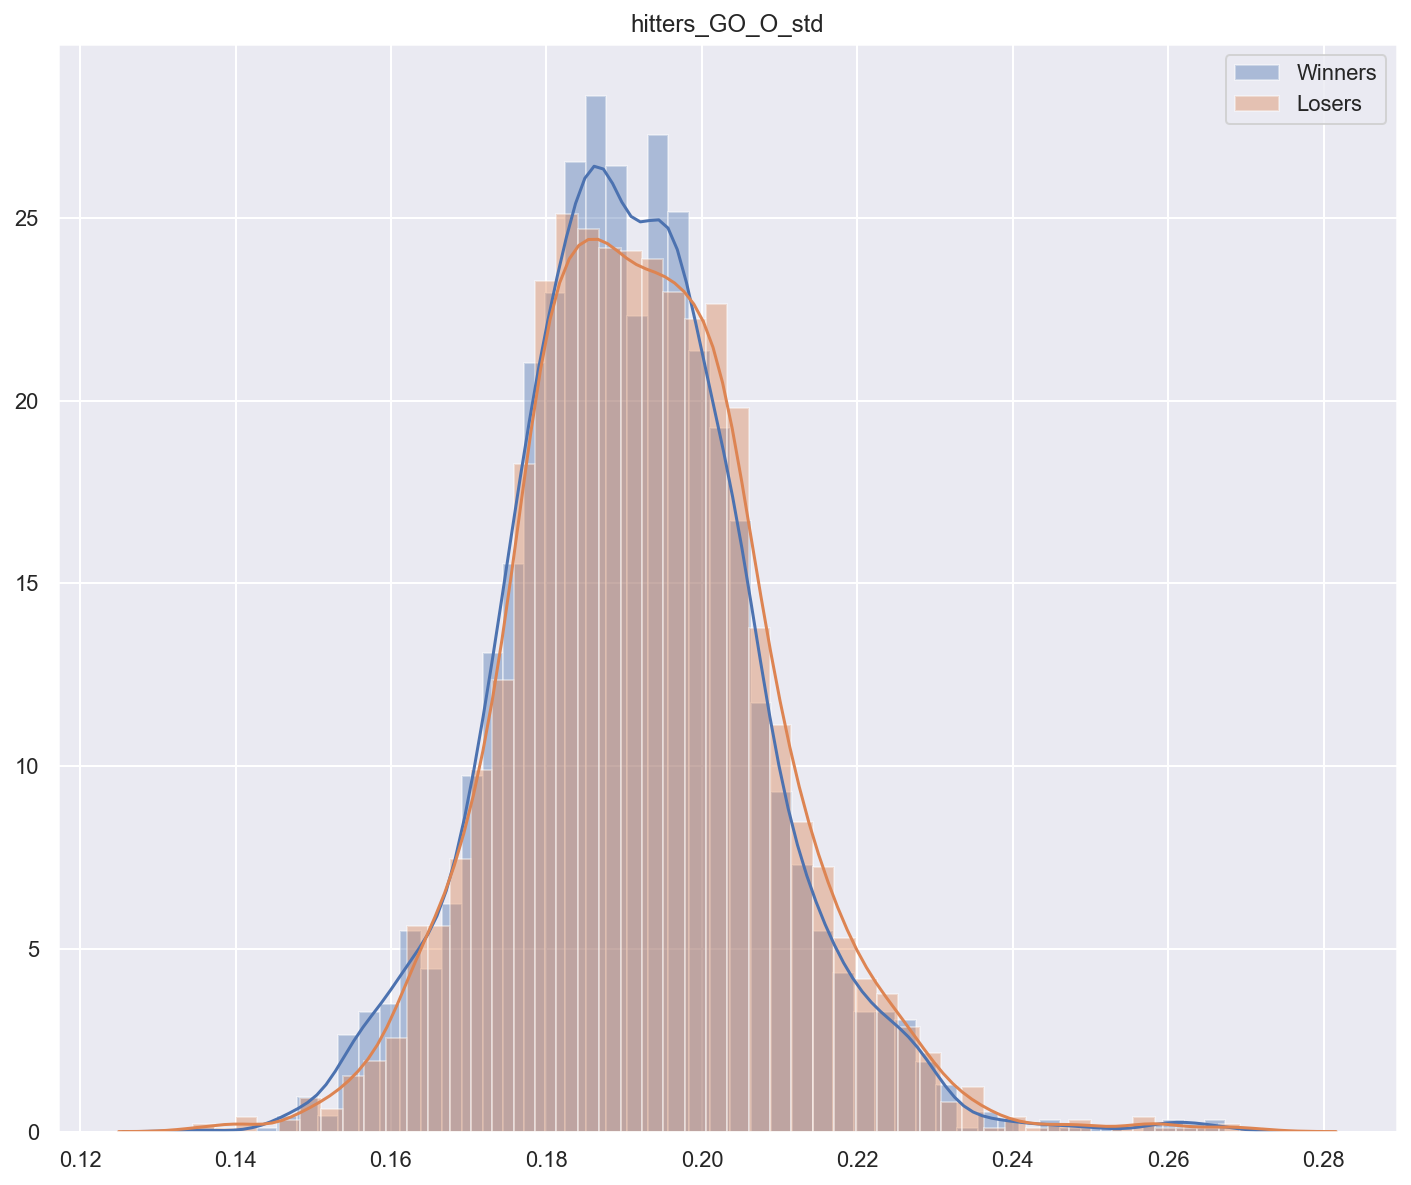

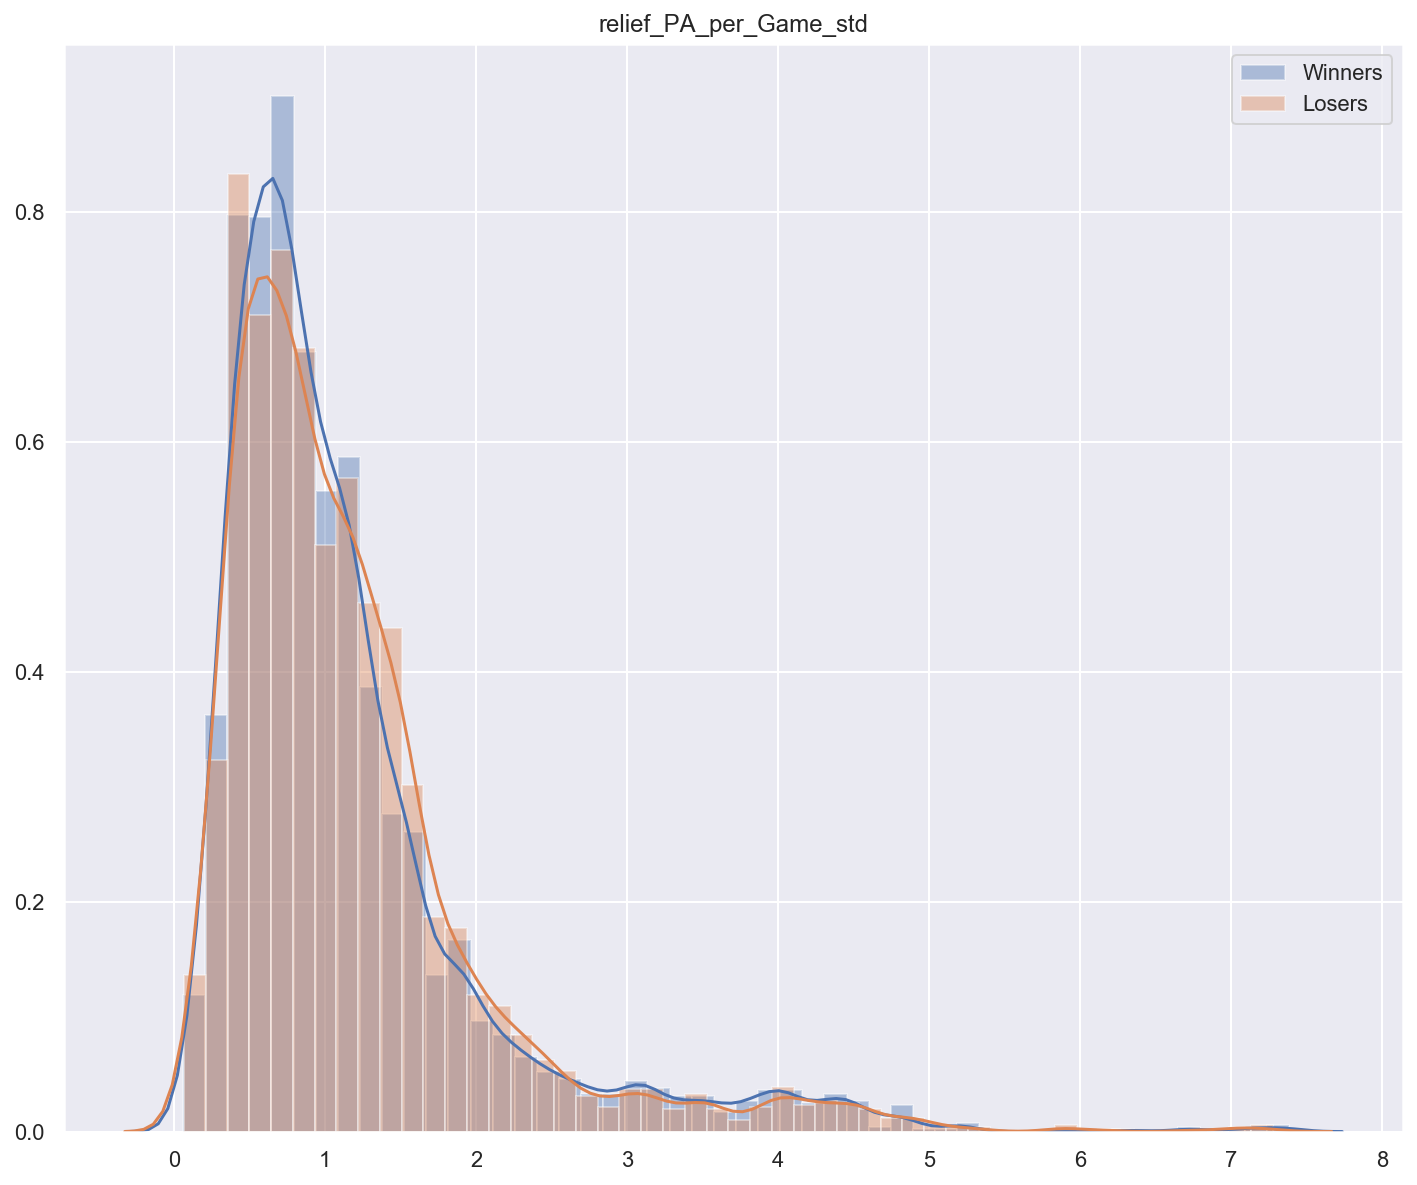

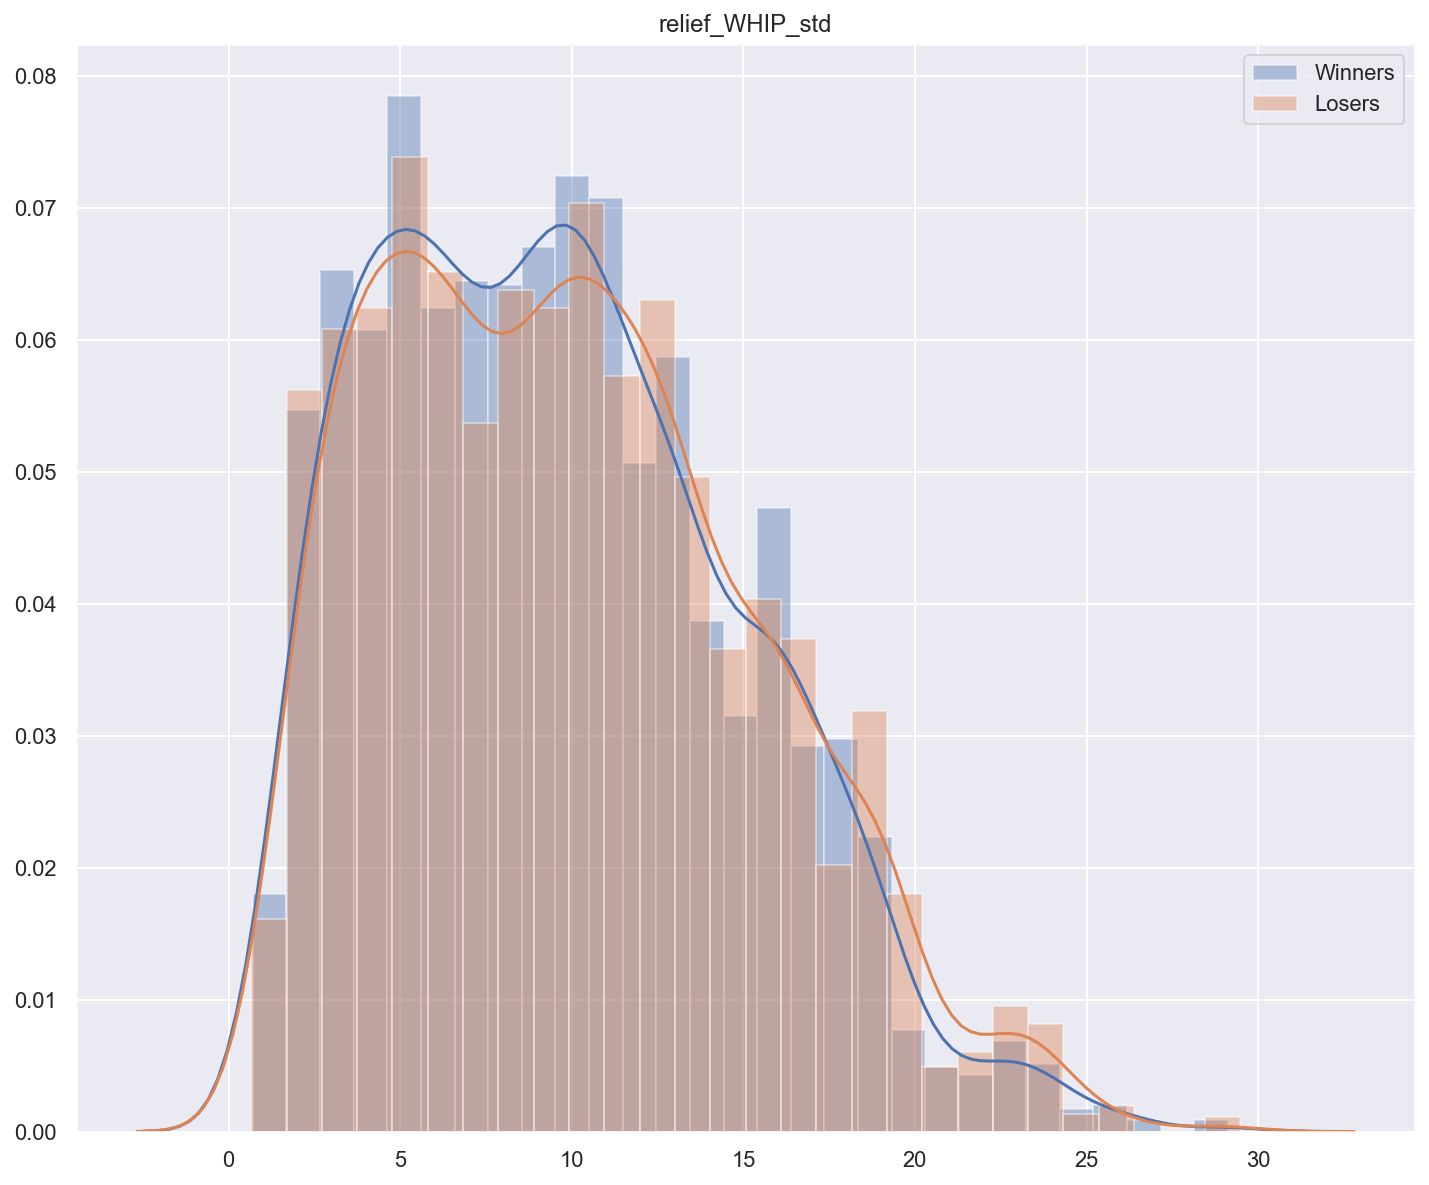

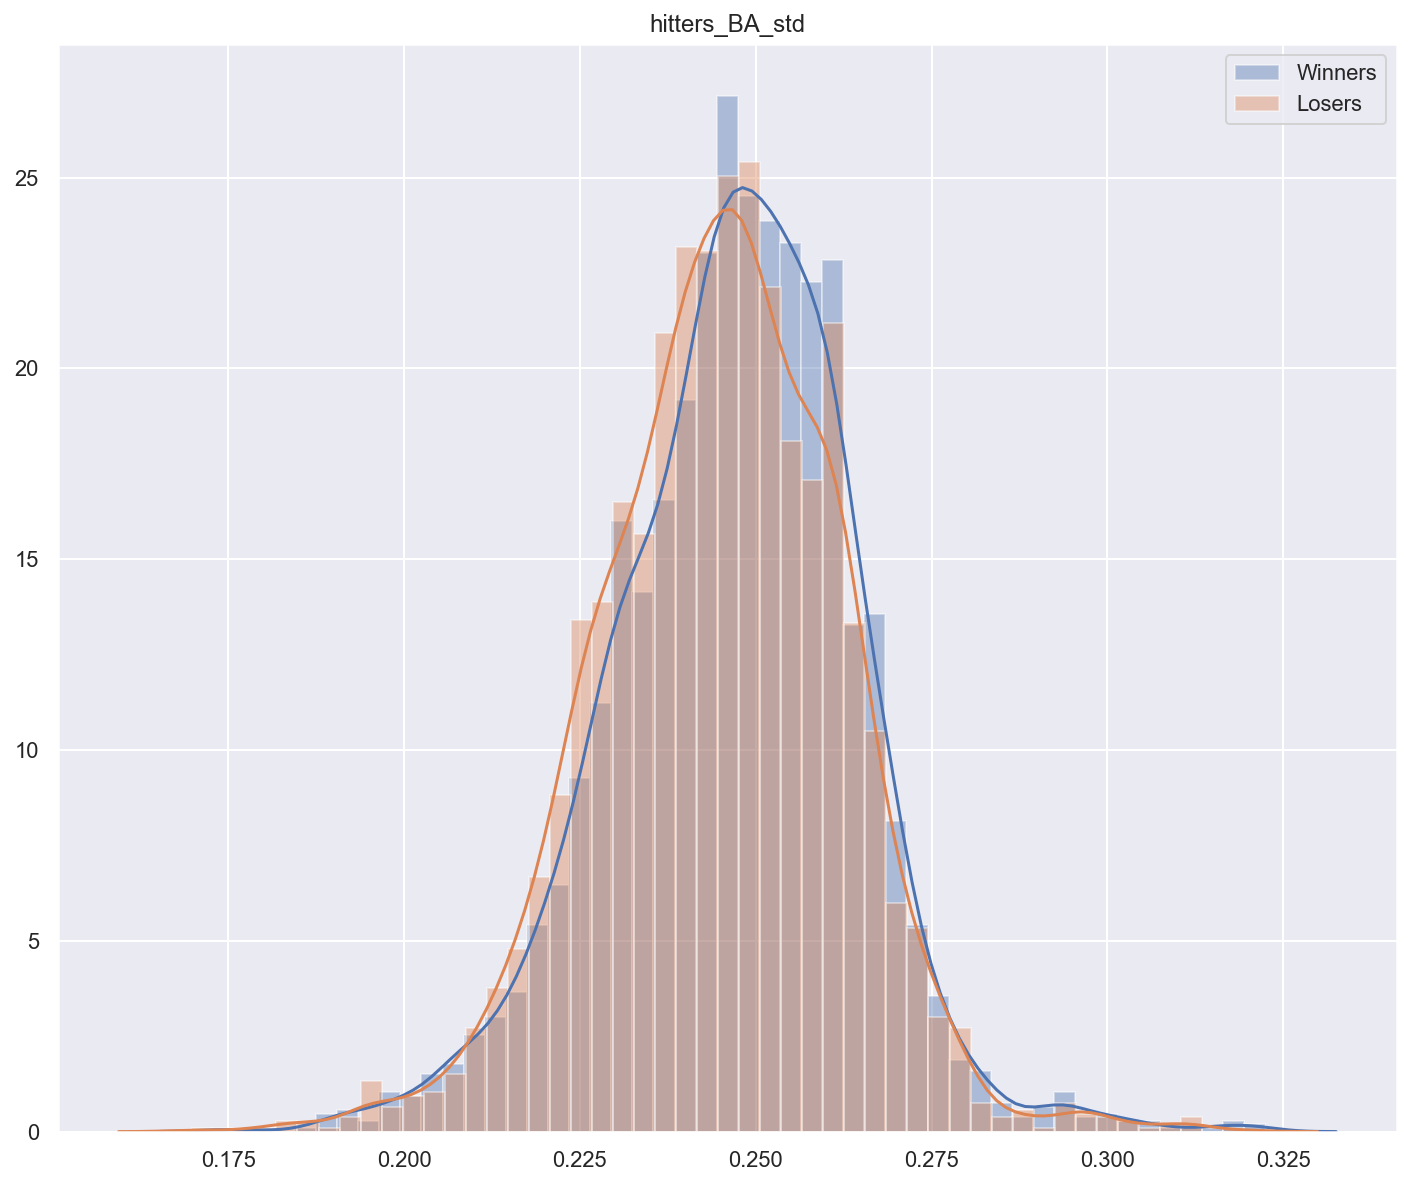

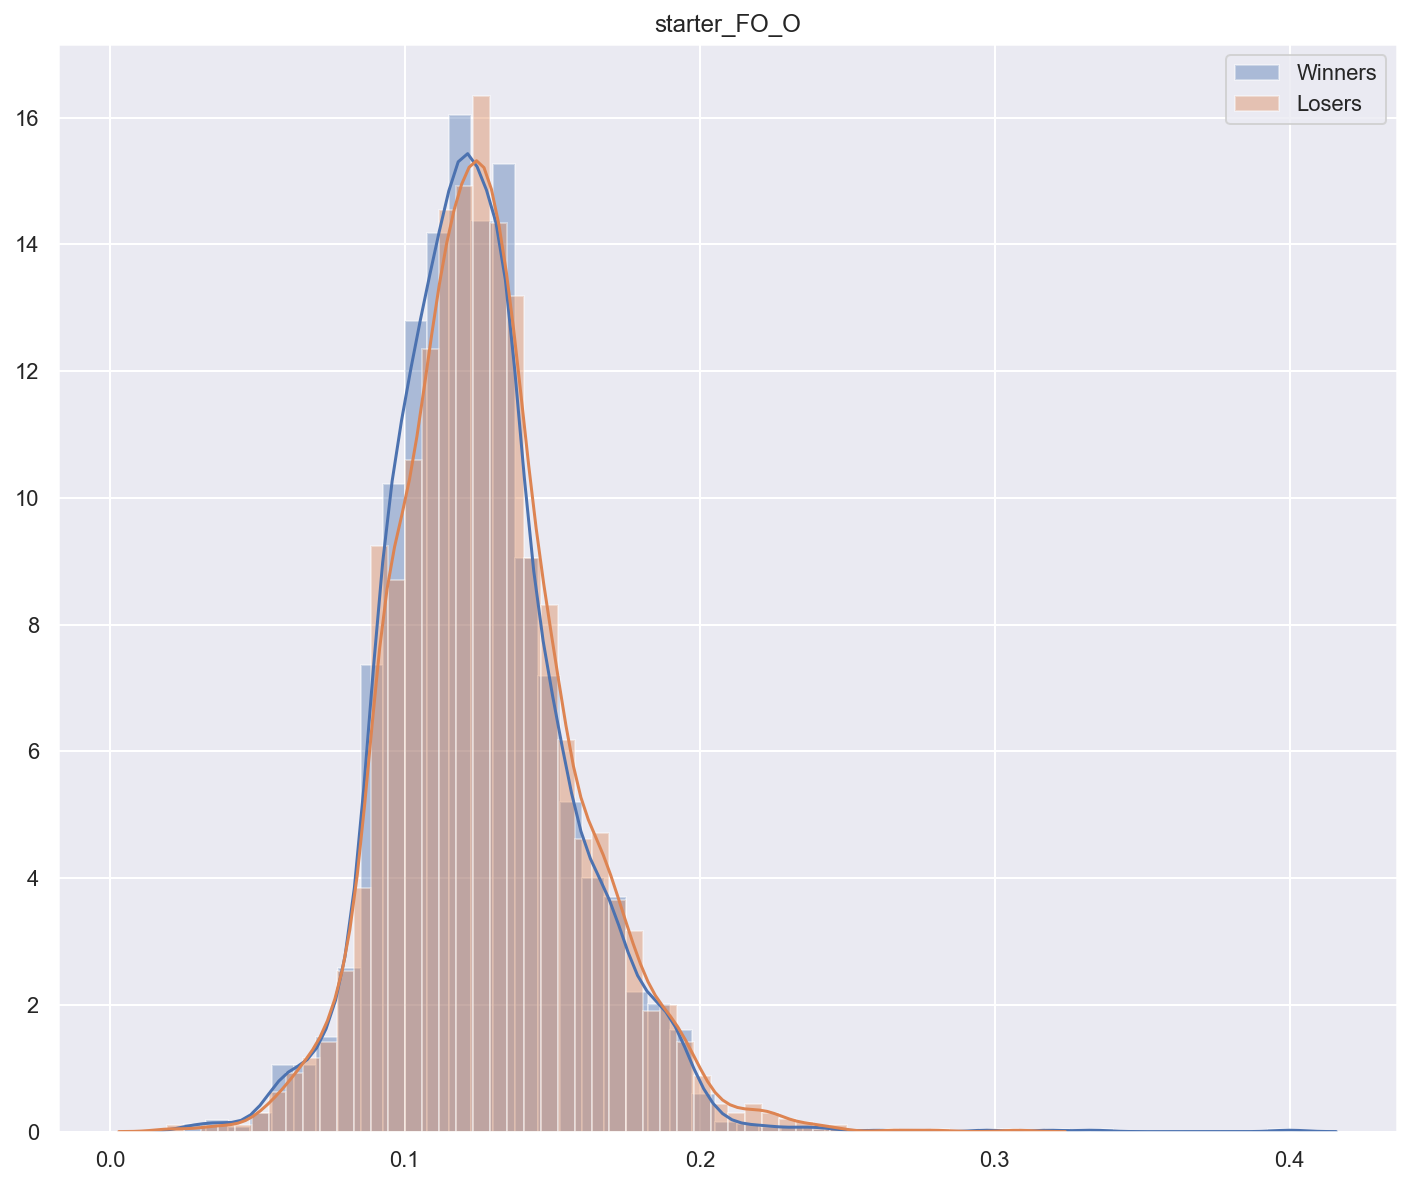

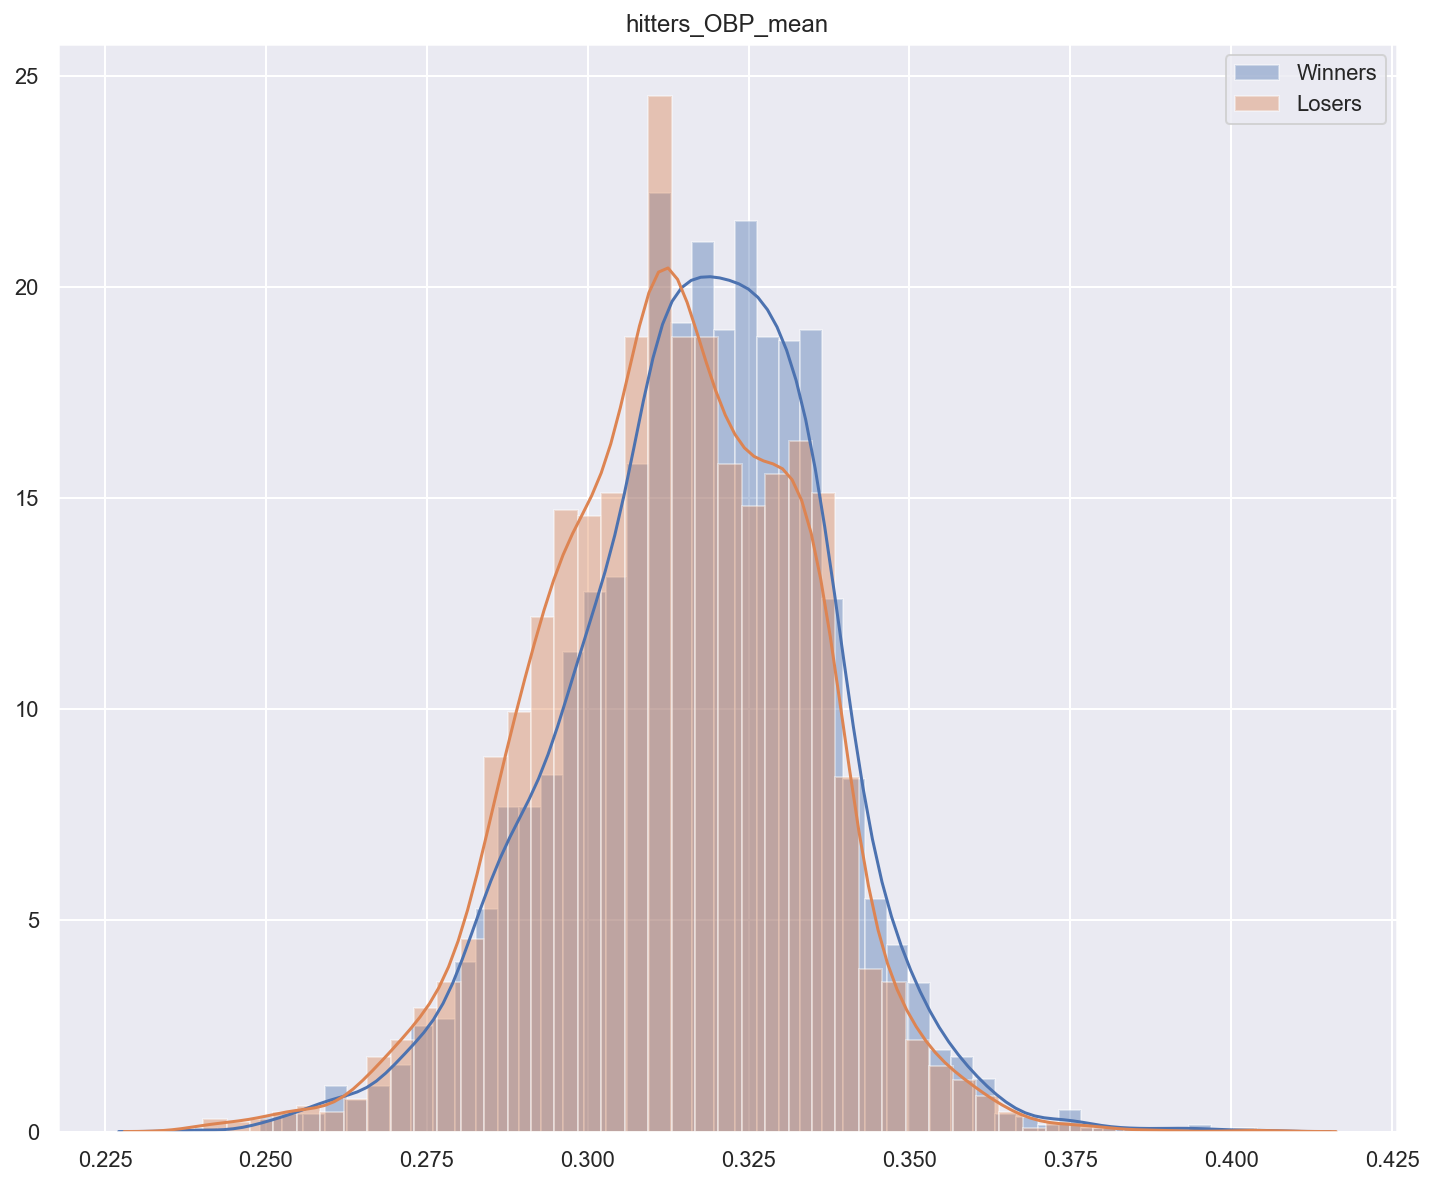

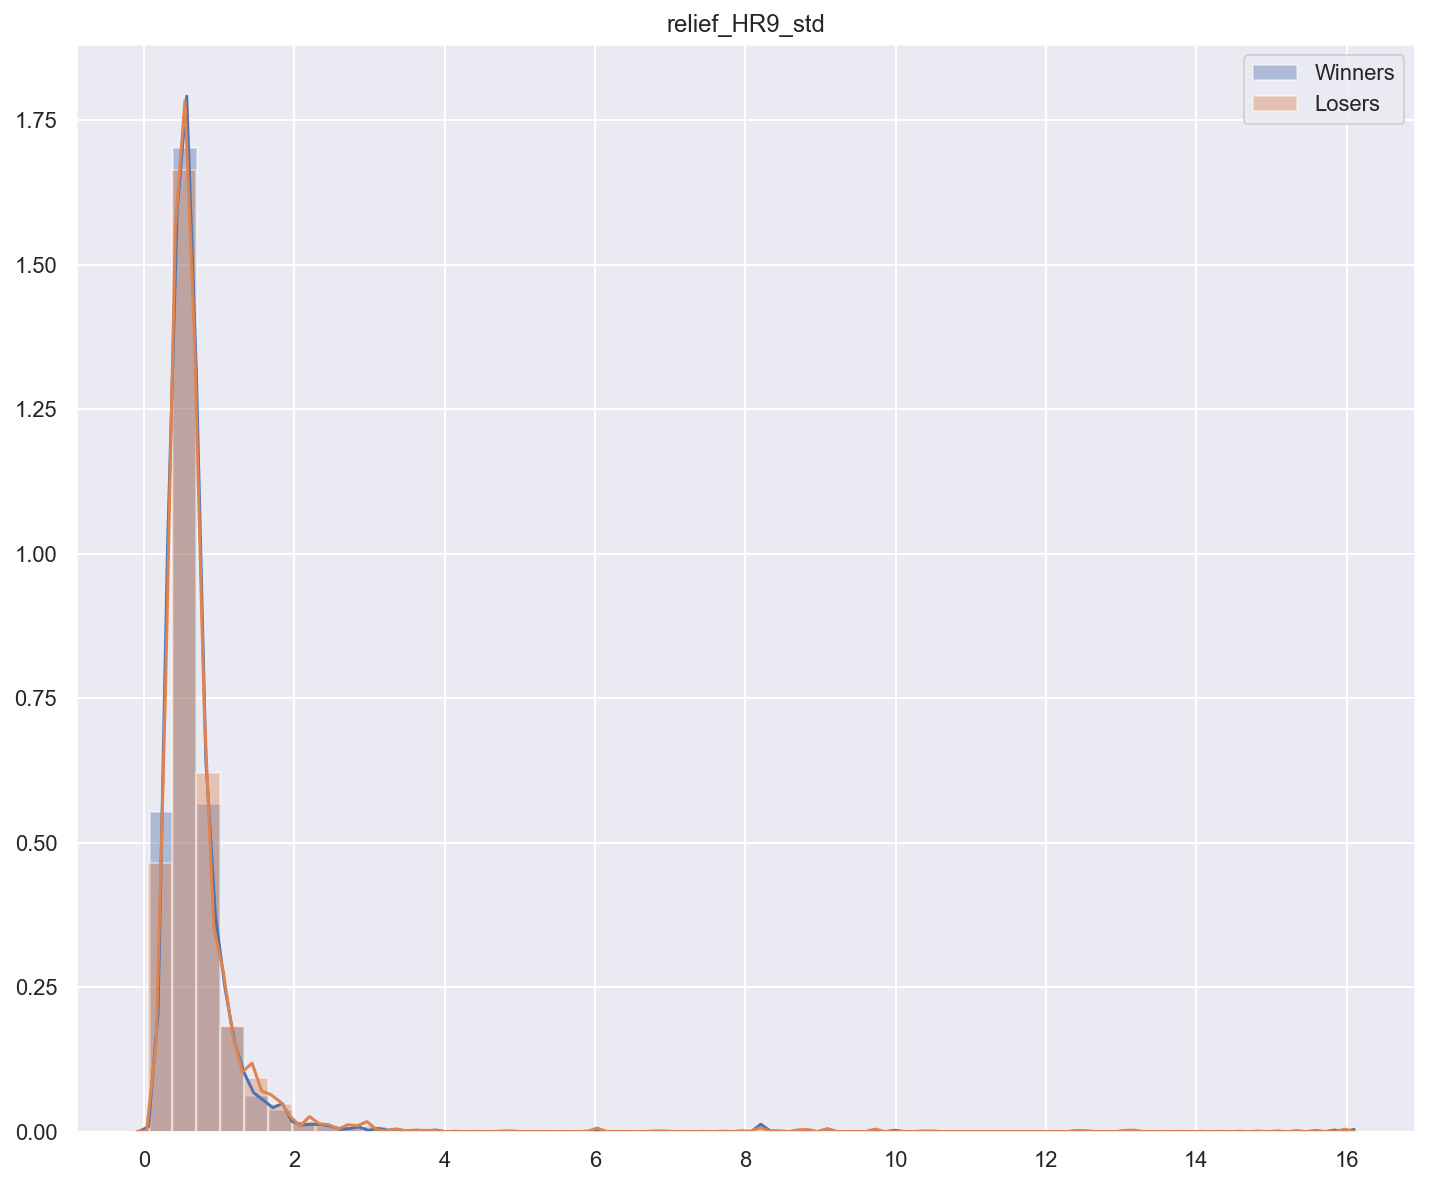

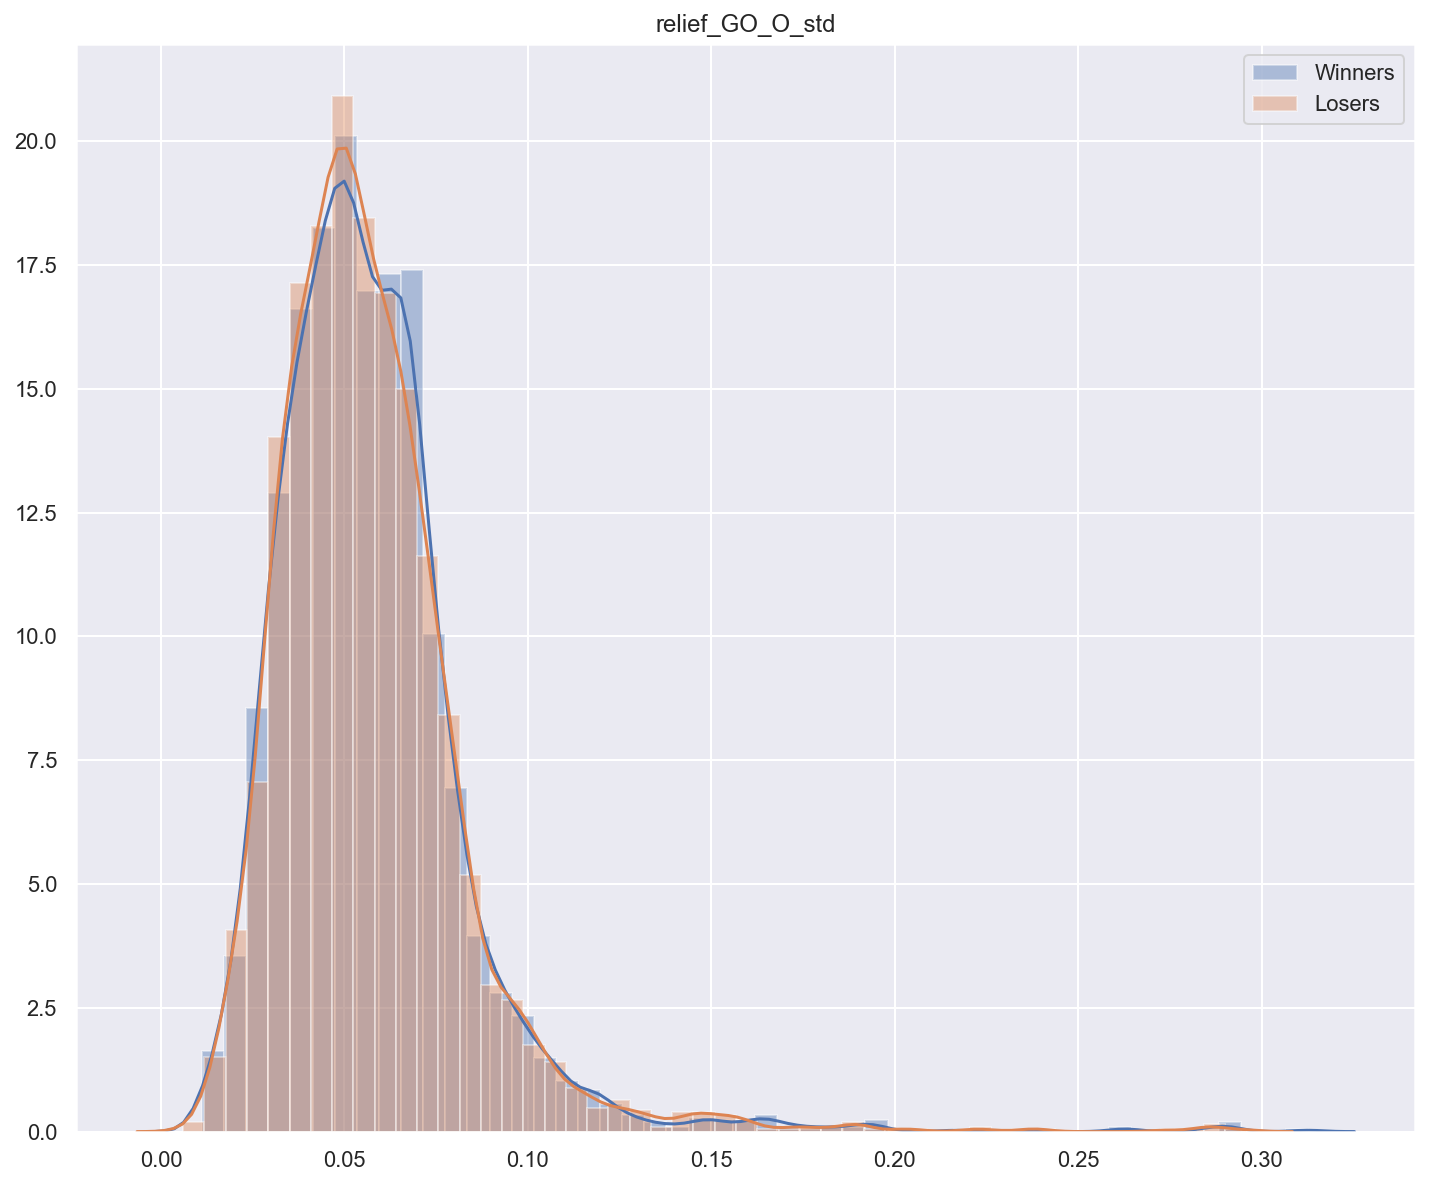

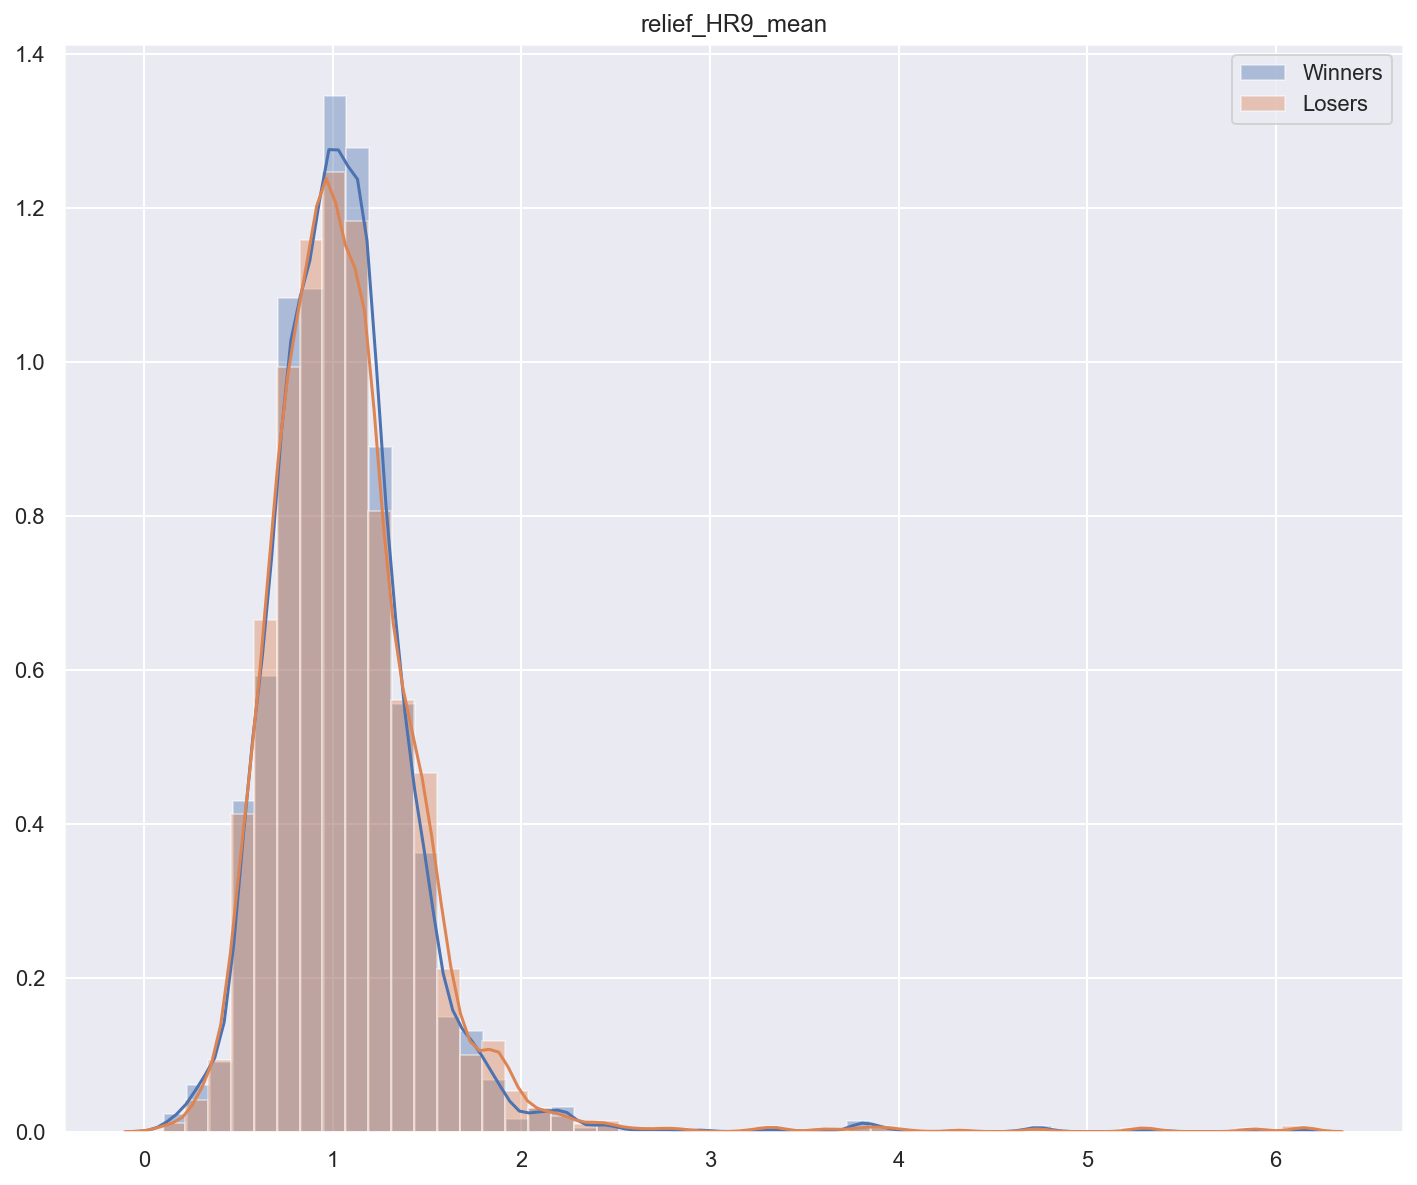

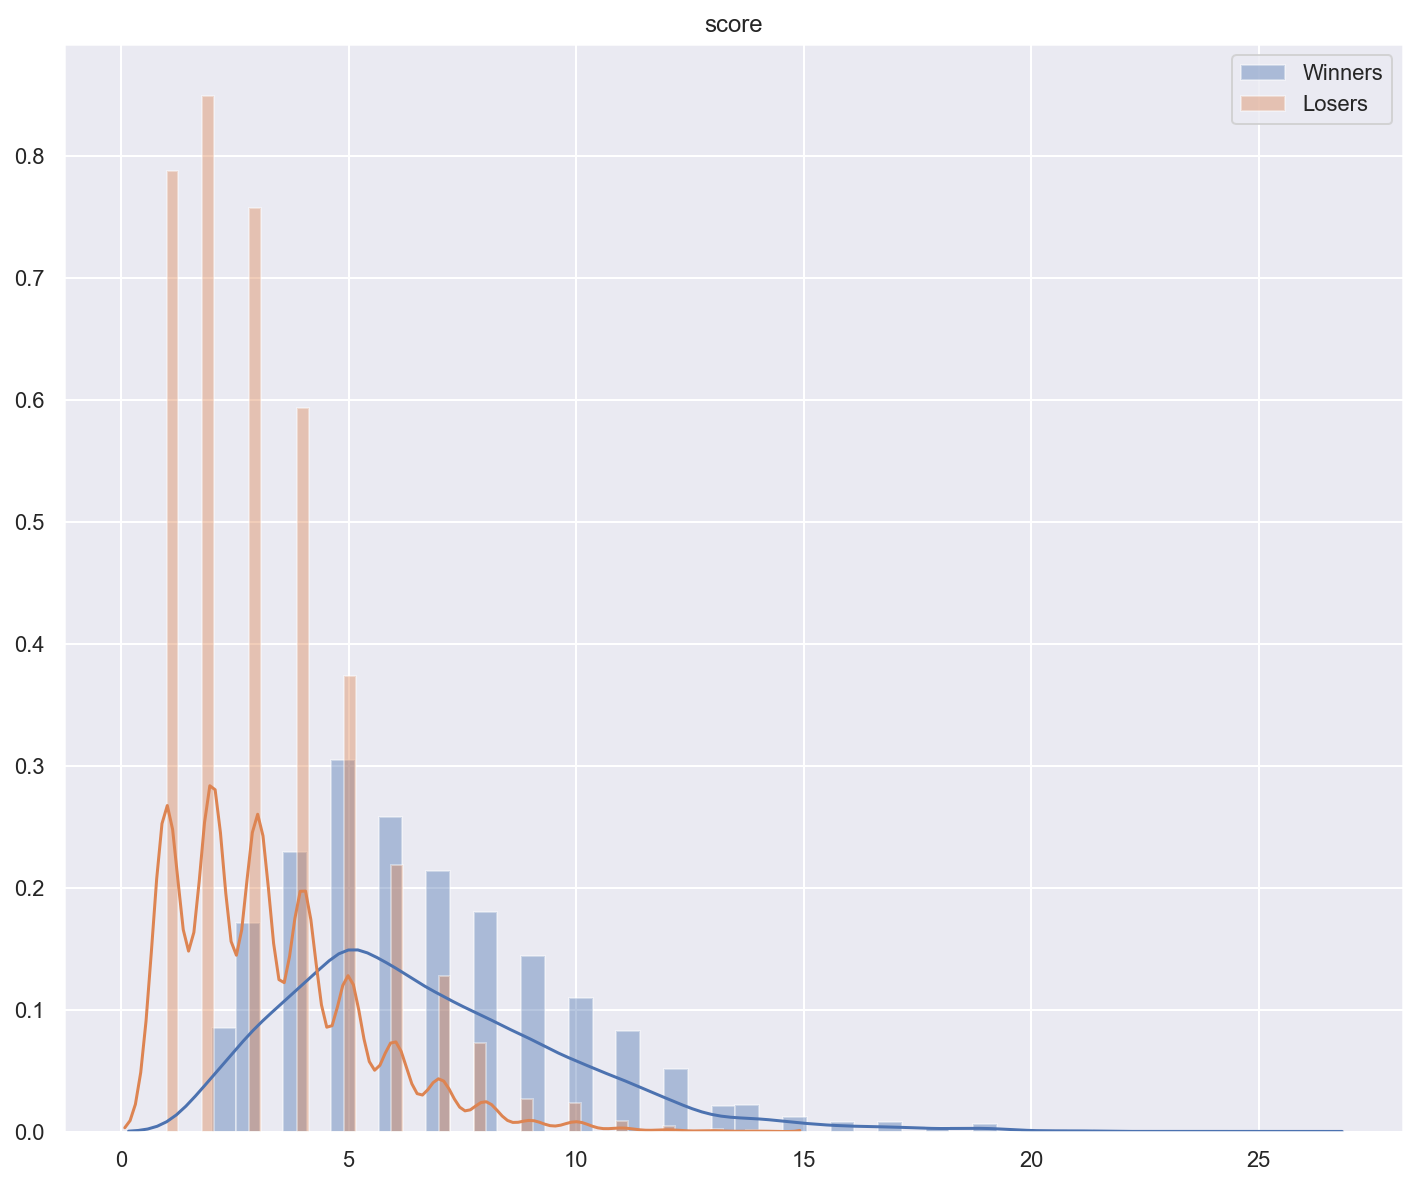

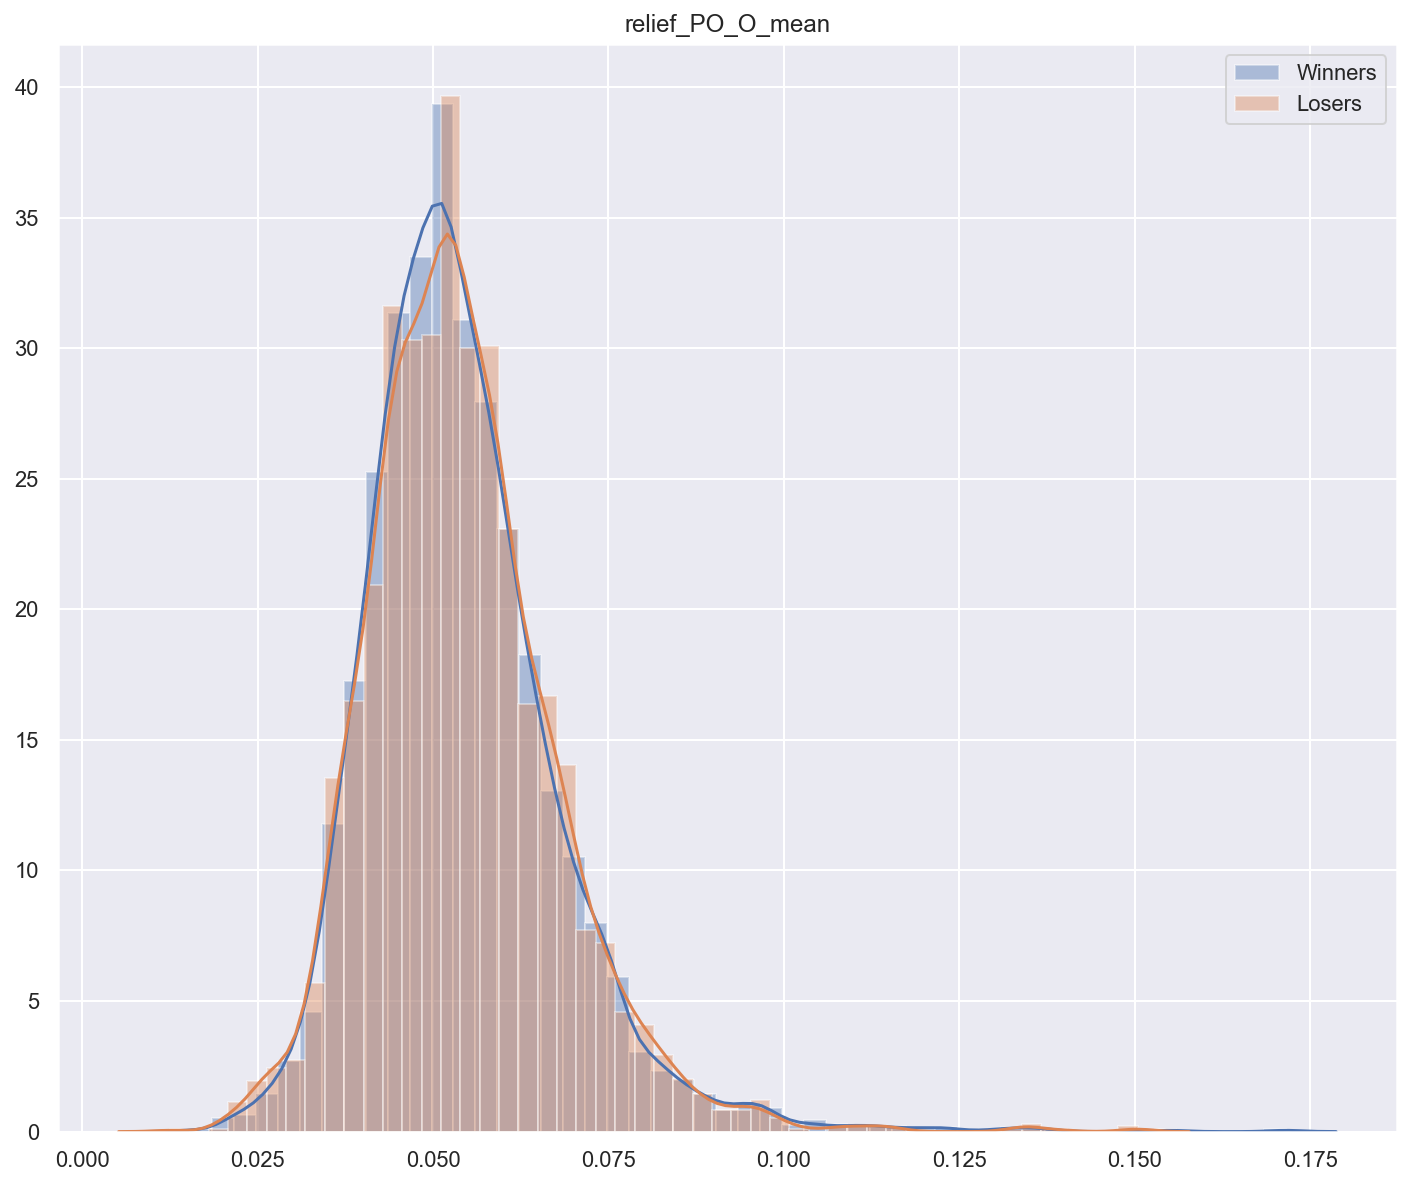

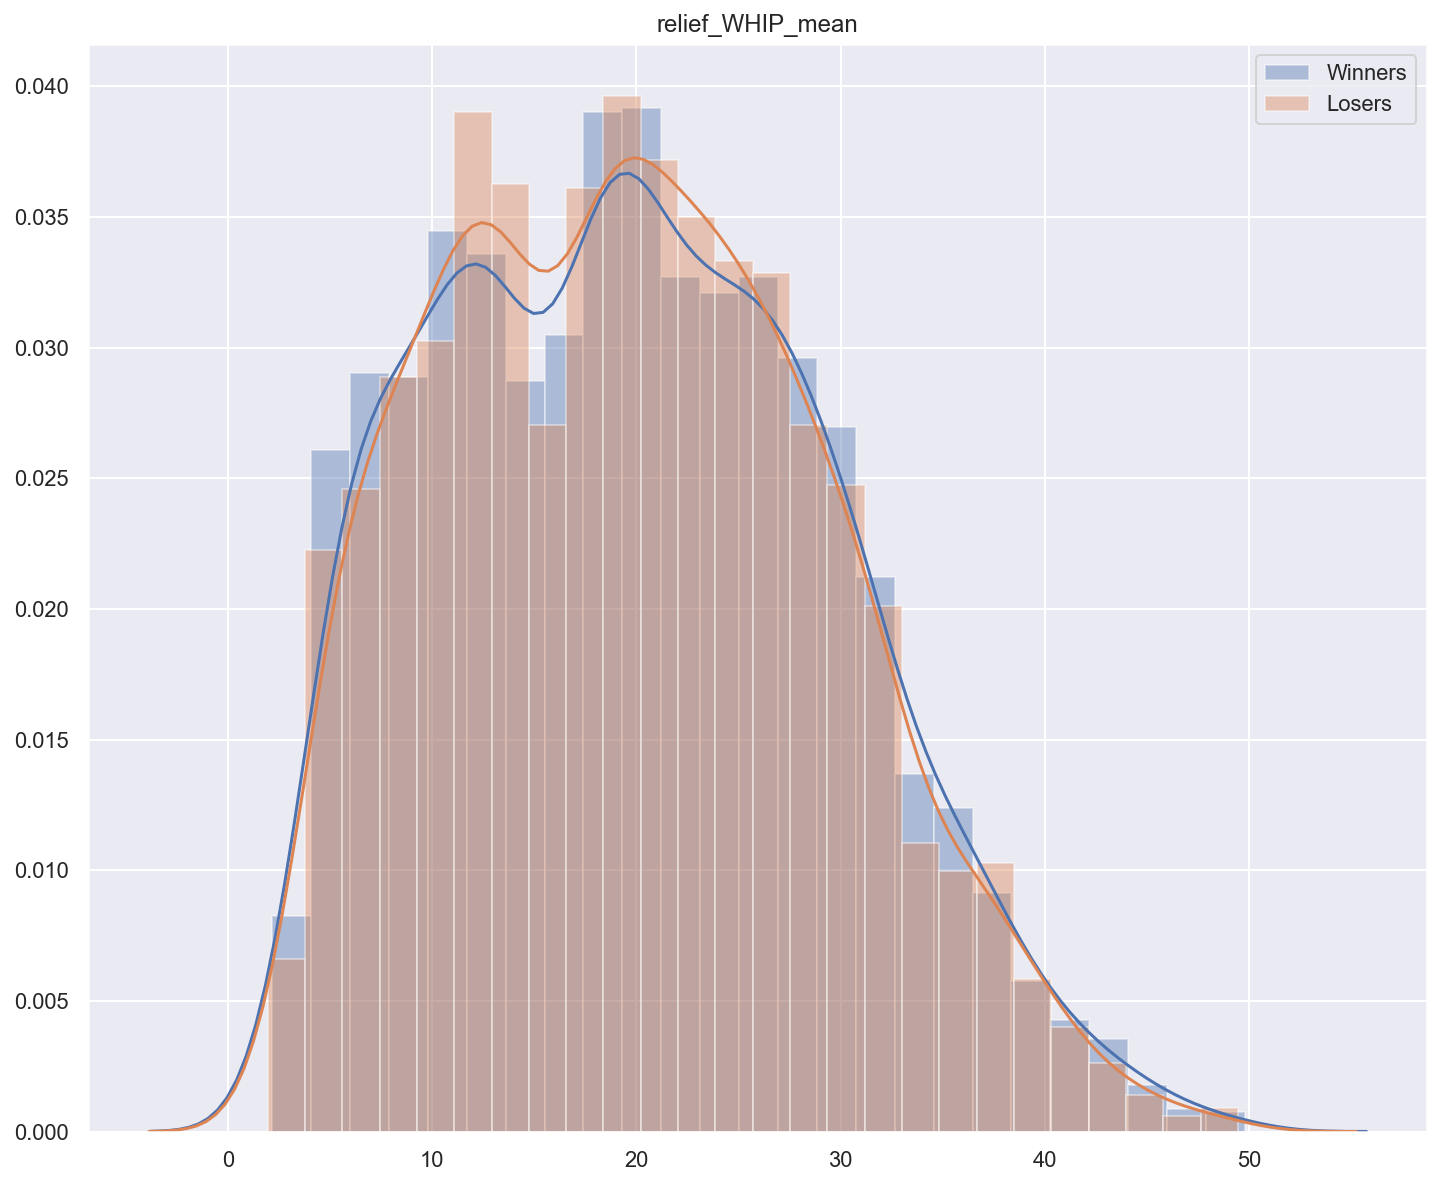

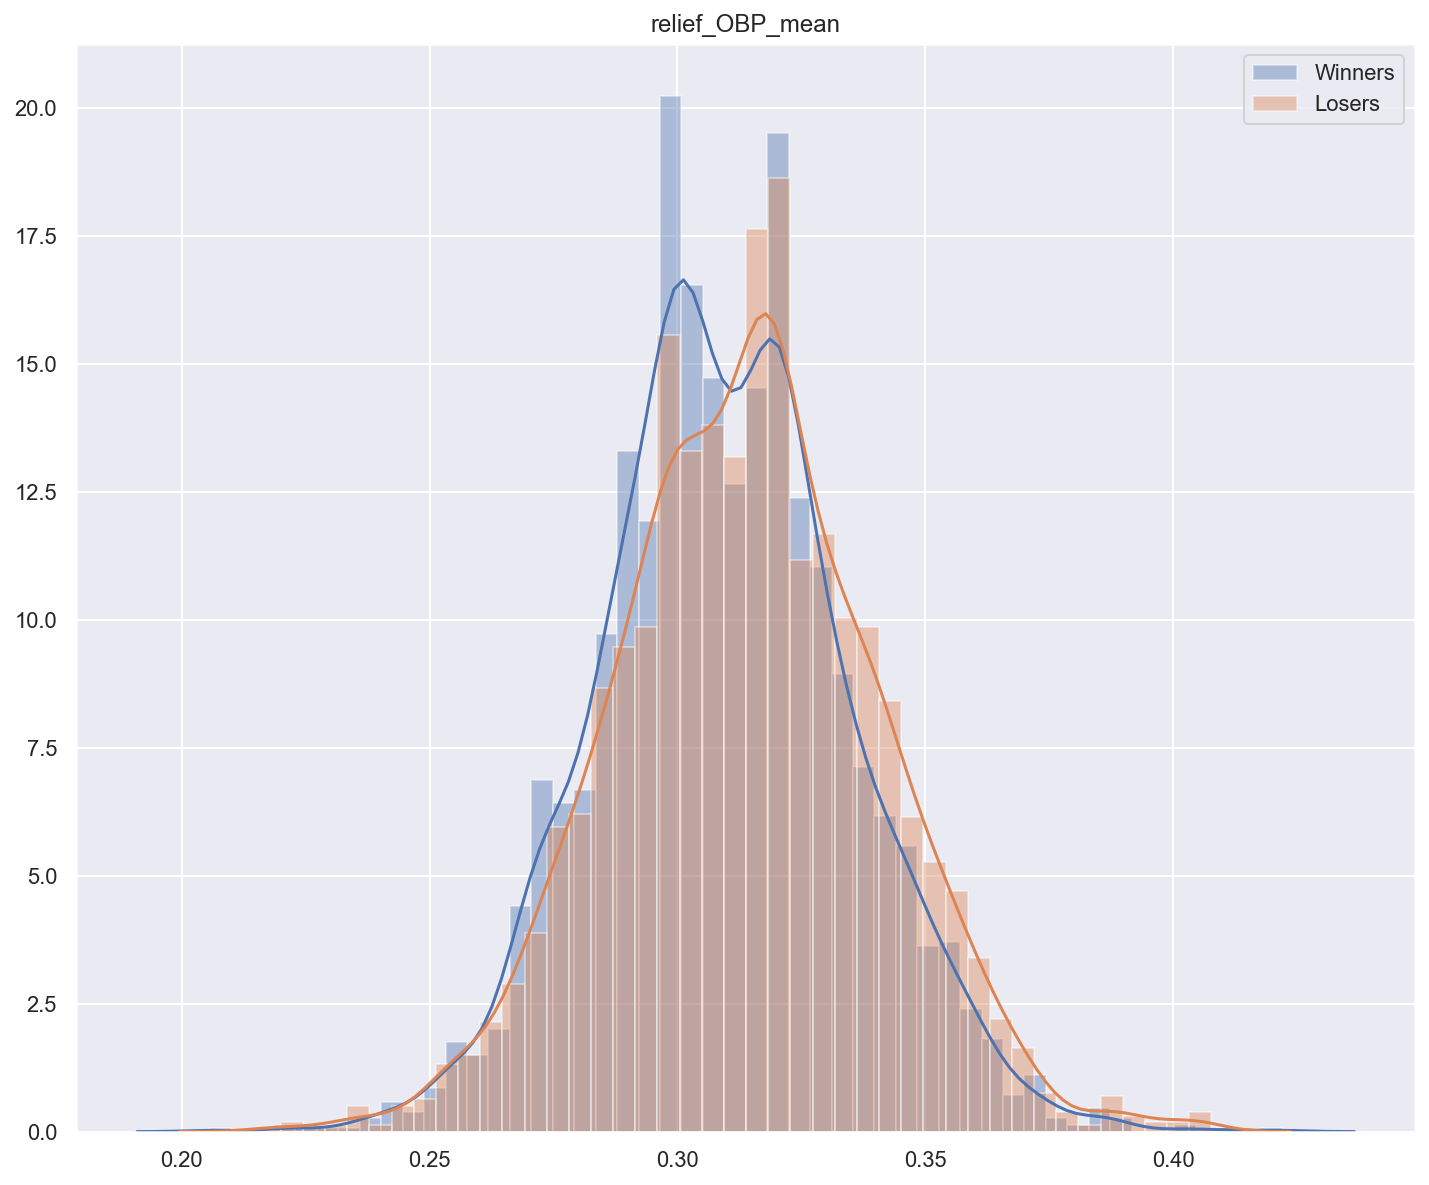

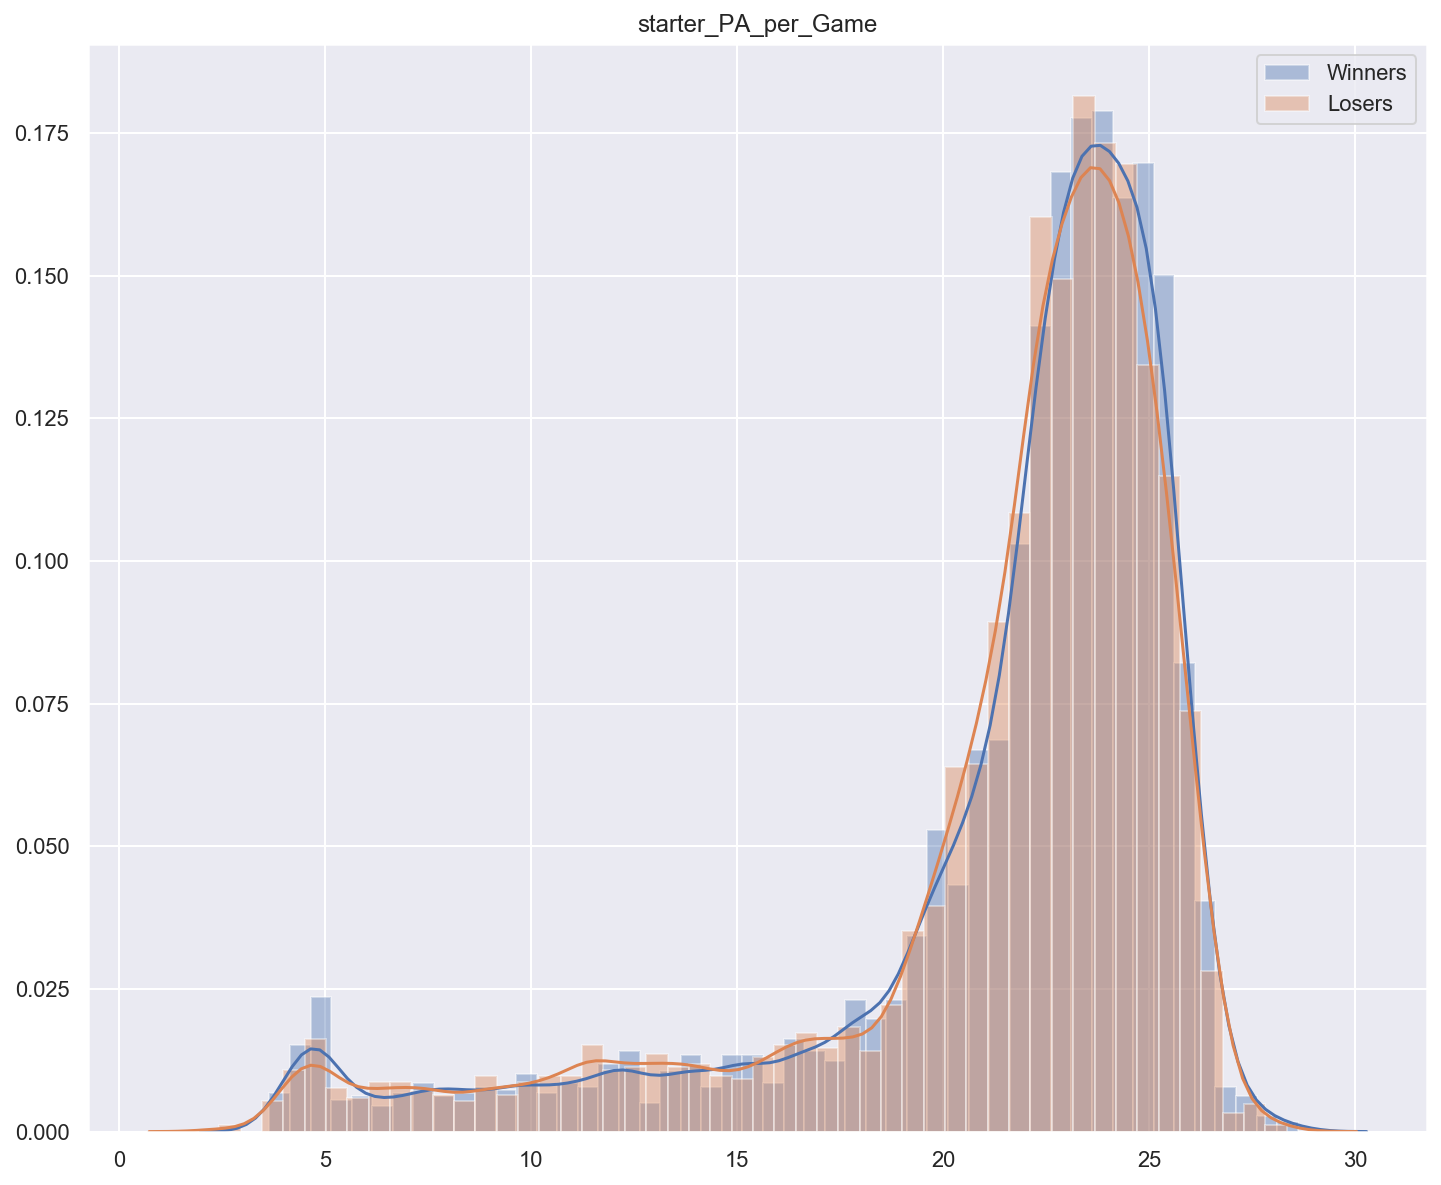

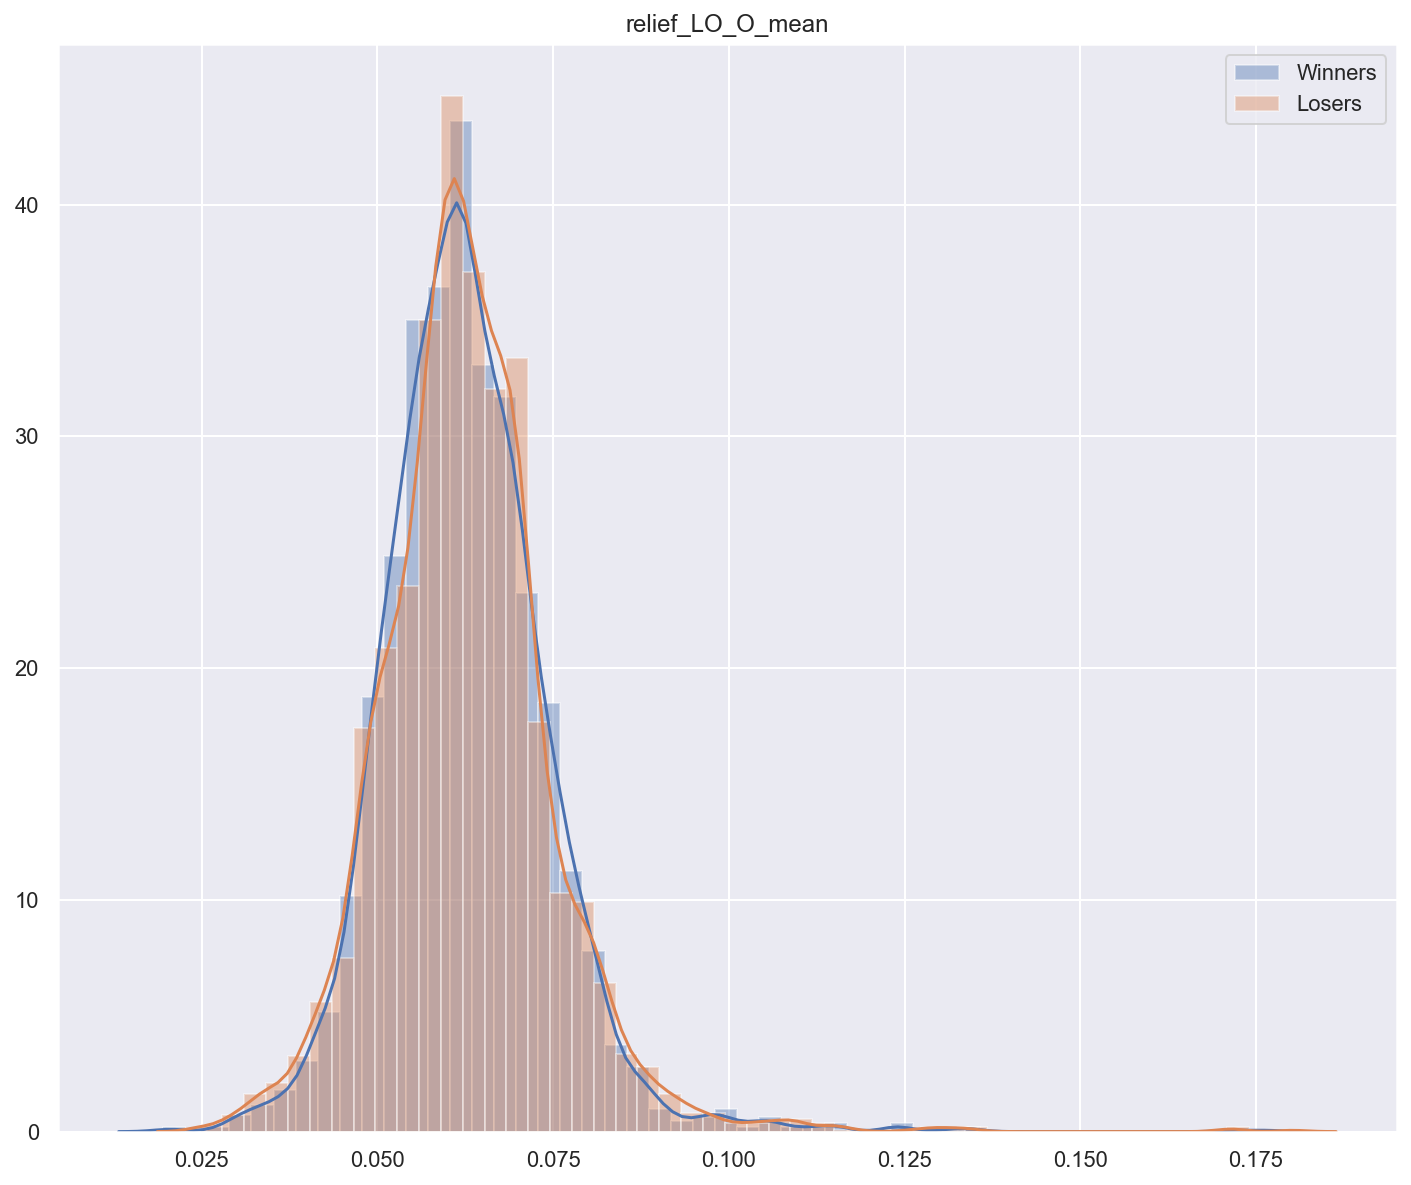

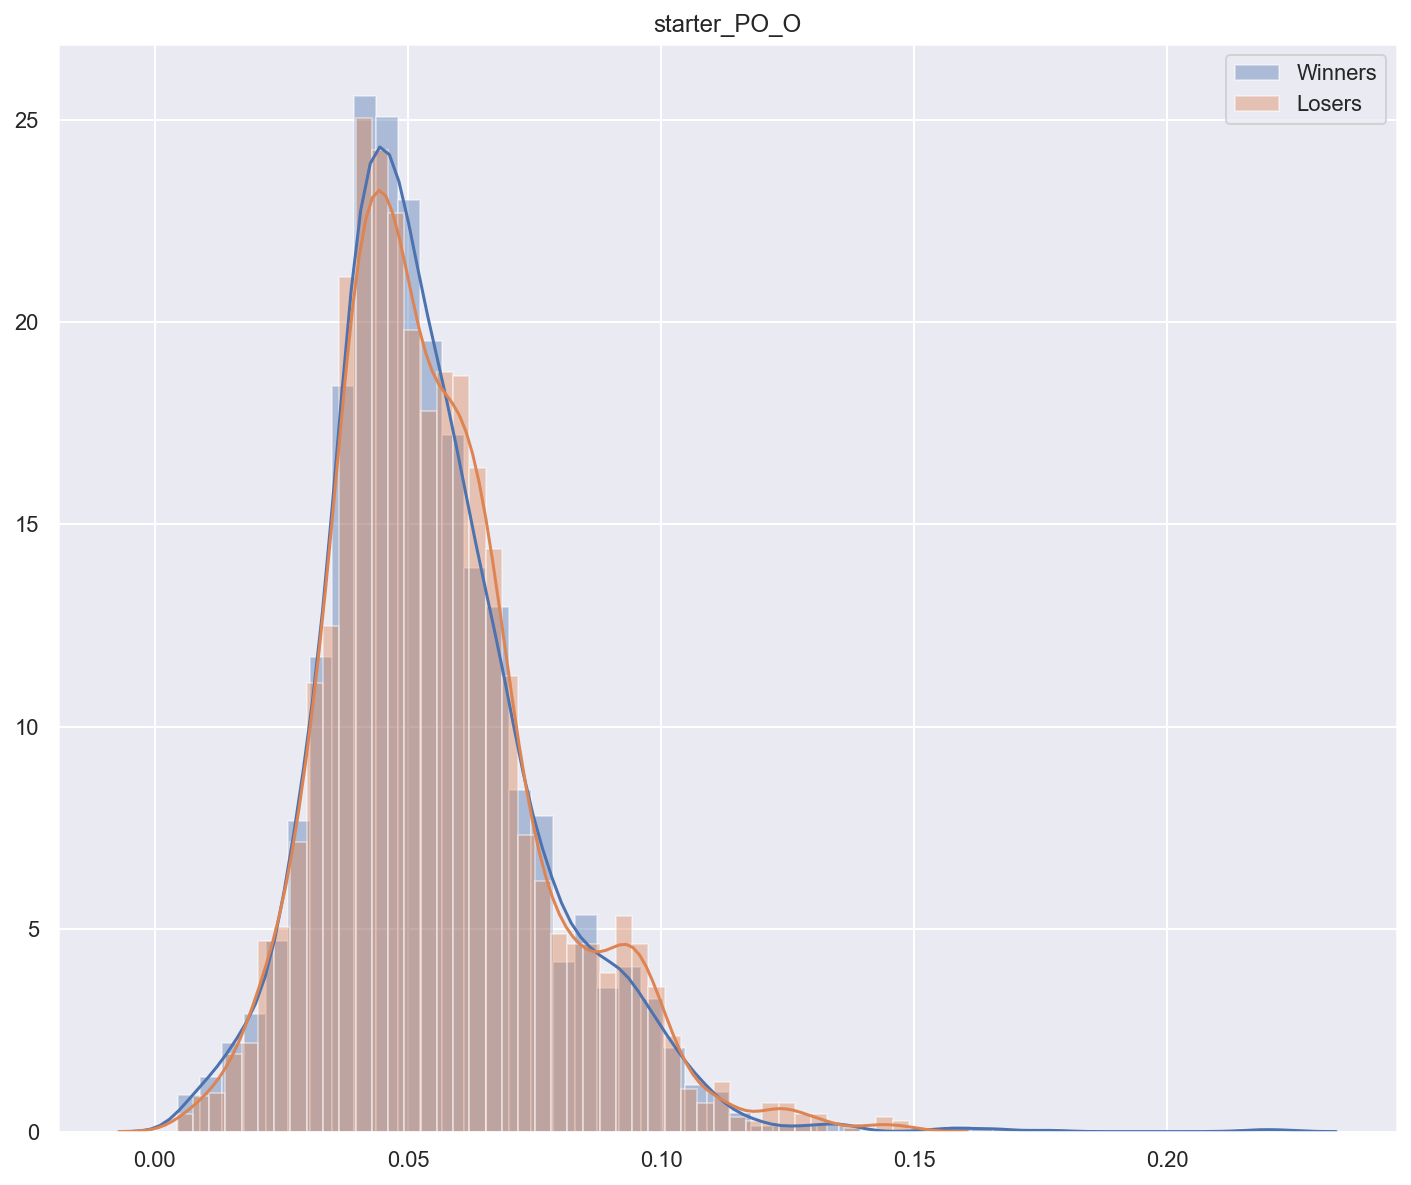

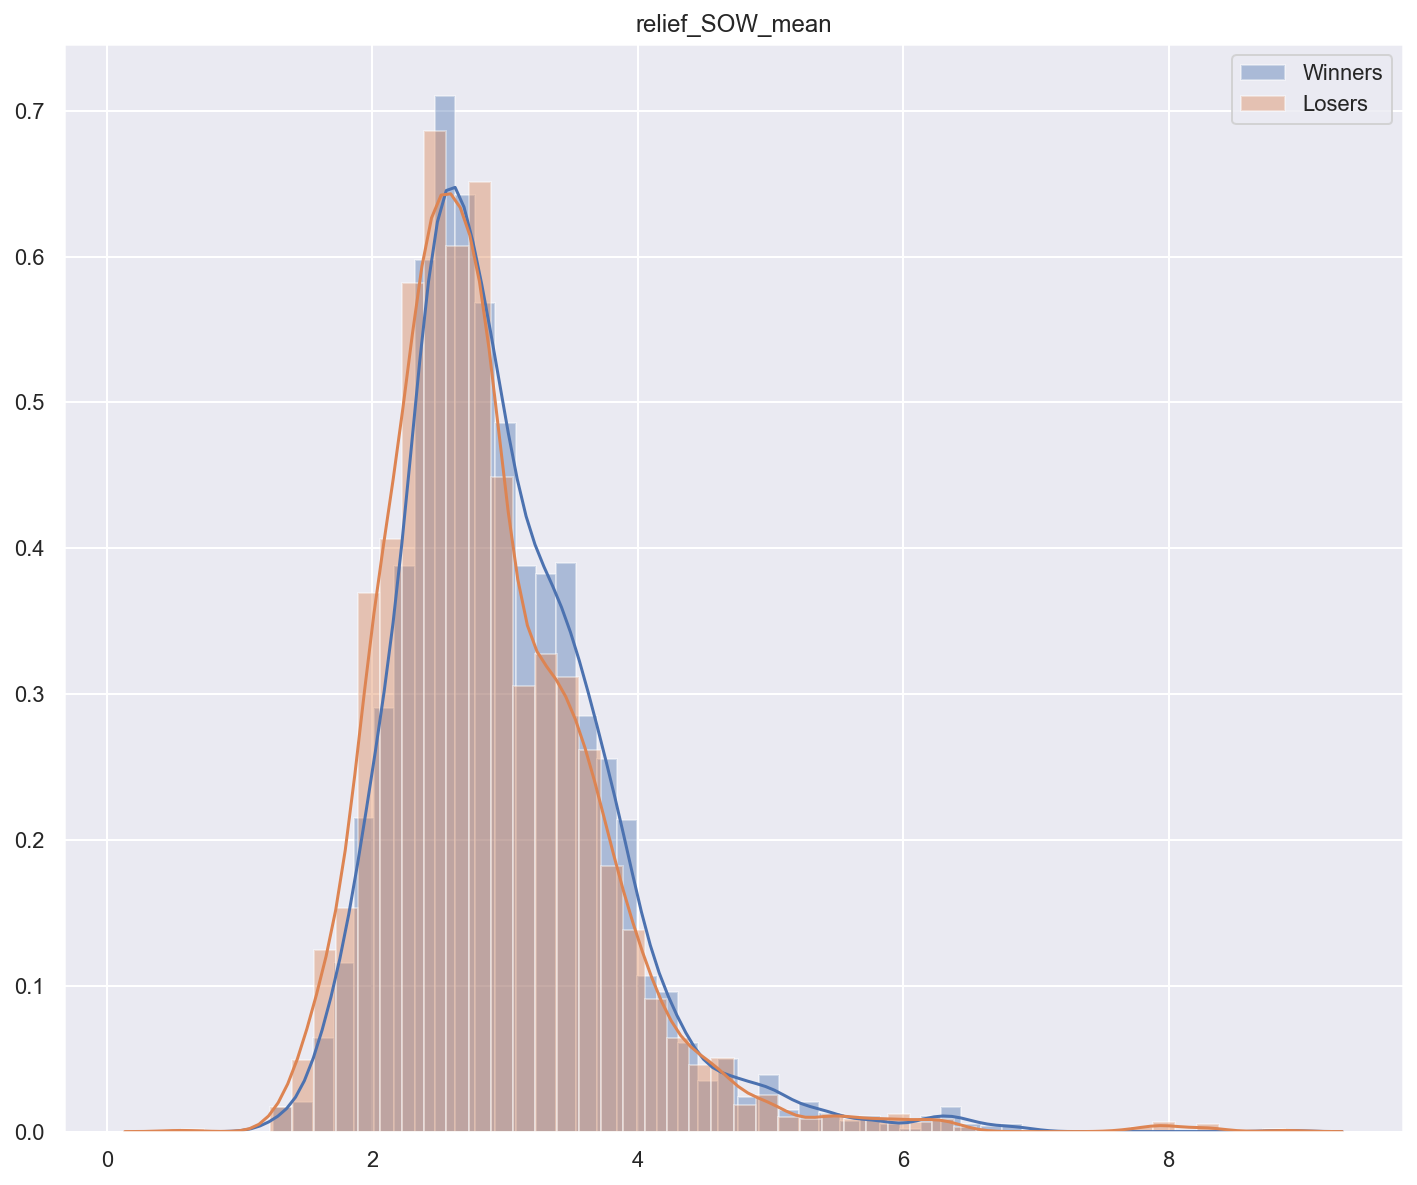

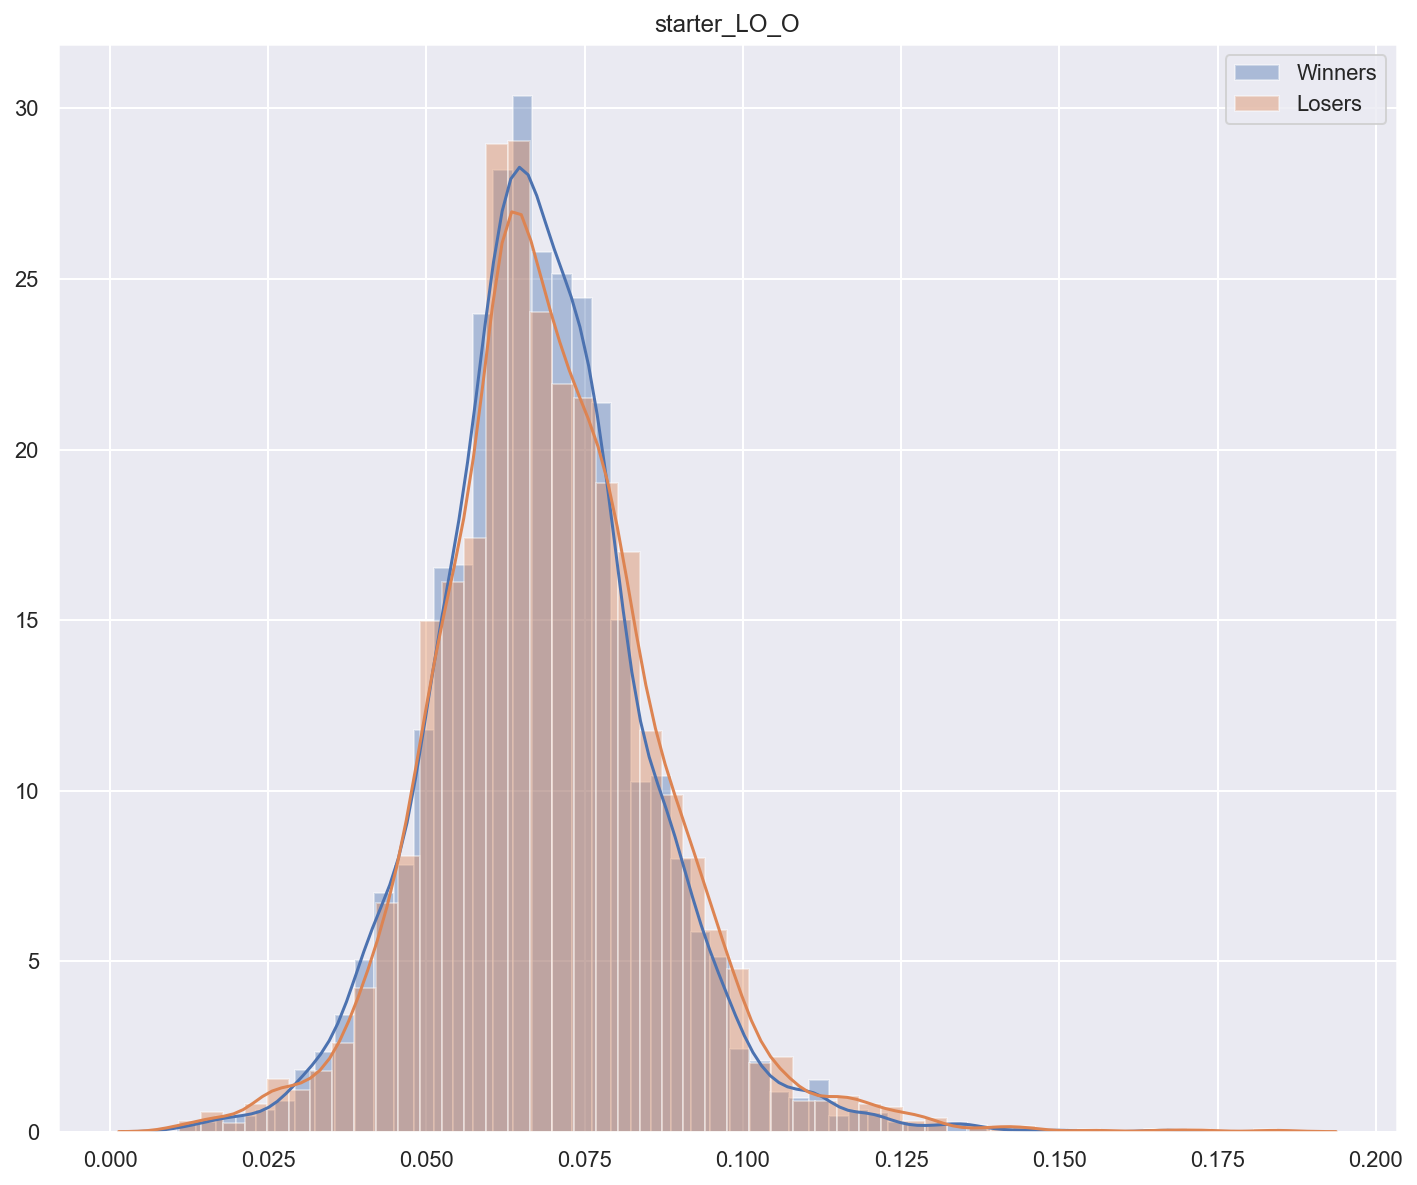

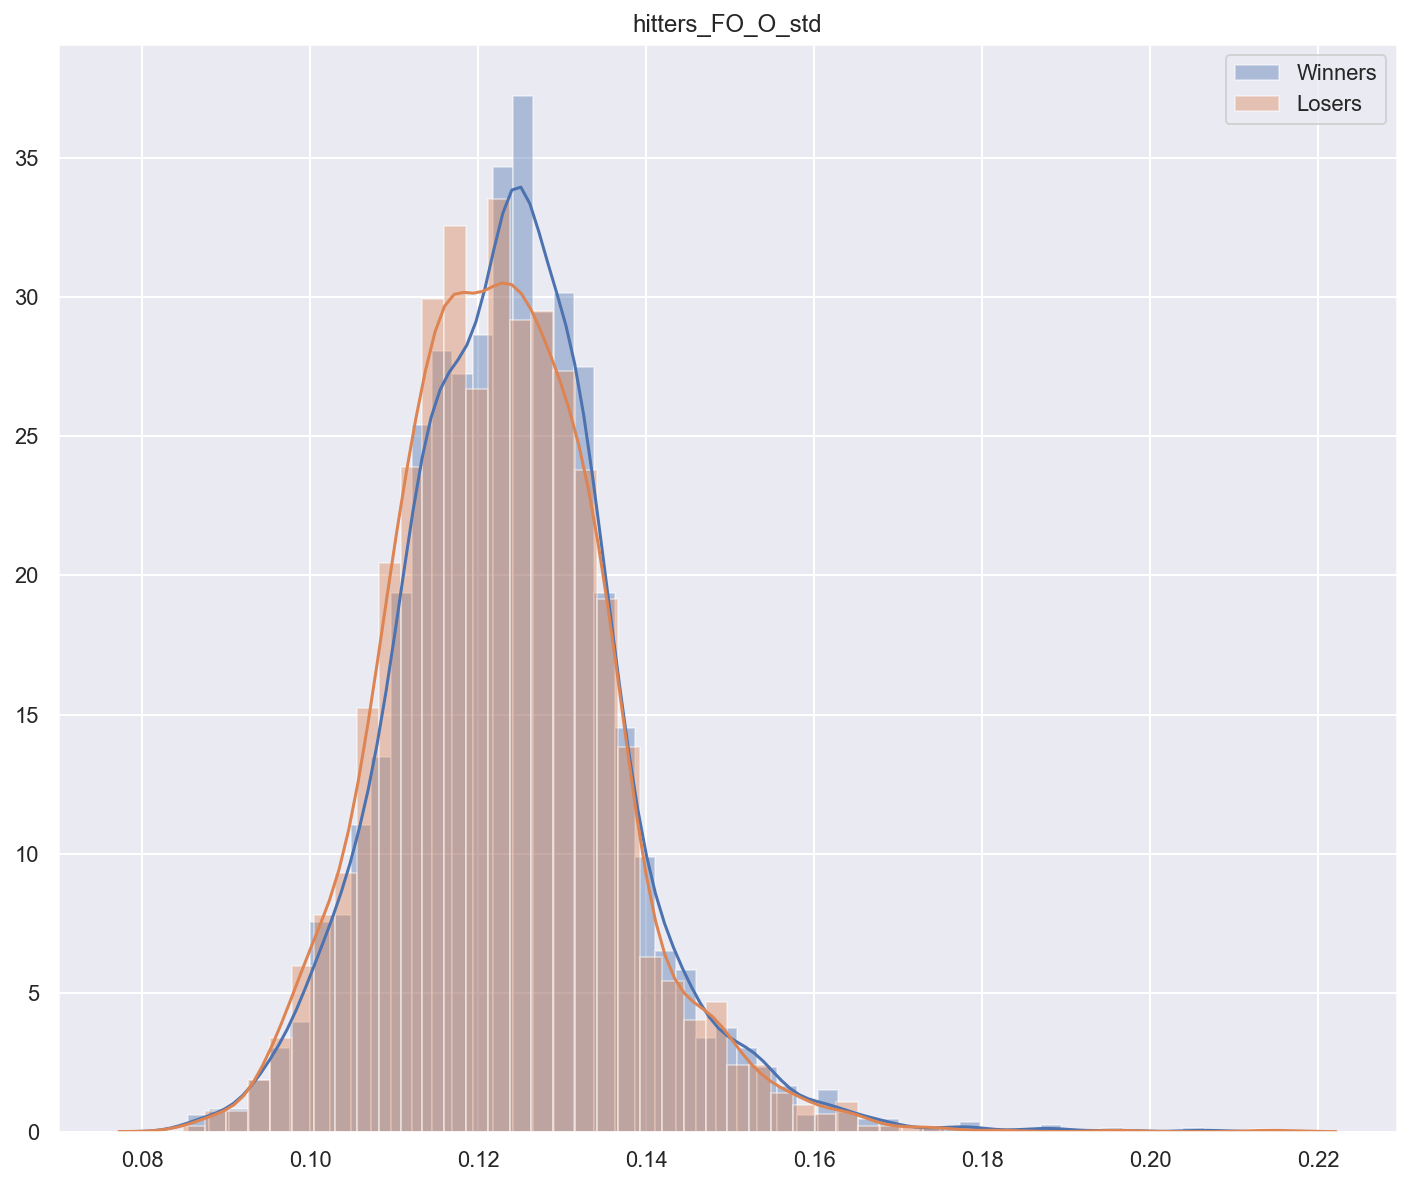

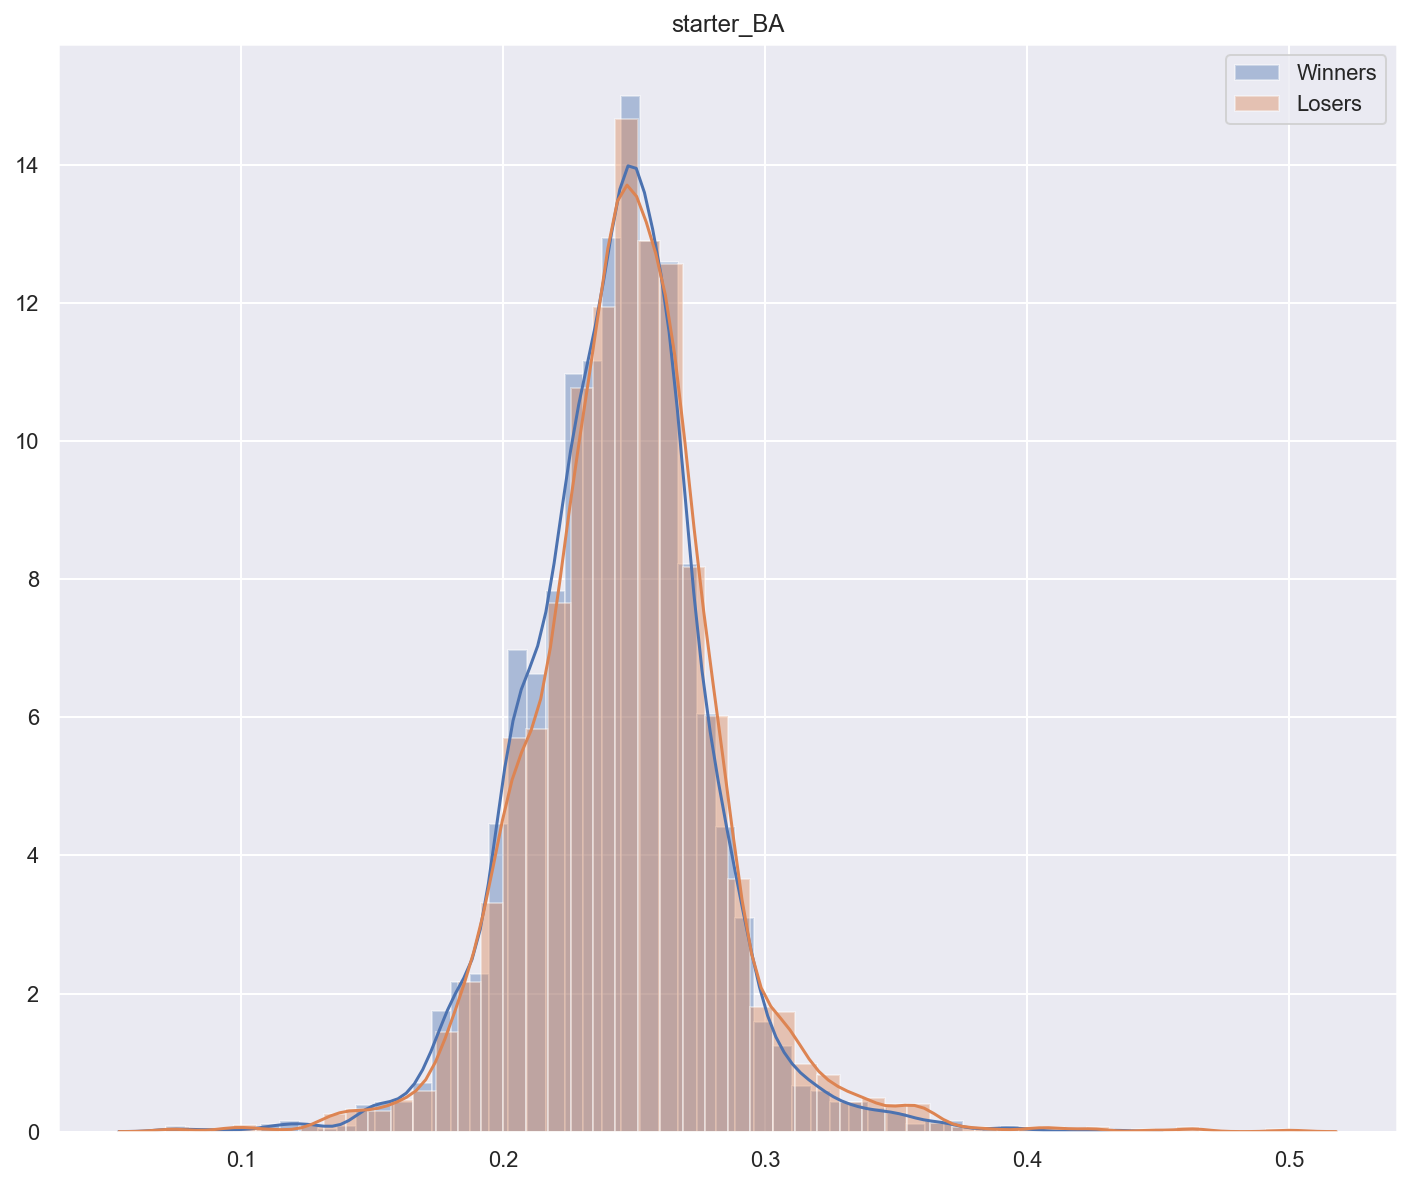

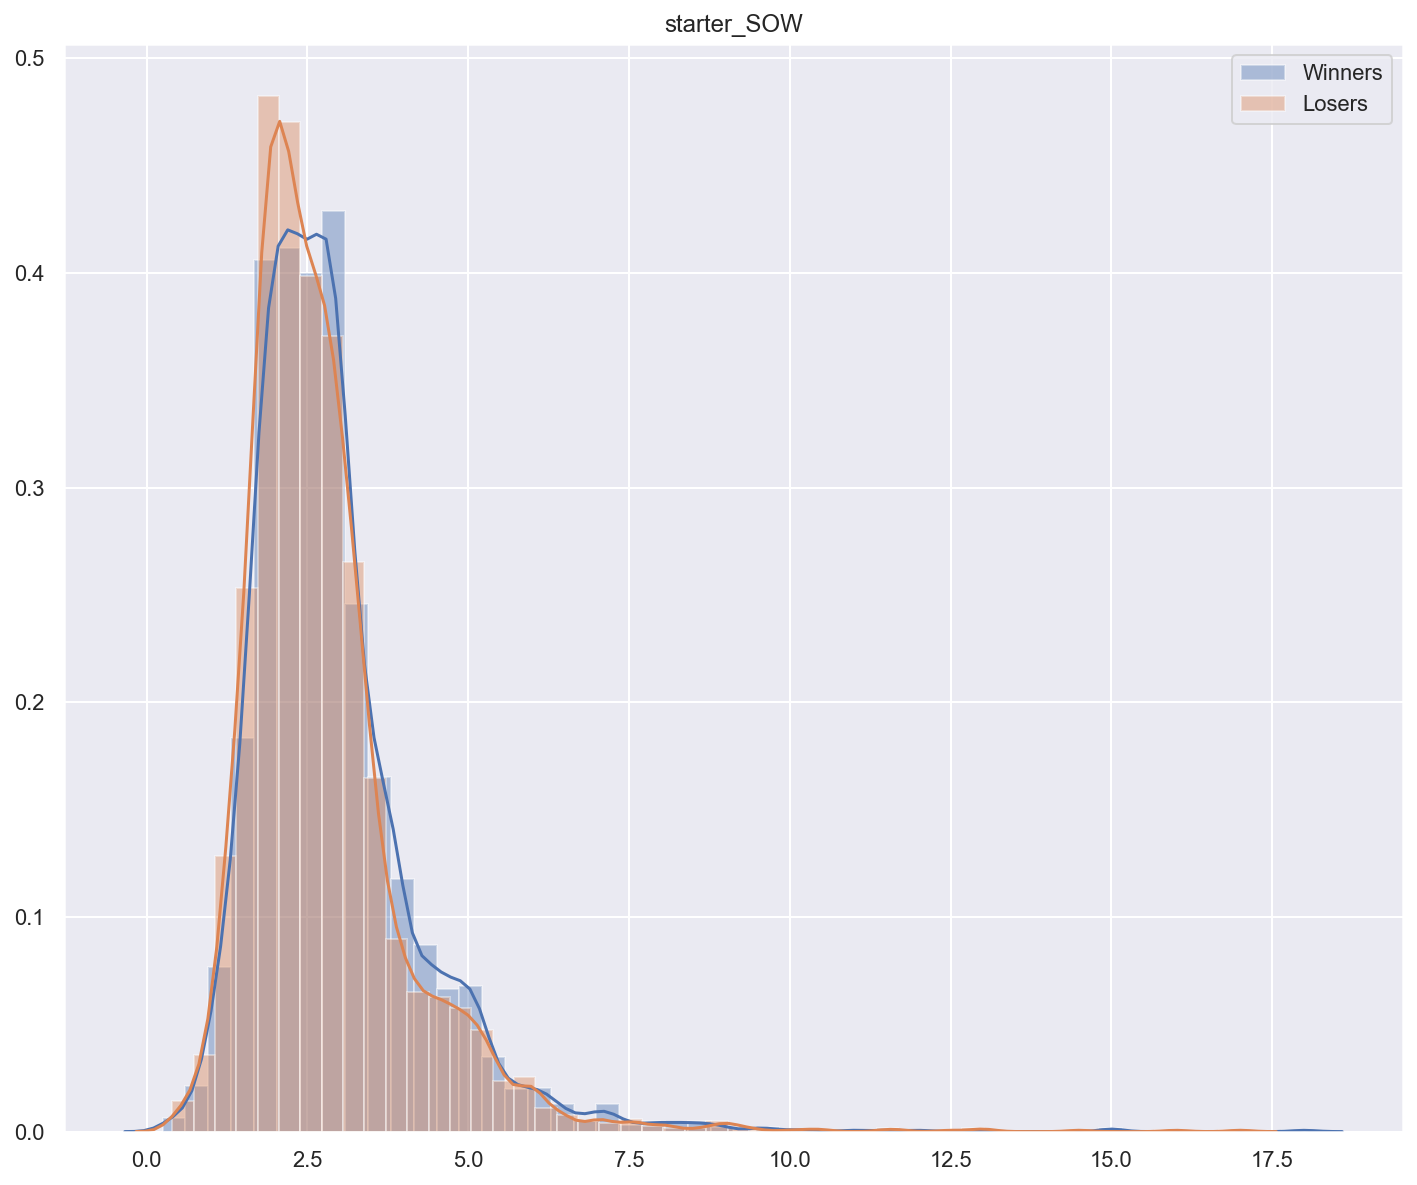

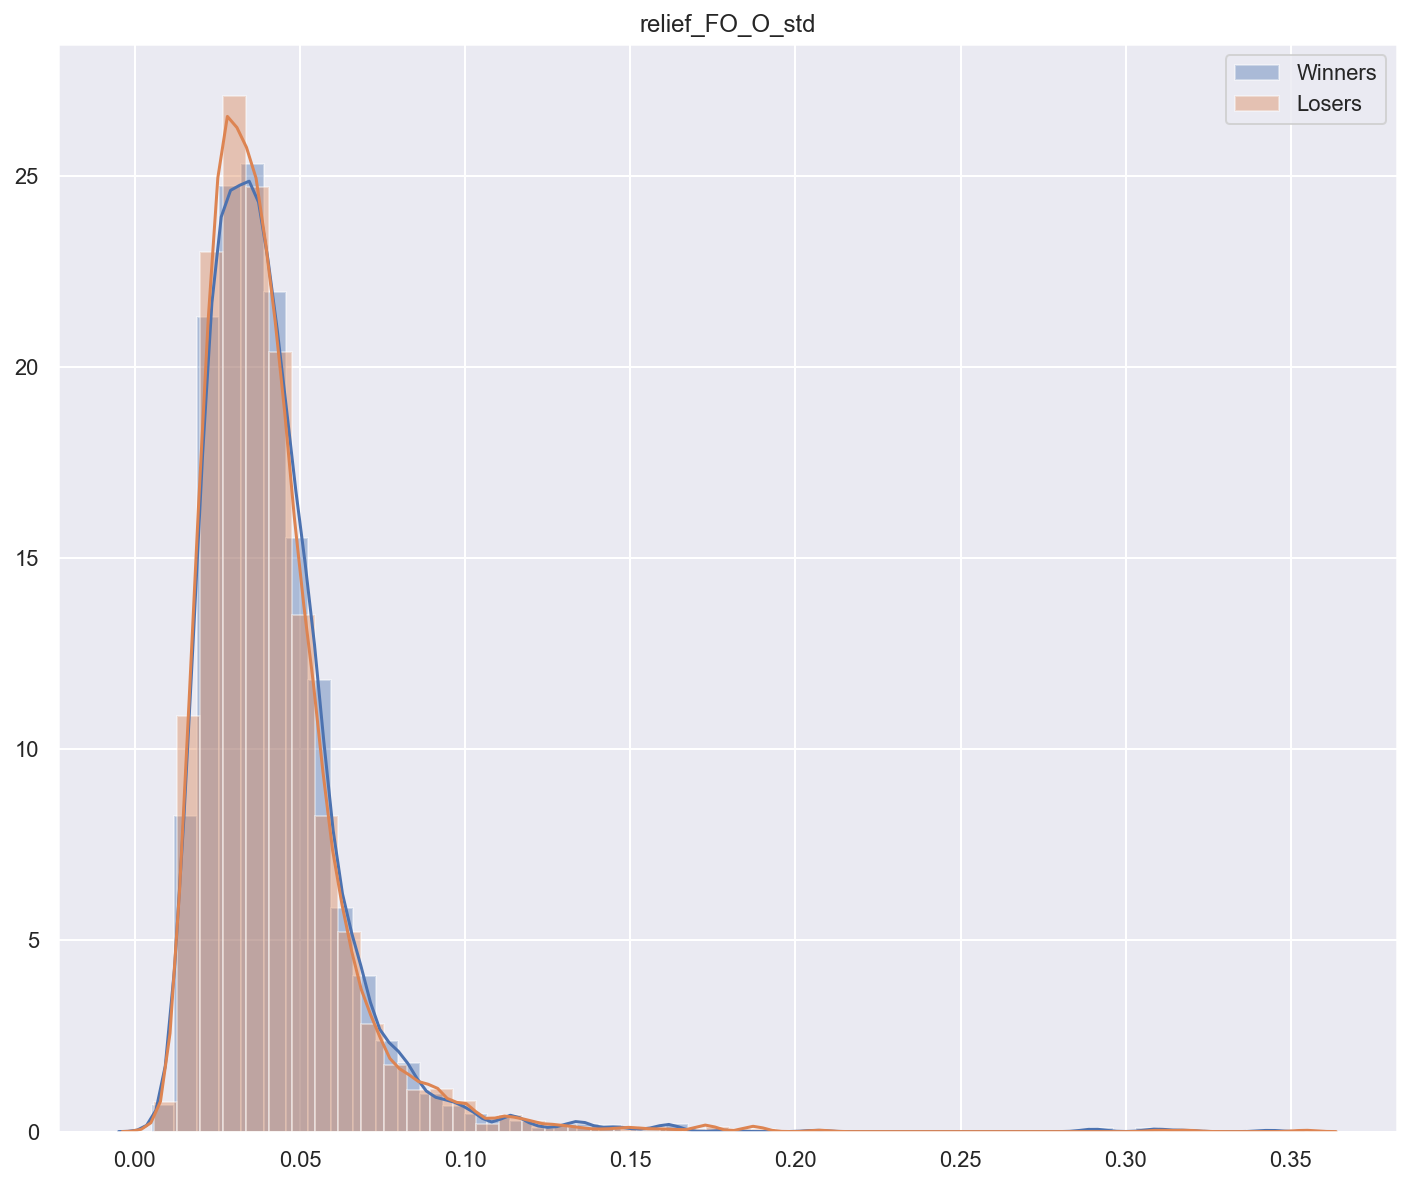

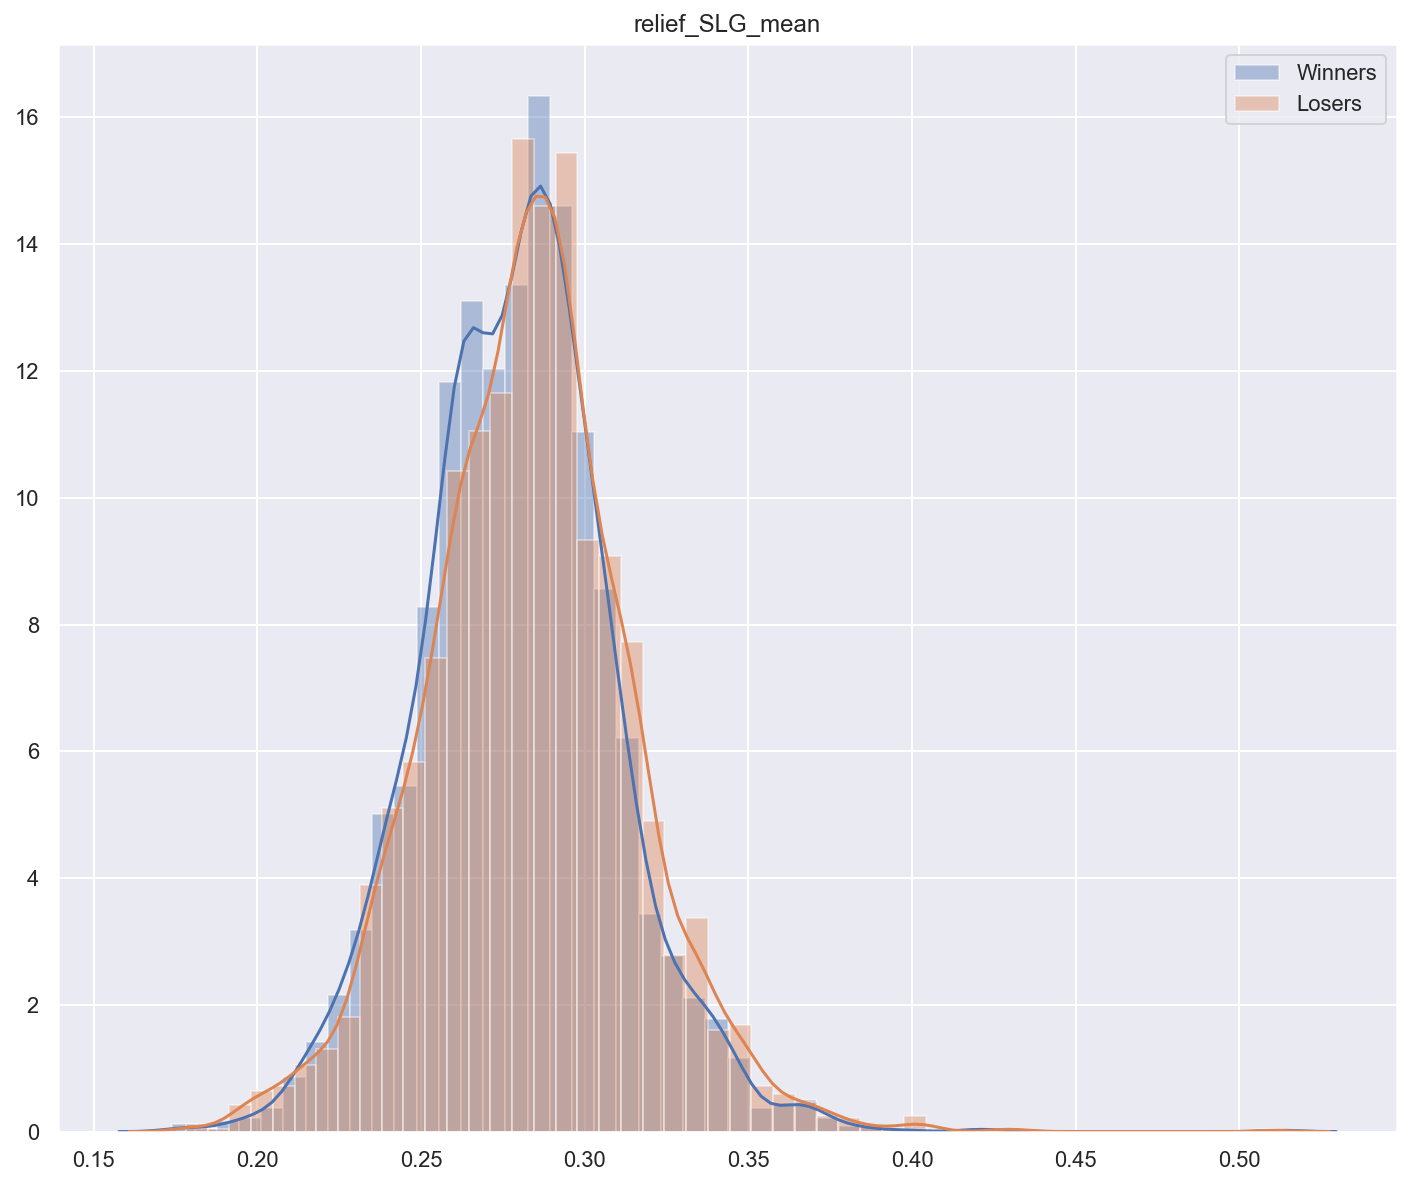

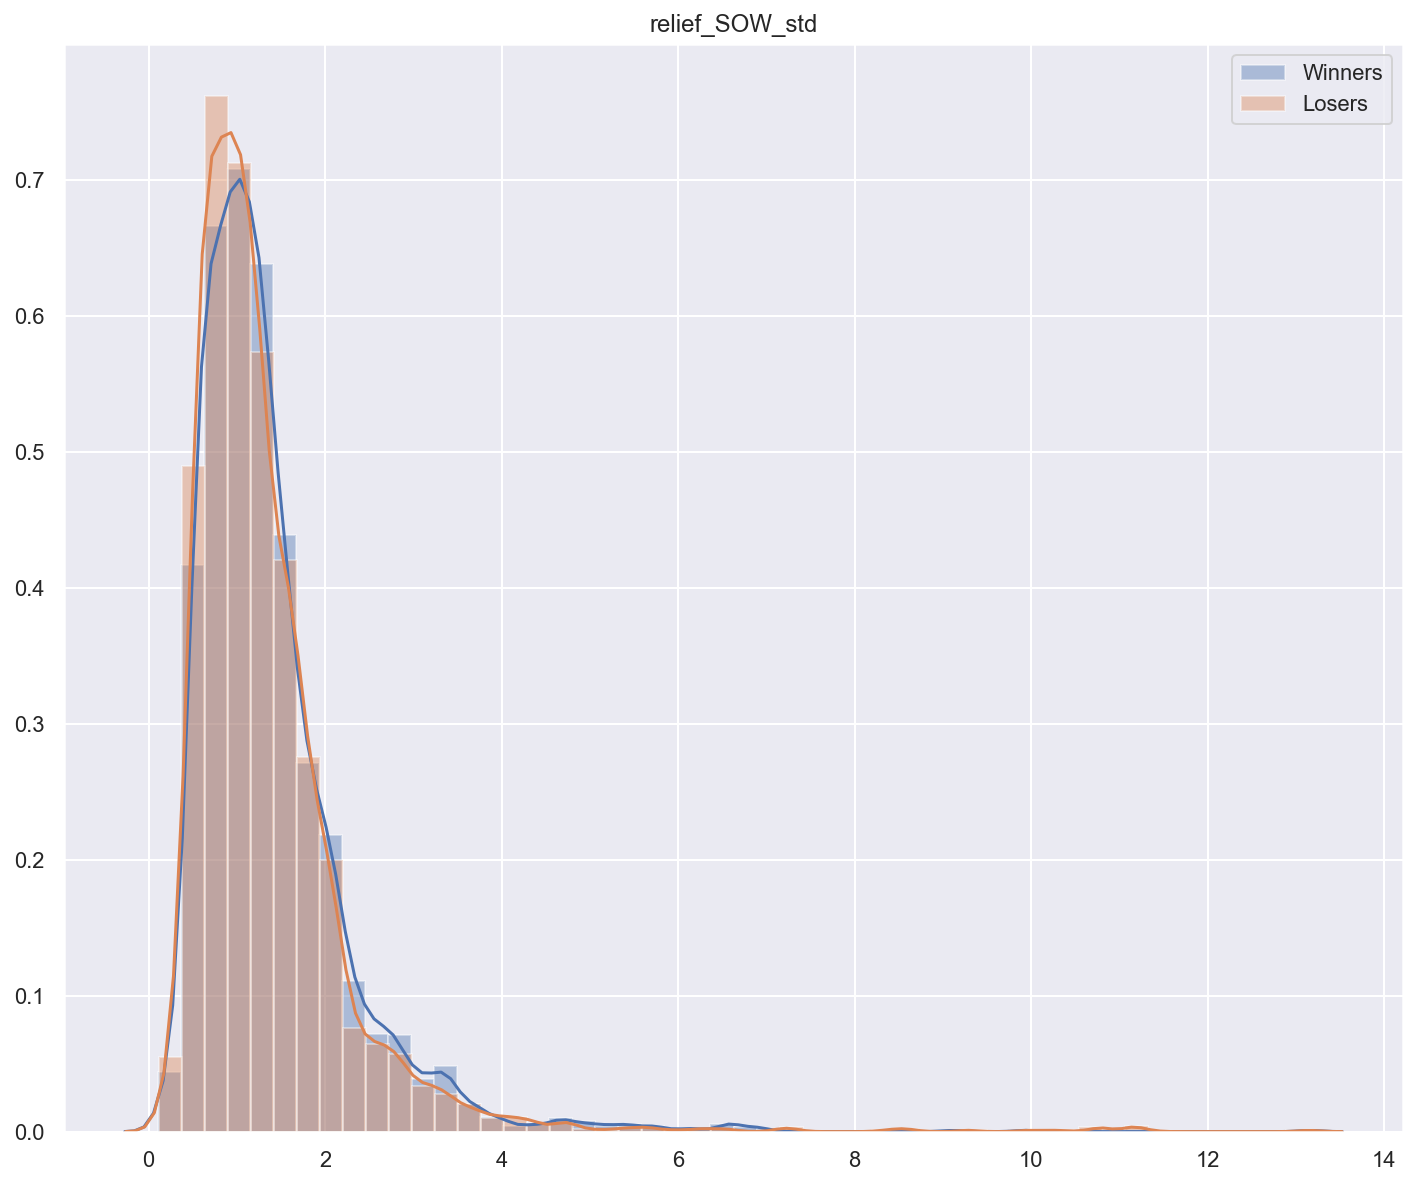

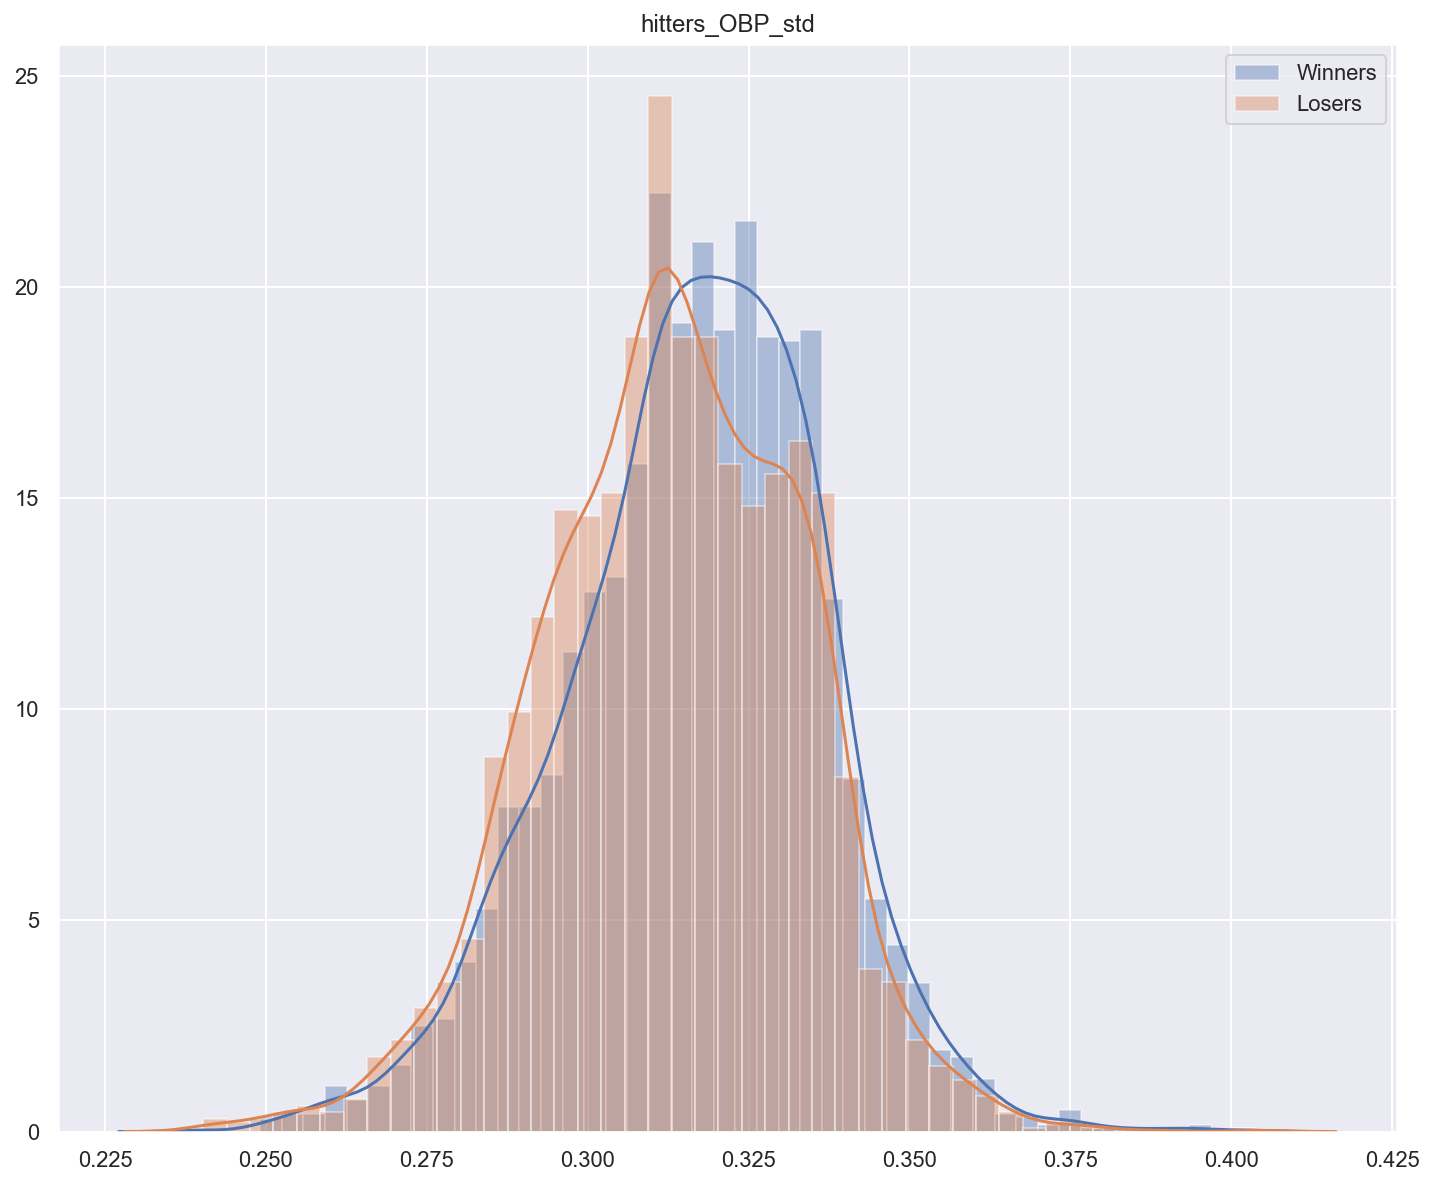

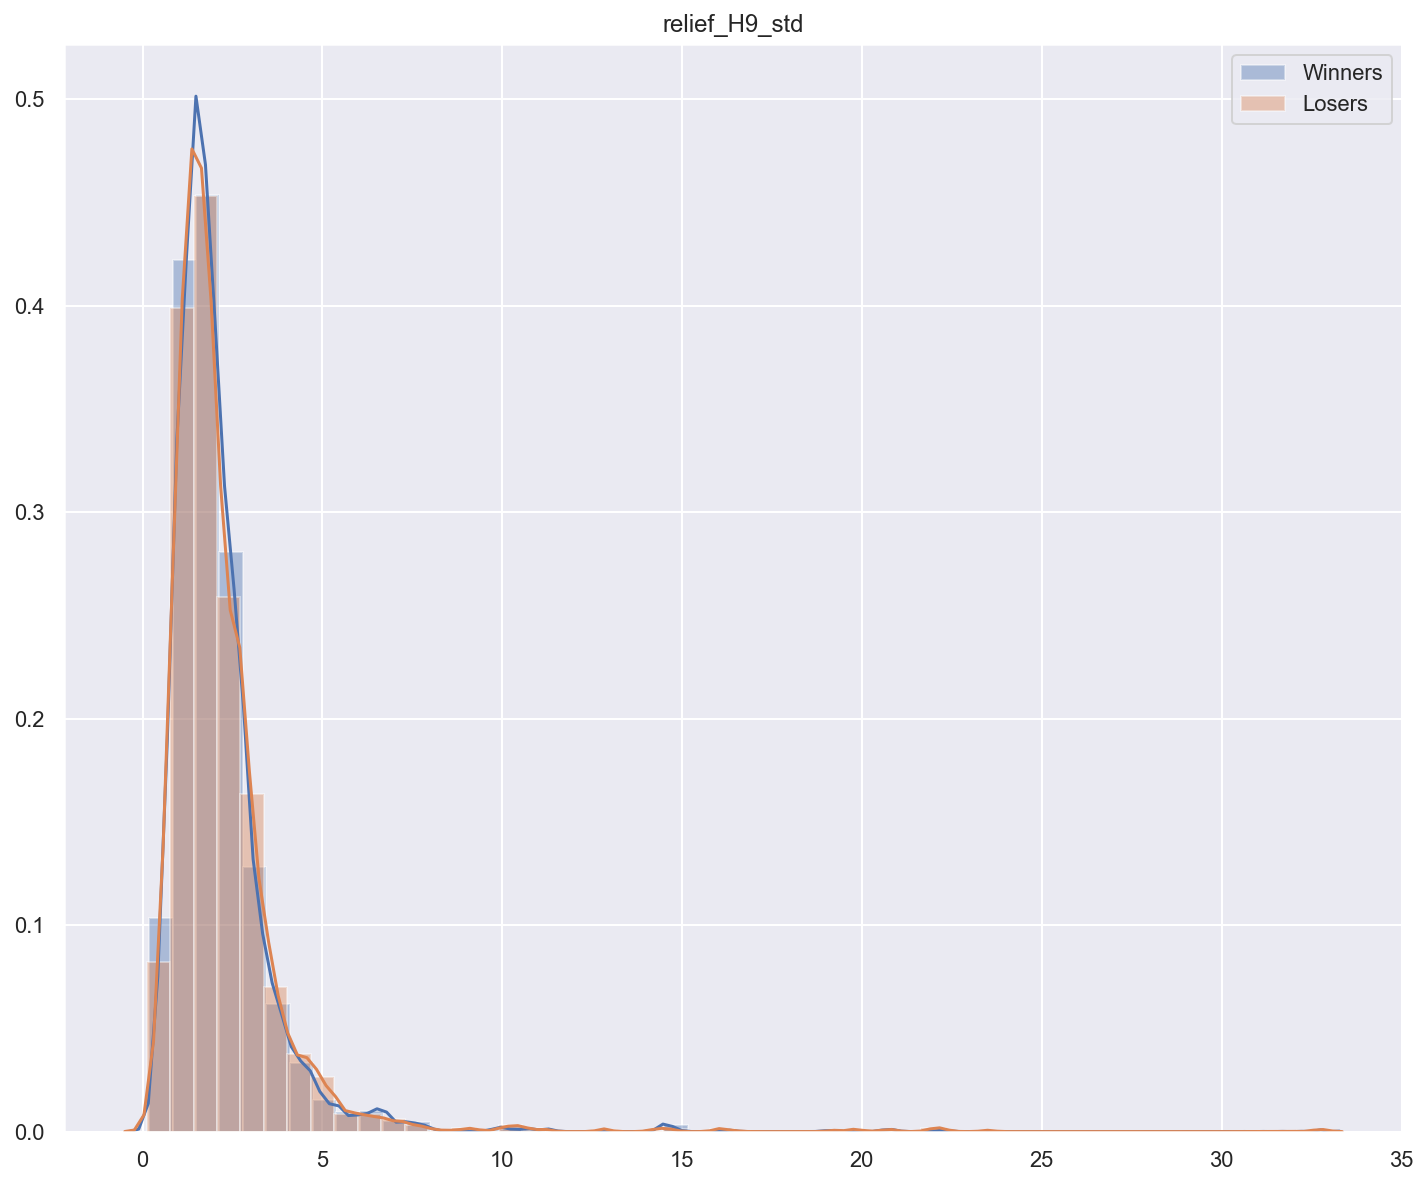

In [155]:
compare_stat_distro(stats)

In [85]:
#compare_stat_distro(['hitters_OBP_mean'])

In [86]:
def player_curr_avgs(session,person_record):
    most_recent_game=session.query(Game).order_by(Game.dateTime.desc()).first()
    player=person_record.relevant_stats(most_recent_game,session)
    player_dict={}
    if player['games']==0:
        player['games']=-1
    player_dict['position'] = player['Position_type']

    player_dict['PA_per_Game'] = player['PA']/player['games']

    try:
        player_dict['BA'] = player['hits']/player['AB']
    except ZeroDivisionError:
        player_dict['BA']=0

    try:
        player_dict['OBP'] = (
                                (player['hits']+player['walks']+player['HBP']+player['IBB'])
                                /
                                (player['AB']+player['walks']+player['HBP']+player['IBB']+player['sac'])
                              )
    except ZeroDivisionError:
        player_dict['OBP']=0

    try:
        player_dict['SLG'] = (
                                ((player['singles']*1)+(player['doubles']*2)+
                                (player['triples']*1)+(player['home_runs']*1))
                                /
                                (player['AB'])
                              )
    except ZeroDivisionError:
        player_dict['SLG']=0

    if player['walks']+player['HBP']>0:
        player_dict['SOW'] = player['strikeouts']/(player['walks']+player['HBP'])
    else:
        player_dict['SOW'] = 0

    try:
        player_dict['H9'] = 9*player['hits']/player['IP']
        player_dict['HR9'] = 9*player['home_runs']/player['IP']
        player_dict['SO9'] = 9*player['strikeouts']/player['IP']
        player_dict['WHIP'] = player['walks']+player['HBP']+player['hits']/player['IP']
    except (ZeroDivisionError,KeyError):
        player_dict['H9'] = 0
        player_dict['HR9'] = 0
        player_dict['SO9'] = 0
        player_dict['WHIP'] = 0

    # proportion of groundouts, flyouts, popouts, lineouts to ABs
    if player['AB']>0:
        player_dict['GO_O'] = player['GO']/player['AB']
        player_dict['FO_O'] = player['FO']/player['AB']
        player_dict['PO_O'] = player['PO']/player['AB']
        player_dict['LO_O'] = player['LO']/player['AB']
    else:
        player_dict['GO_O'] = 0
        player_dict['FO_O'] = 0
        player_dict['PO_O'] = 0
        player_dict['LO_O'] = 0
    return player_dict

In [25]:
anderson=session.query(Person).filter(Person.fullName=='Tim Anderson').one()
anderson_avgs=player_curr_avgs(session,anderson)

anderson_avgs['OBP']

In [103]:
def get_currentAverages_byName(player_name,rollback=True):
    if rollback:
        session.rollback()
    try:
        player=session.query(Person).filter(Person.fullName==player_name).one()
    except:
        return 'player not found'
    current_averages=player_curr_avgs(session,player)
    return current_averages



In [104]:
trout_avgs=get_currentAverages_byName('Mike Trout')

In [105]:
trout_avgs

{'position': 'Outfielder',
 'PA_per_Game': 4.408759124087592,
 'BA': 0.29968119022316686,
 'OBP': 0.44739022369511183,
 'SLG': 0.3517534537725824,
 'SOW': 1.1141552511415524,
 'H9': 0,
 'HR9': 0,
 'SO9': 0,
 'WHIP': 0,
 'GO_O': 0.1126461211477152,
 'FO_O': 0.15621679064824653,
 'PO_O': 0.06057385759829968,
 'LO_O': 0.06801275239107332}

In [106]:
trout_avgs['OBP']

0.44739022369511183

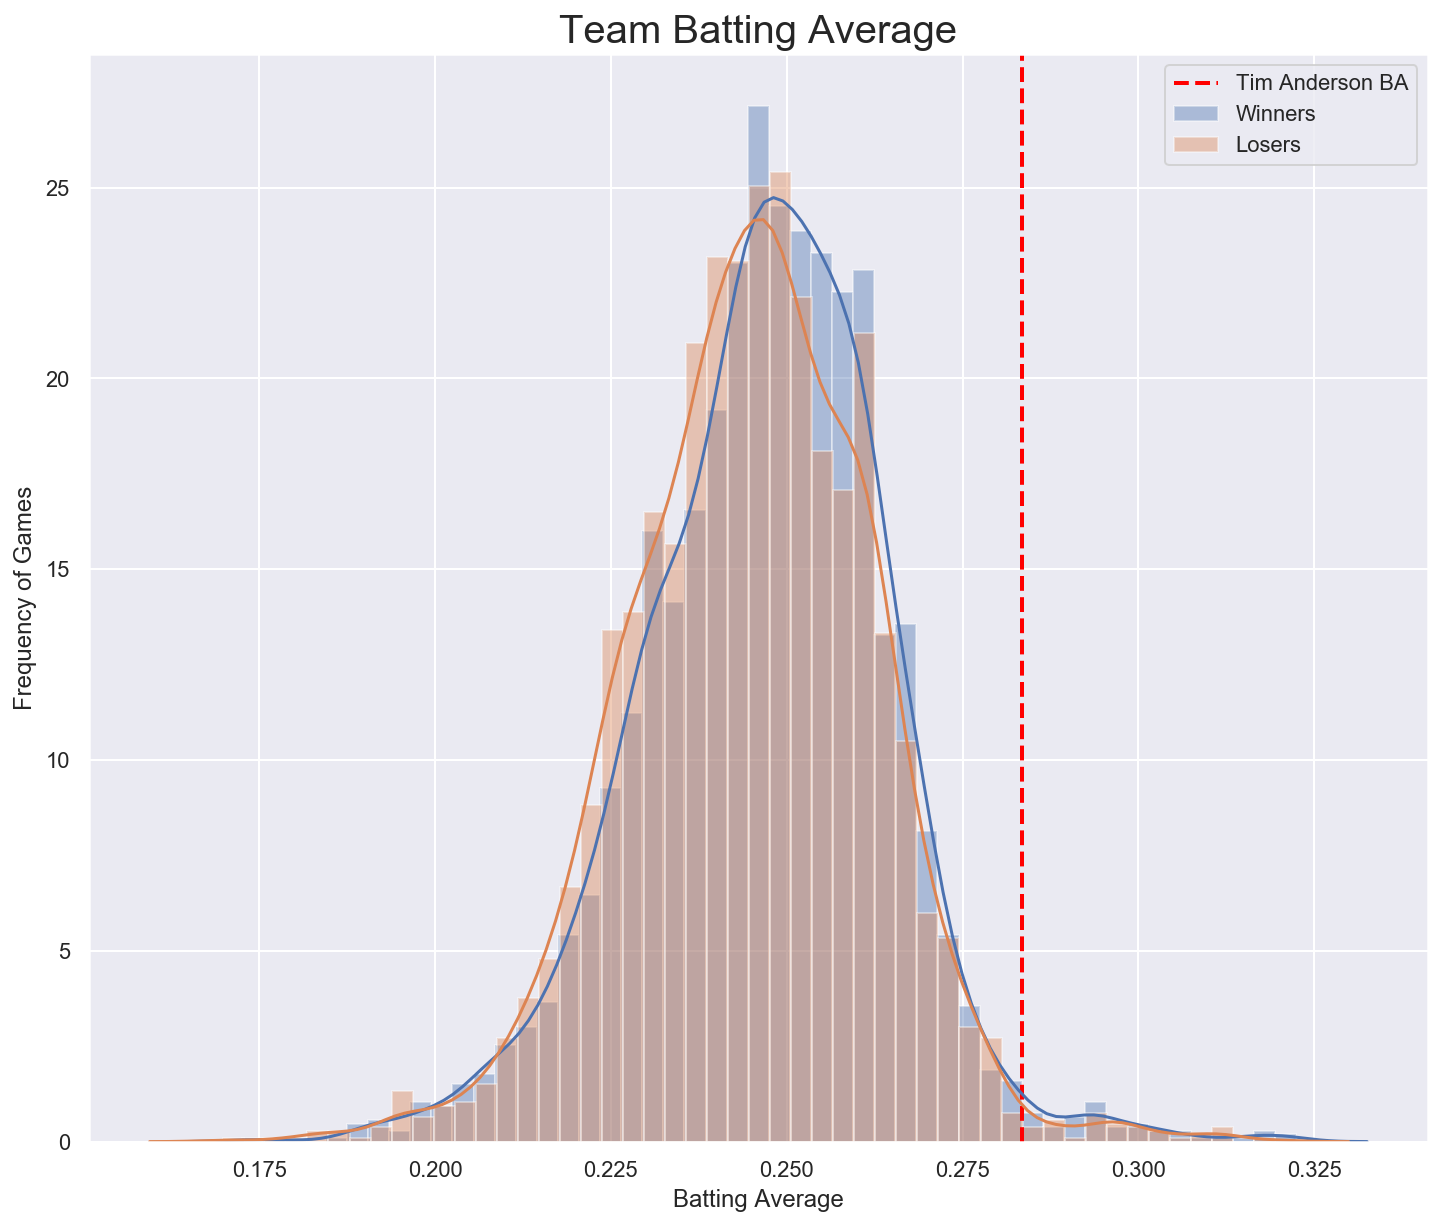

In [112]:
pd.options.mode.chained_assignment=None
compare_stat_distro(
    ['hitters_BA_mean'],
    reference_line={'x_axis':anderson_avgs['BA'],'label':'Tim Anderson BA'},
    file_name=image_dir+'batting_average.jpg',
    title='Team Batting Average',
    x_axis_label='Batting Average',
    y_axis_label='Frequency of Games')

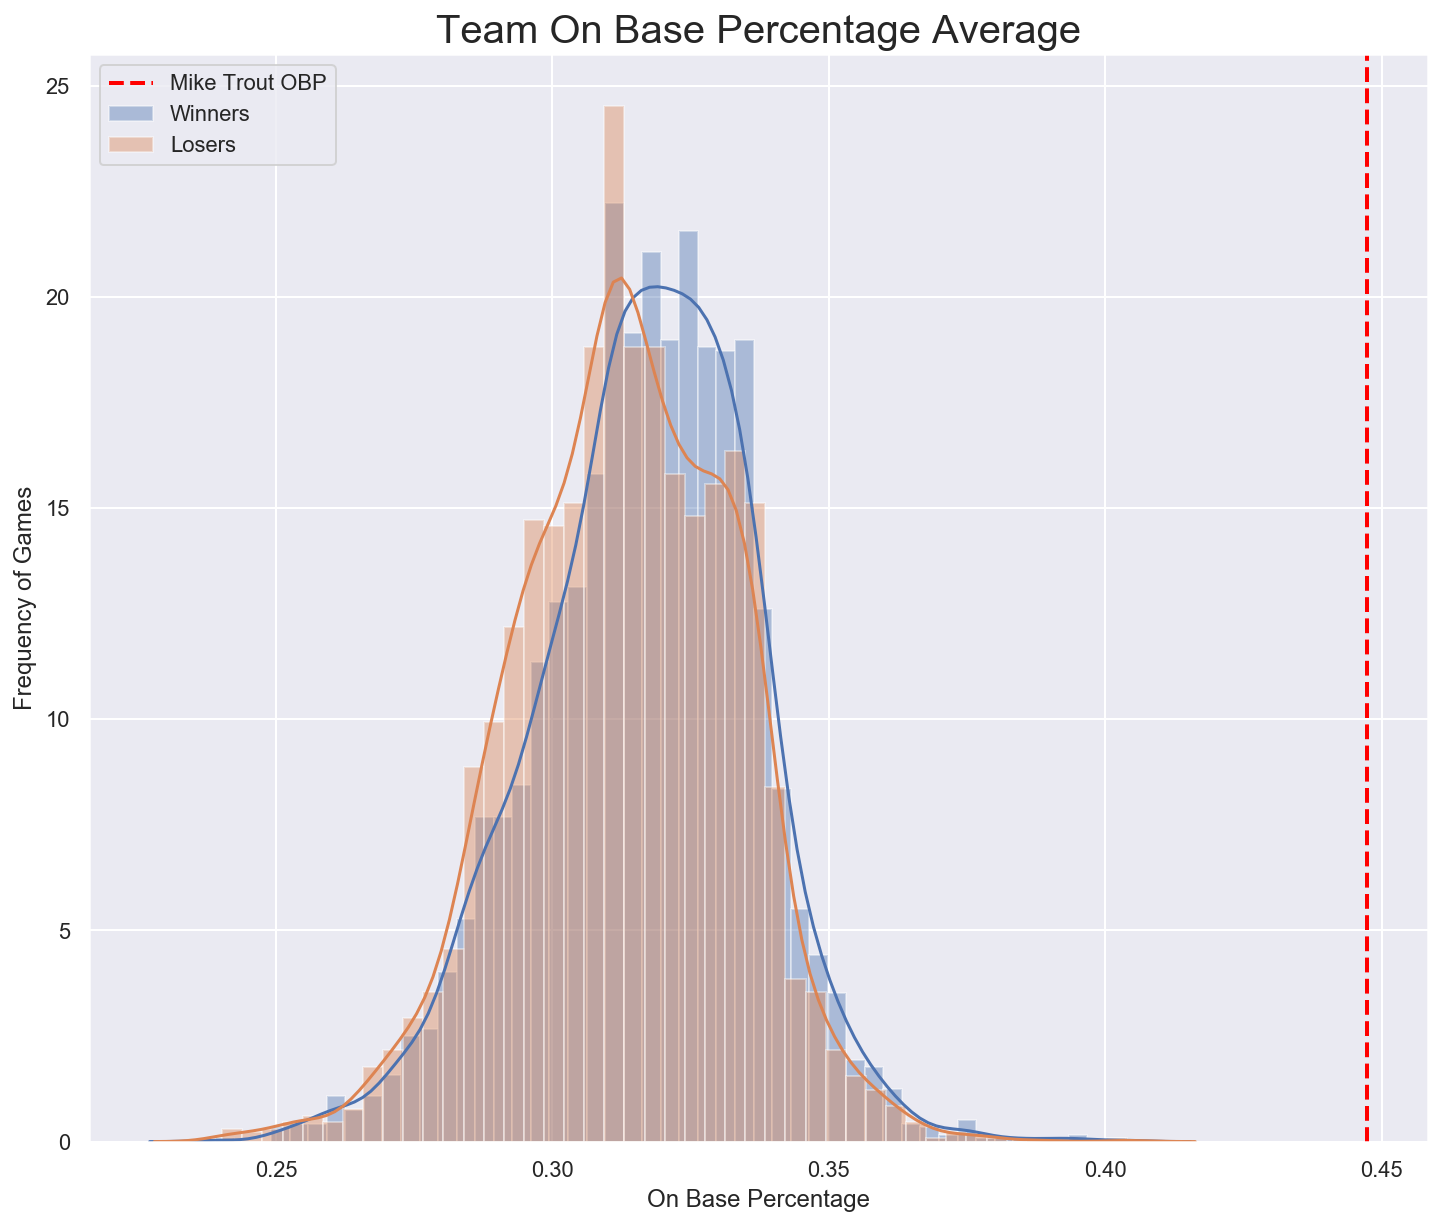

In [113]:
compare_stat_distro(
    ['hitters_OBP_mean'],
    reference_line={'x_axis':trout_avgs['OBP'],'label':'Mike Trout OBP'},
    file_name=image_dir+'on_base.jpg',
    title='Team On Base Percentage Average',
    x_axis_label='On Base Percentage',
    y_axis_label='Frequency of Games')

In [117]:
session.rollback()

In [118]:
jacob_degrom = session.query(Person).filter(Person.fullName=='Jacob Degrom').one()

In [131]:
jd_relevantStats=jacob_degrom.relevant_stats(most_recent_game,session)

In [148]:
JD=pd.DataFrame(get_currentAverages_byName('Jacob Degrom'),index=['jacob degrom'])

In [149]:
JD

position  PA_per_Game        BA       OBP       SLG  \
jacob degrom  Pitcher_starter    25.703125  0.200393  0.248024  0.236411   

                   SOW        H9       HR9        SO9       WHIP      GO_O  \
jacob degrom  5.336735  6.578025  0.623408  11.242834  98.730892  0.188605   

                  FO_O      PO_O      LO_O  
jacob degrom  0.099542  0.060904  0.054355

In [137]:
RA=pd.DataFrame(get_currentAverages_byName('Ronald Acuna Jr.'),index=['Ronald Acuna Jr.'])
OA=pd.DataFrame(get_currentAverages_byName('Ozzie Albies'),index=['Ozzie Albies'])

In [139]:
braves = pd.concat([RA,OA]).drop(columns=['H9','HR9','SO9','WHIP'])

In [150]:
braves

position  PA_per_Game        BA       OBP       SLG  \
Ronald Acuna Jr.  Outfielder     4.509363  0.284637  0.364696  0.329877   
Ozzie Albies       Infielder     4.388013  0.277259  0.327103  0.341900   

                       SOW      GO_O      FO_O      PO_O      LO_O  
Ronald Acuna Jr.  2.392308  0.151744  0.124411  0.037700  0.058435  
Ozzie Albies      2.451613  0.196262  0.166667  0.056854  0.077882

In [141]:
AC=pd.DataFrame(get_currentAverages_byName('Aroldis Chapman'),index=['Aroldis Chapman'])
ZB=pd.DataFrame(get_currentAverages_byName('Zack Britton'),index=['Zack Britton'])

In [145]:
yankees_relievers = pd.concat([AC,ZB])

In [152]:
yankees_relievers

position  PA_per_Game        BA       OBP       SLG  \
Aroldis Chapman  Pitcher_relief     3.895652  0.161880  0.275168  0.201044   
Zack Britton     Pitcher_relief     3.869159  0.189802  0.299517  0.218130   

                      SOW        H9       HR9        SO9       WHIP      GO_O  \
Aroldis Chapman  2.918033  5.166667  0.416667  14.833333  61.574074  0.138381   
Zack Britton     1.553571  5.950658  0.532895   7.726974  56.661184  0.359773   

                     FO_O      PO_O      LO_O  
Aroldis Chapman  0.073107  0.046997  0.065274  
Zack Britton     0.036827  0.005666  0.033994

In [ ]:
ima

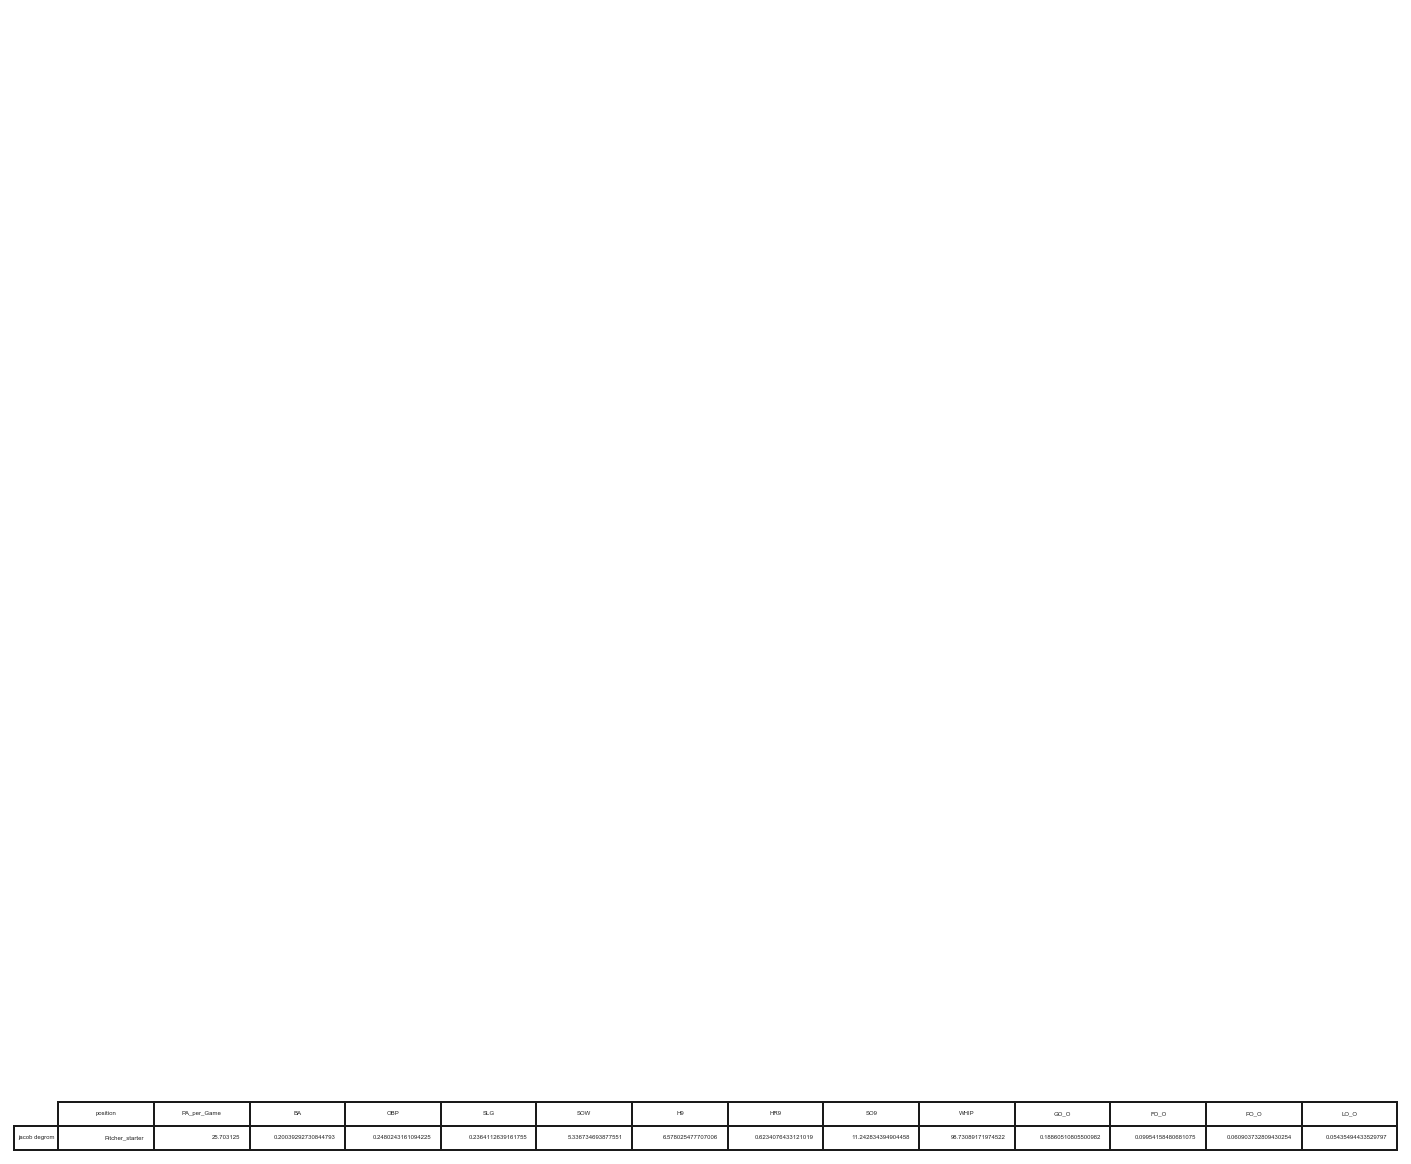

In [154]:
from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, JD)  # where df is your data frame
plt.show()
plt.savefig(image_dir+'degrom.png',orientation='landscape')

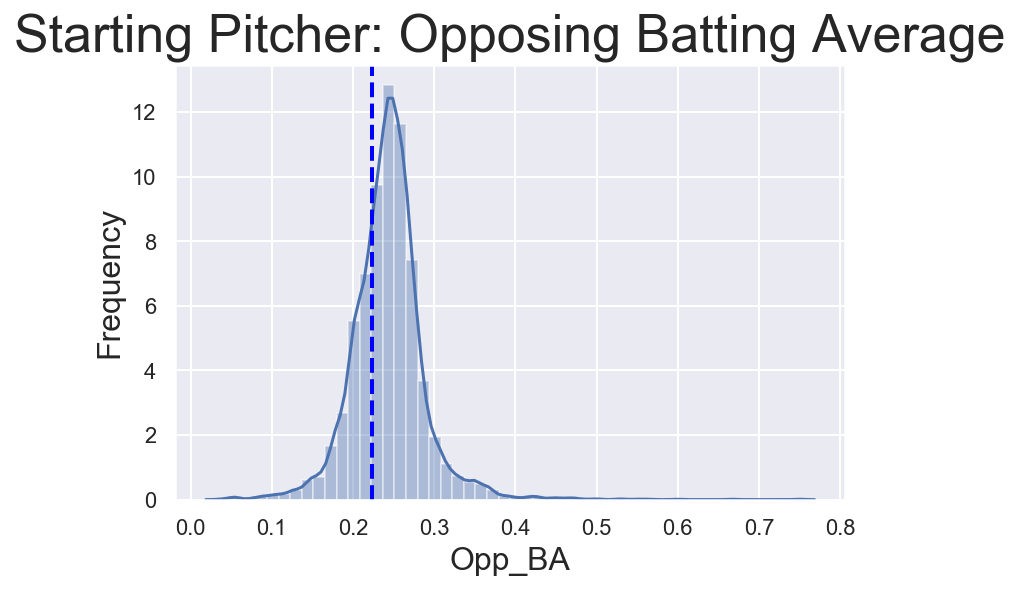

In [22]:
nonZero_homeStarterBa=[x for x in df['home_starter_BA'] if x>0]
nonZero_awayStarterBa=[x for x in df['away_starter_BA'] if x>0]
nonZero_starterBa=[item for sublist in [nonZero_awayStarterBa,nonZero_homeStarterBa] for item in sublist]

sns.distplot(nonZero_starterBa)
plt.title('Starting Pitcher: Opposing Batting Average',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBA.jpg')

plt.axvline(kershaw_avgs['BA'],color='blue', linestyle='--', lw=2)

plt.show()

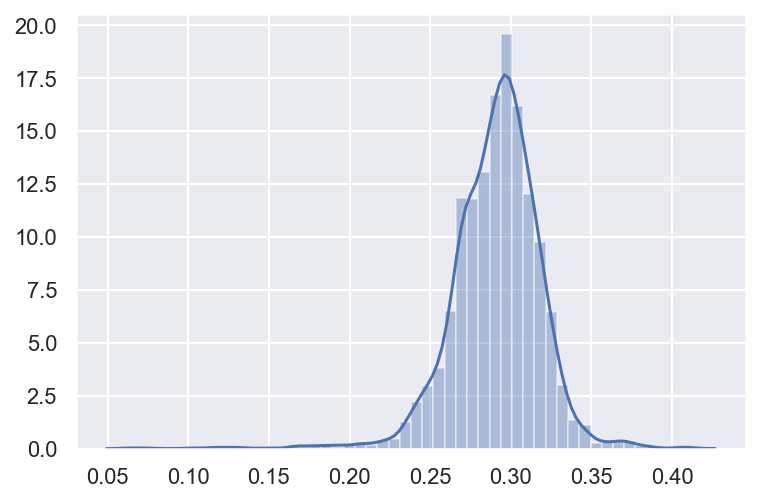

In [23]:
sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

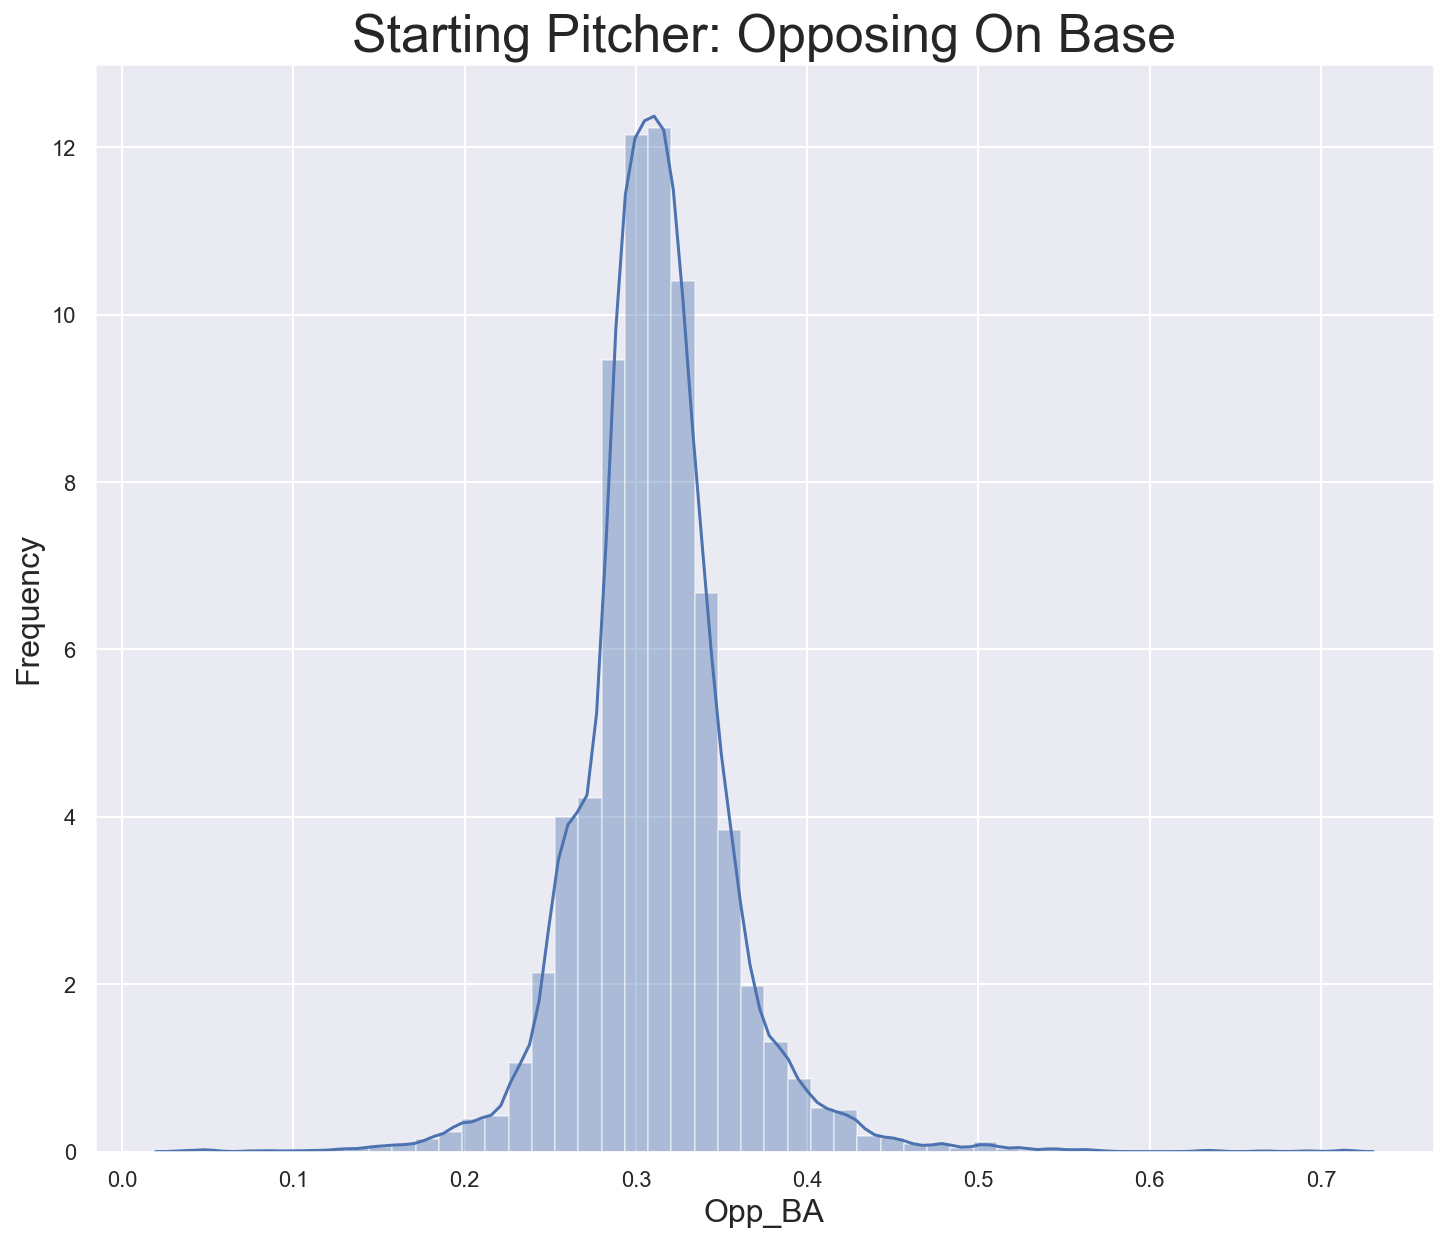

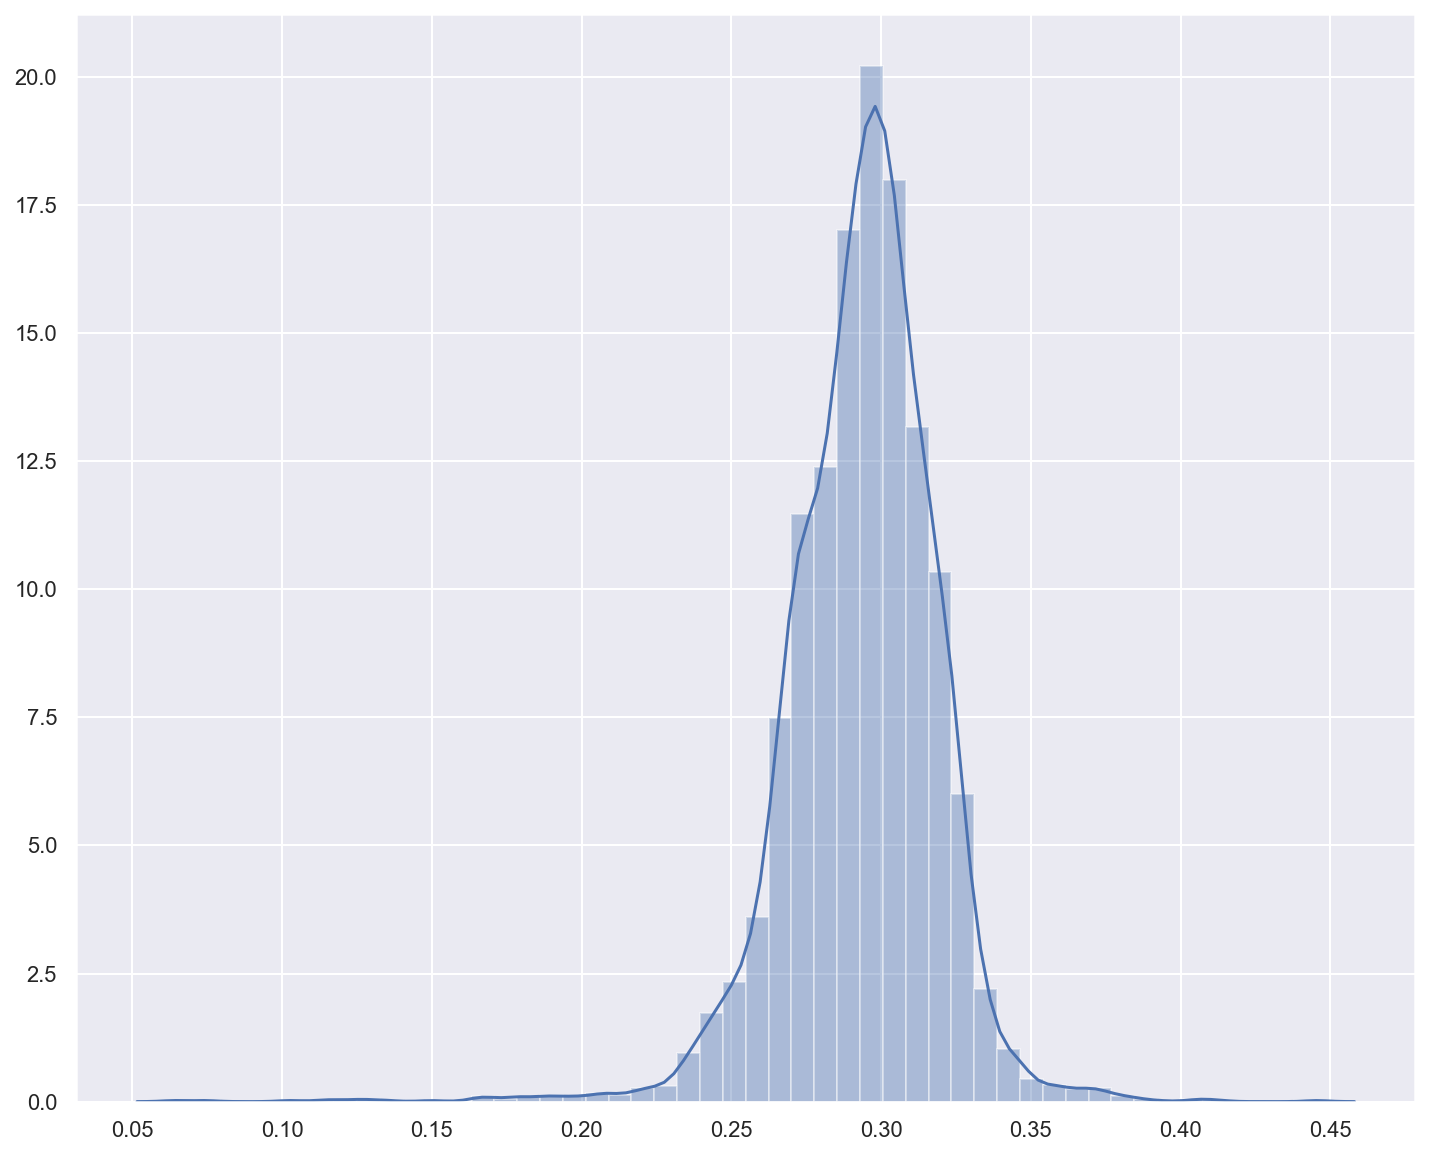

In [12]:
nonZero_homeStarterOBP=[x for x in df['home_starter_OBP'] if x>0]
nonZero_awayStarterOBP=[x for x in df['away_starter_OBP'] if x>0]
nonZero_starterOBP=[item for sublist in [nonZero_awayStarterOBP,nonZero_homeStarterOBP] for item in sublist]

sns.distplot(nonZero_starterOBP)
plt.title('Starting Pitcher: Opposing On Base',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBP.jpg')
plt.show()


sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

In [13]:
home_starter_pag = [x for x in df['home_starter_PA_per_Game'] if x>0]
away_starter_pag = [x for x in df['away_starter_PA_per_Game'] if x>0]
starter_pag = [item for sublist in [home_starter_pag,away_starter_pag] for item in sublist]

home_rel_pag = [x for x in df['home_relief_PA_per_Game_mean'] if x>0]
away_rel_pag = [x for x in df['away_relief_PA_per_Game_mean'] if x>0]
rel_pag = [item for sublist in [away_rel_pag,home_rel_pag] for item in sublist]

In [ ]:
sns.distplot(starter_pag,label='Starters: avg hitters faced per game')
sns.distplot(rel_pag,label='Relievers: avg hitters faced per game')

plt.legend()
plt.savefig(image_dir+"pa_g.jpg")

In [ ]:
home_hitters_stats = [x for x in df.columns.tolist() if 'home_hitters' in x and 'std' not in x]

In [ ]:
home_hitters_stats

In [ ]:
df[home_hitters_stats].hist(bins=50,figsize=(12,10))
plt.savefig(image_dir+'hitter_stats.jpg')
plt.show()
